# Exploratory Data Analysis

## Loading Modules

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot
from hydra import initialize, compose
import sys
import os
import importlib
sys.path.append('../utils')

import data_prep
import plot_data
import data_aggregation

importlib.reload(data_prep)
importlib.reload(plot_data)
importlib.reload(data_aggregation)

from data_prep import *
from plot_data import *
from data_aggregation import *

In [144]:
# Initialize Hydra and load configuration
with initialize(config_path="conf", version_base=None):
    config = compose(config_name="seaborn_theme_config")

# Apply theme settings from the Hydra configuration
sns.set_theme(
    style=config.theme.style,
    context=config.theme.context,
    palette=config.theme.palette,
    rc=config.theme.rc
)

## Preparing Data

**Data Type Conversion:**
* Converts the `'Material'` column to string type.
* Converts the `'From Date'` and `'To Date'` columns to datetime objects for easier date-based operations.

**Column Removal:**
* Removes the `'To Date'` and `'ValA'` columns as they are not needed for further analysis.

**Column Renaming:**
* Renames several columns to more descriptive and consistent names (e.g., `'Material'` to `'Material Code'`, `'Opening Stock'` to `'Open Stock'`).

**Data Transformation:**
* Converts the `'Material Issued'` column to its absolute values, ensuring all values are positive.
* Creates a new `'Prefix'` column by extracting the first character of the `'Material Code'`.

In [4]:
# Load the main dataset
data_file = '../data/raw/combined_data.csv'
data = pd.read_csv(data_file)
data = process_dataframe(data)

In [5]:
data.head()

Material Code                  Material Description Unit       Date  \
0        400015          BAG; CANVAS TOOL 16'' LENGTH   EA 2023-01-17   
1        400088  MACHINE; DRILL ELECTRIC WITH 13 BITS   EA 2023-01-17   
2        400167               GOGGLE; FOR GAS WELDING   EA 2023-01-17   
3        400176      HAMMER; BALL PEEN, W/HANDLE 1LBS   EA 2023-01-17   
4        400177    HAMMER; BALL PEEN, W/HANDLE 1.5LBS   EA 2023-01-17   

   Open Stock  Material Issued  Material Received  Closing Stock Prefix  
0         0.0              0.0                0.0            0.0      4  
1         0.0              0.0                0.0            0.0      4  
2         0.0              0.0                0.0            0.0      4  
3         0.0              0.0                0.0            0.0      4  
4         0.0              0.0                0.0            0.0      4

In [6]:
# Load lead time data
lead_time_file = '../data/raw/Lead_Time.csv'
lead_time_data = pd.read_csv(lead_time_file)
lead_time_data = process_lead_time_data(lead_time_data)

In [7]:
lead_time_data.head()

Material Code  PDT  BFP    Price
0        400015   90    0   750.00
1        400088   90    0     1.00
2        400167   80    1   181.29
3        400176  120    0  1126.86
4        400177  120    0  1833.00

In [8]:
# Create prefix data
prefix_data = pd.read_json('../data/raw/material_type.json')

In [9]:
prefix_data

Code      Type
0     1  Material
1     2  Chemical
2     4     Tools
3     8      Used
4     9     Scrap

In [10]:
# Merge dataframes
inventory = merge_dataframes(data, lead_time_data, prefix_data)

# Export the final merged DataFrame to a CSV file
inventory.to_csv('../data/processed/inventory.csv', index=False)

# Display the final merged DataFrame
display(inventory.head())

Material Code                  Material Description Unit       Date  \
0        400015          BAG; CANVAS TOOL 16'' LENGTH   EA 2023-01-17   
1        400088  MACHINE; DRILL ELECTRIC WITH 13 BITS   EA 2023-01-17   
2        400167               GOGGLE; FOR GAS WELDING   EA 2023-01-17   
3        400176      HAMMER; BALL PEEN, W/HANDLE 1LBS   EA 2023-01-17   
4        400177    HAMMER; BALL PEEN, W/HANDLE 1.5LBS   EA 2023-01-17   

   Open Stock  Material Issued  Material Received  Closing Stock Prefix  \
0         0.0              0.0                0.0            0.0      4   
1         0.0              0.0                0.0            0.0      4   
2         0.0              0.0                0.0            0.0      4   
3         0.0              0.0                0.0            0.0      4   
4         0.0              0.0                0.0            0.0      4   

    Type  PDT  BFP    Price  
0  Tools   90    0   750.00  
1  Tools   90    0     1.00  
2  Tools   80    1   181.29  
3  Tools  120    0  1126.86  
4  Tools  120    0  1833.00

Lead time data has following columns

| Column        | Dtype    | Description                                               |
|---------------|----------|-----------------------------------------------------------|
| Material Code | object   | Unique identifier for each material     |
| PDT           | int64    | Planned Delivery Time  |
| BFP           | int64    | Blocked For Procurement|
| Price         | float64  | Unit price of the material                                      |

* `'PDT'` column is Planned Delivery Time in **days**.
* `'BFP'` column has binary values `0` being the material is **not** blocked for procurement while `1` **is** blocked for procurement.

In [11]:
lead_time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1047 entries, 0 to 1046
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Material Code  1047 non-null   object 
 1   PDT            1047 non-null   int64  
 2   BFP            1047 non-null   int64  
 3   Price          1047 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 32.8+ KB


The Prefix dataframe has a `'Code'` column that indicates the code prefix. This means a `'Material Code'` starting with a specific Prefix `'Code'` has a corresponding `'Type'`.

In [12]:
prefix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Code    5 non-null      object
 1   Type    5 non-null      object
dtypes: object(2)
memory usage: 212.0+ bytes


`prefix_data` has following material types.

* **Material:** Materials used for ongoing projects (these are the running materials).
* **Chemical:** Chemical materials, including oil and gas-based substances.
* **Tools:** Tools and Personal Protective Equipment (PPEs), which are either less frequently used or procured as needed.
* **Used:** Used or refurbished materials.
* **Scrap:** Materials that have been disposed of.

## Loading Data

In [14]:
data = pd.read_csv('../data/processed/inventory.csv')

In [15]:
print(f'Shape of data is {data.shape}')
print(f'Number of rows in data is {data.shape[0]}')
print(f'Number of columns in data is {data.shape[1]}')


Shape of data is (750699, 13)
Number of rows in data is 750699
Number of columns in data is 13


In [16]:
print("Preview of the dataset:")
display(data.head())

Preview of the dataset:


Material Code                  Material Description Unit        Date  \
0         400015          BAG; CANVAS TOOL 16'' LENGTH   EA  2023-01-17   
1         400088  MACHINE; DRILL ELECTRIC WITH 13 BITS   EA  2023-01-17   
2         400167               GOGGLE; FOR GAS WELDING   EA  2023-01-17   
3         400176      HAMMER; BALL PEEN, W/HANDLE 1LBS   EA  2023-01-17   
4         400177    HAMMER; BALL PEEN, W/HANDLE 1.5LBS   EA  2023-01-17   

   Open Stock  Material Issued  Material Received  Closing Stock  Prefix  \
0         0.0              0.0                0.0            0.0       4   
1         0.0              0.0                0.0            0.0       4   
2         0.0              0.0                0.0            0.0       4   
3         0.0              0.0                0.0            0.0       4   
4         0.0              0.0                0.0            0.0       4   

    Type  PDT  BFP    Price  
0  Tools   90    0   750.00  
1  Tools   90    0     1.00  
2  Tools   80    1   181.29  
3  Tools  120    0  1126.86  
4  Tools  120    0  1833.00

In [17]:
print("Dataset Information:")
data.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750699 entries, 0 to 750698
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Material Code         750699 non-null  int64  
 1   Material Description  750699 non-null  object 
 2   Unit                  750699 non-null  object 
 3   Date                  750699 non-null  object 
 4   Open Stock            750699 non-null  float64
 5   Material Issued       750699 non-null  float64
 6   Material Received     750699 non-null  float64
 7   Closing Stock         750699 non-null  float64
 8   Prefix                750699 non-null  int64  
 9   Type                  750699 non-null  object 
 10  PDT                   750699 non-null  int64  
 11  BFP                   750699 non-null  int64  
 12  Price                 750699 non-null  float64
dtypes: float64(5), int64(4), object(4)
memory usage: 74.5+ MB


In [18]:
print("Missing Values:")
print(data.isnull().sum())

Missing Values:
Material Code           0
Material Description    0
Unit                    0
Date                    0
Open Stock              0
Material Issued         0
Material Received       0
Closing Stock           0
Prefix                  0
Type                    0
PDT                     0
BFP                     0
Price                   0
dtype: int64


In [19]:
print("Duplicate Rows:")
print(data.duplicated().sum())

Duplicate Rows:
0


In [20]:
print("\nUnique Values in Each Column:\n")
for column in data.columns:
    print(f"{column}: {data[column].nunique()} unique values")


Unique Values in Each Column:

Material Code: 1047 unique values
Material Description: 1040 unique values
Unit: 9 unique values
Date: 717 unique values
Open Stock: 10952 unique values
Material Issued: 1153 unique values
Material Received: 850 unique values
Closing Stock: 10967 unique values
Prefix: 5 unique values
Type: 5 unique values
PDT: 34 unique values
BFP: 2 unique values
Price: 878 unique values


Converting `'Material Code'` values to `string` and parsing `'Date'` column to datetime.

In [21]:
data['Material Code'] = data['Material Code'].astype(str)
data['Prefix'] = data['Prefix'].astype(str)
data['Date'] = pd.to_datetime(data['Date'])

In [22]:
data['Open Stock Amount'] = data['Open Stock'] * data['Price']
data['Closing Stock Amount'] = data['Closing Stock'] * data['Price']
data['Material Issued Amount'] = data['Material Issued'] * data['Price']
data['Material Received Amount'] = data['Material Received'] * data['Price']

In [23]:
print(f'Total value of open stock on {data["Date"].min()} is {data[data["Date"] == data["Date"].min()]["Open Stock Amount"].sum(): 0.2f}')
print(f'Total value of closing stock on {data["Date"].max()} is {data[data["Date"] == data["Date"].max()]["Closing Stock Amount"].sum(): 0.2f}')
print(f'Total Material Issued Amount is {data["Material Issued Amount"].sum(): 0.2f} between {data["Date"].min()} and {data["Date"].max()}')
print(f'Total Material Received Amount is {data["Material Received Amount"].sum(): 0.2f} between {data["Date"].min()} and {data["Date"].max()}')

Total value of open stock on 2023-01-01 00:00:00 is  1535076550.01
Total value of closing stock on 2024-12-17 00:00:00 is  1516524156.96
Total Material Issued Amount is  12502364084.31 between 2023-01-01 00:00:00 and 2024-12-17 00:00:00
Total Material Received Amount is  12483811691.26 between 2023-01-01 00:00:00 and 2024-12-17 00:00:00


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750699 entries, 0 to 750698
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Material Code             750699 non-null  object        
 1   Material Description      750699 non-null  object        
 2   Unit                      750699 non-null  object        
 3   Date                      750699 non-null  datetime64[ns]
 4   Open Stock                750699 non-null  float64       
 5   Material Issued           750699 non-null  float64       
 6   Material Received         750699 non-null  float64       
 7   Closing Stock             750699 non-null  float64       
 8   Prefix                    750699 non-null  object        
 9   Type                      750699 non-null  object        
 10  PDT                       750699 non-null  int64         
 11  BFP                       750699 non-null  int64         
 12  Pr

In [25]:
print("Summary Statistics:")
data.describe()

Summary Statistics:


Date     Open Stock  Material Issued  \
count                         750699  750699.000000    750699.000000   
mean   2023-12-24 23:59:59.999999744    1172.036834         6.296541   
min              2023-01-01 00:00:00       0.000000         0.000000   
25%              2023-06-29 00:00:00       0.000000         0.000000   
50%              2023-12-25 00:00:00       0.000000         0.000000   
75%              2024-06-21 00:00:00      51.000000         0.000000   
max              2024-12-17 00:00:00  615897.000000    100000.000000   
std                              NaN   12812.035399       277.504564   

       Material Received  Closing Stock            PDT            BFP  \
count      750699.000000  750699.000000  750699.000000  750699.000000   
mean            5.987119    1171.727412      86.885387       0.320917   
min             0.000000       0.000000       0.000000       0.000000   
25%             0.000000       0.000000      60.000000       0.000000   
50%             0.000000       0.000000      90.000000       0.000000   
75%             0.000000      51.000000     120.000000       1.000000   
max        225400.000000  615897.000000     622.000000       1.000000   
std           449.583976   12806.408767      53.172820       0.466829   

              Price  Open Stock Amount  Closing Stock Amount  \
count  7.506990e+05       7.506990e+05          7.506990e+05   
mean   2.997798e+05       2.427572e+06          2.427547e+06   
min    0.000000e+00       0.000000e+00          0.000000e+00   
25%    1.778000e+02       0.000000e+00          0.000000e+00   
50%    1.662780e+03       0.000000e+00          0.000000e+00   
75%    1.285400e+04       1.069160e+05          1.069160e+05   
max    1.283898e+07       8.602124e+08          8.602124e+08   
std    1.170664e+06       2.168740e+07          2.168441e+07   

       Material Issued Amount  Material Received Amount  
count            7.506990e+05              7.506990e+05  
mean             1.665430e+04              1.662958e+04  
min              0.000000e+00              0.000000e+00  
25%              0.000000e+00              0.000000e+00  
50%              0.000000e+00              0.000000e+00  
75%              0.000000e+00              0.000000e+00  
max              3.205582e+08              4.179051e+08  
std              8.449188e+05              1.153859e+06

In [26]:
open_stock_value = data[data['Date'] == data['Date'].min()]['Open Stock Amount'].sum()
closing_stock_value = data[data['Date'] == data['Date'].max()]['Closing Stock Amount'].sum()

print(f"Total Open Stock Value: {open_stock_value}")
print(f"Total Closing Stock Value: {closing_stock_value}")

Total Open Stock Value: 1535076550.0092
Total Closing Stock Value: 1516524156.9583602


In [30]:
get_aggregate_flow(data=data, column='Type')

Type  Material Issued Amount  Material Received Amount  \
0  Chemical            0.000000e+00              2.551500e+05   
1  Material            1.249992e+10              1.248149e+10   
2     Scrap            0.000000e+00              0.000000e+00   
3     Tools            2.446454e+06              2.068178e+06   
4      Used            0.000000e+00              0.000000e+00   

   Material Issued Amount %  Material Received Amount %  
0                  0.000000                    0.002044  
1                 99.980432                   99.981389  
2                  0.000000                    0.000000  
3                  0.019568                    0.016567  
4                  0.000000                    0.000000

The primary focus of our analysis for this project will be on the `Material` type, as it accounts for more than 99% of the total material movement.

In [31]:
get_aggregate_flow(data=data, column='BFP')

BFP  Material Issued Amount  Material Received Amount  \
0    0            1.242599e+10              1.239666e+10   
1    1            7.637064e+07              8.715453e+07   

   Material Issued Amount %  Material Received Amount %  
0                  99.38915                    99.30186  
1                   0.61085                     0.69814

As `BFP == 1` shows those mateiral items that are blocked for procurement or no longer used in project. Around 36 items are blocked for procurement during the period of analysis.

In [28]:
# Filter the DataFrame by BFP == 1
filtered_data = data[data['BFP'] == 1]

# Group by 'Material Code' and find the last date of issuance and receipt
last_issued = filtered_data[filtered_data['Material Issued'] > 0].groupby('Material Code')['Date'].max().reset_index()
last_received = filtered_data[filtered_data['Material Received'] > 0].groupby('Material Code')['Date'].max().reset_index()

# Rename columns for clarity
last_issued.rename(columns={'Date': 'Last Issued Date'}, inplace=True)
last_received.rename(columns={'Date': 'Last Received Date'}, inplace=True)

# Find the minimum and maximum dates in the entire dataset for Open Stock and Closing Stock
min_date = filtered_data['Date'].min()
max_date = filtered_data['Date'].max()

# Retrieve the Open Stock and Closing Stock quantities at these dates
open_stock = filtered_data[filtered_data['Date'] == min_date][['Material Code', 'Open Stock', 'Open Stock Amount']].drop_duplicates()
closing_stock = filtered_data[filtered_data['Date'] == max_date][['Material Code', 'Closing Stock', 'Closing Stock Amount']].drop_duplicates()

# Merge the results to get a single DataFrame
bfp_result = pd.merge(last_issued, last_received, on='Material Code', how='outer')
bfp_result = pd.merge(bfp_result, open_stock, on='Material Code', how='left')
bfp_result = pd.merge(bfp_result, closing_stock, on='Material Code', how='left')

# Display the result
display(bfp_result)


Material Code Last Issued Date Last Received Date  Open Stock  \
0       10000667       2023-01-24                NaT         6.0   
1       10000711       2024-11-26         2024-11-26         2.0   
2       10000730       2023-01-24                NaT         6.0   
3       10001063       2024-02-06                NaT       776.0   
4       10001188              NaT         2023-02-22         4.0   
5       10001209       2024-05-25                NaT         4.0   
6       10001590       2024-02-06                NaT       500.0   
7       10001605       2024-10-31                NaT       128.0   
8       10001615       2024-12-17         2024-12-14      1839.0   
9       10013173       2023-05-23         2023-05-24        90.0   
10      10022693       2024-12-10         2023-03-25      3440.0   
11      10022859       2024-11-18                NaT      2626.0   
12      10023671       2024-02-06         2023-01-21         0.0   
13      10023867              NaT         2024-03-07         0.0   
14      10023960       2024-12-10         2024-10-28       462.0   
15      10027027       2023-02-09                NaT       207.0   
16      10027115       2024-12-09         2024-02-09         9.0   
17      10032110       2023-02-16                NaT        22.0   
18      10033553       2024-02-06                NaT         6.0   
19      10033710              NaT         2023-11-16         0.0   
20      10034093       2024-08-12         2023-12-19       860.0   
21      10036257              NaT         2024-01-01         0.0   
22      10037482       2023-05-04         2023-05-03         0.0   
23      10046948       2024-09-27         2023-12-27      4590.0   
24      10098670       2023-01-20                NaT         1.0   
25      10098847       2024-02-06                NaT         3.0   
26      10099411       2023-04-12         2023-04-12         0.0   
27      10099413       2024-10-24         2023-07-18         0.0   
28      10099471       2024-10-08         2024-11-22      3549.0   
29      10105975       2024-04-02         2023-08-04         0.0   
30      10105976       2024-09-14         2024-09-02         0.0   
31      10105977       2024-05-24         2024-02-03         0.0   
32      10108131       2024-12-13         2024-08-16       185.0   
33      10116960       2024-01-29         2023-09-20         0.0   
34      10120305       2024-11-18         2024-10-16      1000.0   
35      10120351       2023-12-11         2023-05-23       202.0   
36      10120352       2024-02-06                NaT       970.0   

    Open Stock Amount  Closing Stock  Closing Stock Amount  
0           240354.54           0.00          0.000000e+00  
1          6314321.42           1.00          3.157161e+06  
2            90744.00           0.00          0.000000e+00  
3          2452090.16           0.00          0.000000e+00  
4             8825.24          13.00          2.868203e+04  
5             2637.80           0.00          0.000000e+00  
6            11720.00           0.00          0.000000e+00  
7             8067.84          44.00          2.773320e+03  
8           458775.33         661.00          1.648997e+05  
9            22871.70          89.00          2.261757e+04  
10           35810.40           0.97          1.009770e+01  
11            1733.16        2145.00          1.415700e+03  
12               0.00           0.00          0.000000e+00  
13               0.00        1140.00          2.056560e+05  
14          708647.94           5.00          7.669350e+03  
15           60524.73         205.00          5.993995e+04  
16         8157166.38           7.00          6.344463e+06  
17          171600.00           0.00          0.000000e+00  
18           25978.80           0.00          0.000000e+00  
19               0.00           3.00          7.920000e+02  
20          123840.00           0.00          0.000000e+00  
21               0.00         799.00          1.595146e+07  
22             

In [29]:
bfp_result[['Open Stock Amount', 'Closing Stock Amount']].sum()

Open Stock Amount       2.311545e+07
Closing Stock Amount    3.389934e+07
dtype: float64

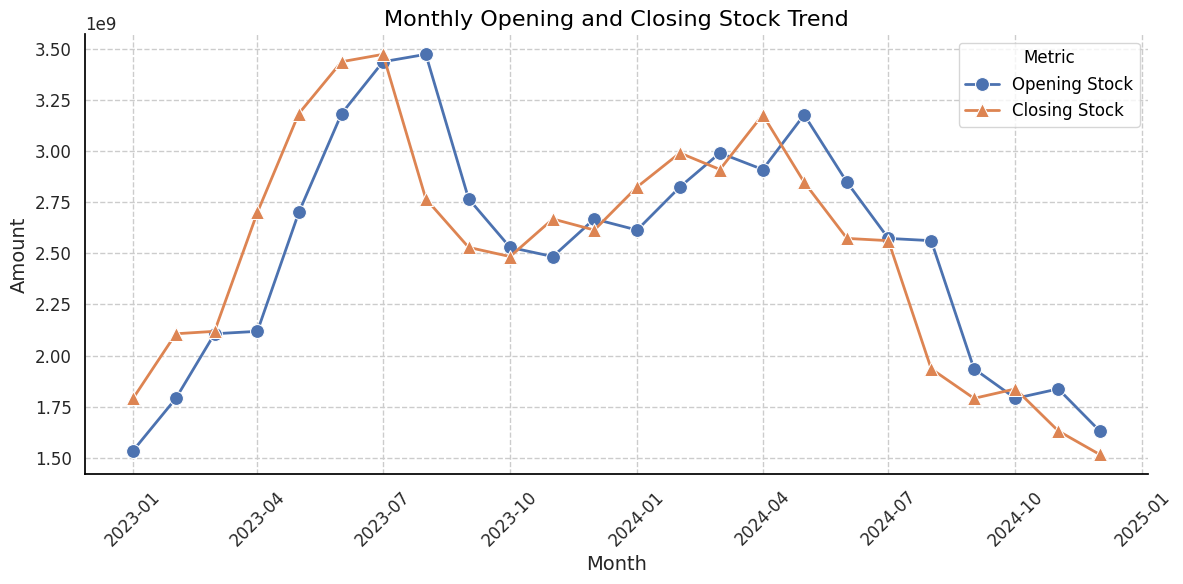

In [32]:
plot_monthly_stock(data, save_path='../results/eda/monthly_stock_trend.png')

**Observations**
* **Trend Over Time:**
> * Both the Opening Stock and Closing Stock amounts show fluctuations over the given period.
>* There are noticeable peaks and troughs in both series, indicating periods of increase and decrease in stock amounts.

* **Initial Period (Early 2023):**
> * Both Opening Stock and Closing Stock start at lower values in January 2023.
> * There is a steady increase in both series from January 2023 to around July 2023, with the Closing Stock generally higher than the Opening Stock.

* **Mid Period (Mid 2023 to Early 2024):**
> * The stock amounts peak around July 2023, with both Opening Stock and Closing Stock reaching their highest values.
> * Following the peak, there is a decline in both series, with some fluctuations, until around January 2024.

* **Later Period (Mid 2024 to Early 2025):**
> * There is another peak in both series around April 2024.
After April 2024, both series show a declining trend, with the Closing Stock generally lower than the Opening Stock towards the end of the period.

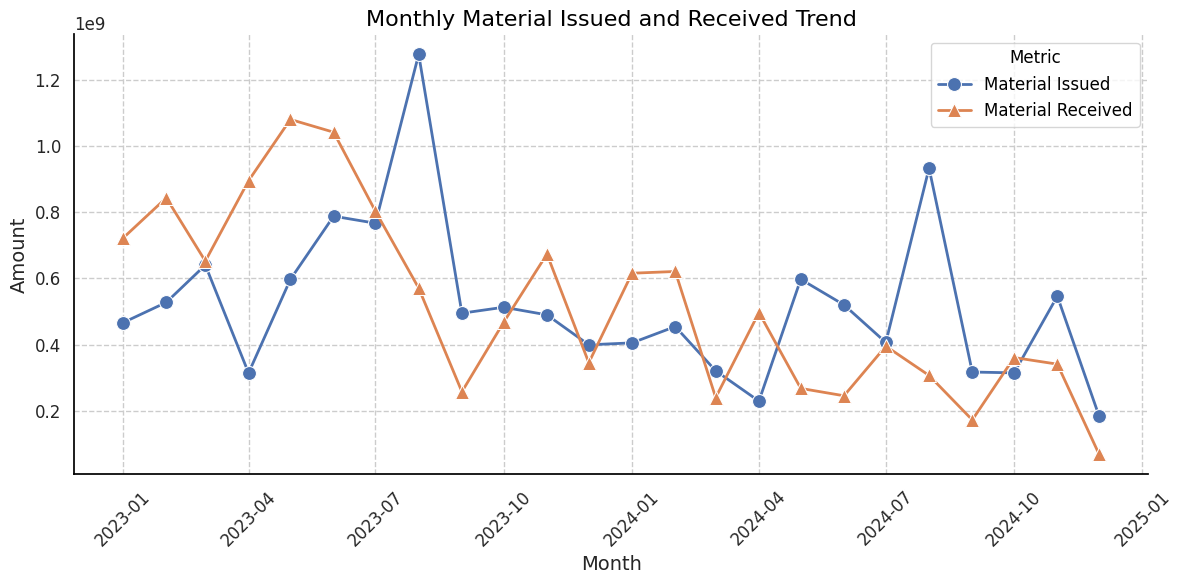

In [33]:
plot_monthly_material_flow(data, save_path='../results/eda/monthly_material_flow.png')

**Observations**

* **Initial Period (Early 2023):**
> * Both Material Issued and Material Received amounts start at lower values in January 2023.
> * There is a noticeable increase in both series from January 2023 to around April 2023, with Material Received generally higher than Material Issued.

* **Mid Period (Mid 2023):**
> * There is a significant peak in Material Issued around July 2023, reaching the highest value in the observed period.
Material Received also shows an increase but remains lower than Material Issued during this peak.
> * Following the peak, both series show a decline, with fluctuations, until around October 2023.

* **Later Period (Late 2023 to Early 2024):**
> * Both series exhibit fluctuations with no clear trend, indicating variability in material issuance and receipt.
> * Material Received shows more frequent fluctuations compared to Material Issued.

* **Mid Period (Mid 2024):**
> * There is another notable peak in Material Issued around July 2024, similar to the peak observed in July 2023.
> * Material Received also increases but remains lower than Material Issued during this period.

* **End Period (Late 2024 to Early 2025):**
> * Both series show a declining trend towards the end of the period, with Material Issued generally higher than Material Received.
> * The amounts for both series drop to their lowest values around January 2025.

## Data Distribution

Distribution of numerical features without any filter on data.

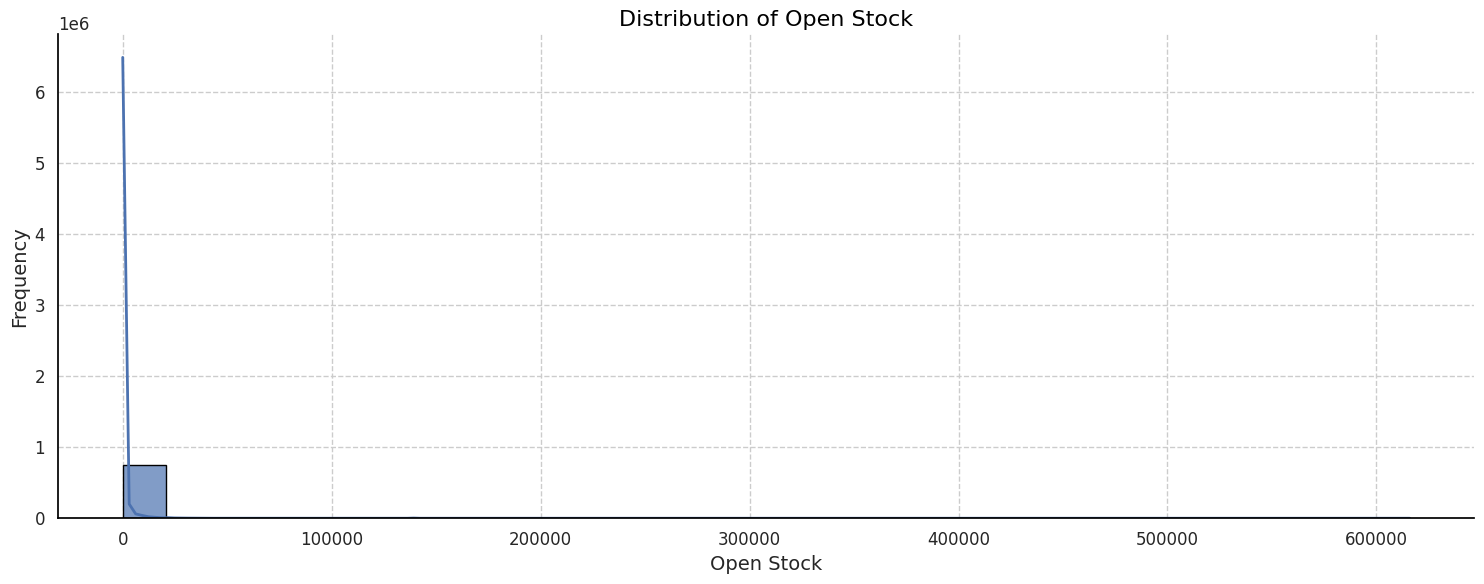

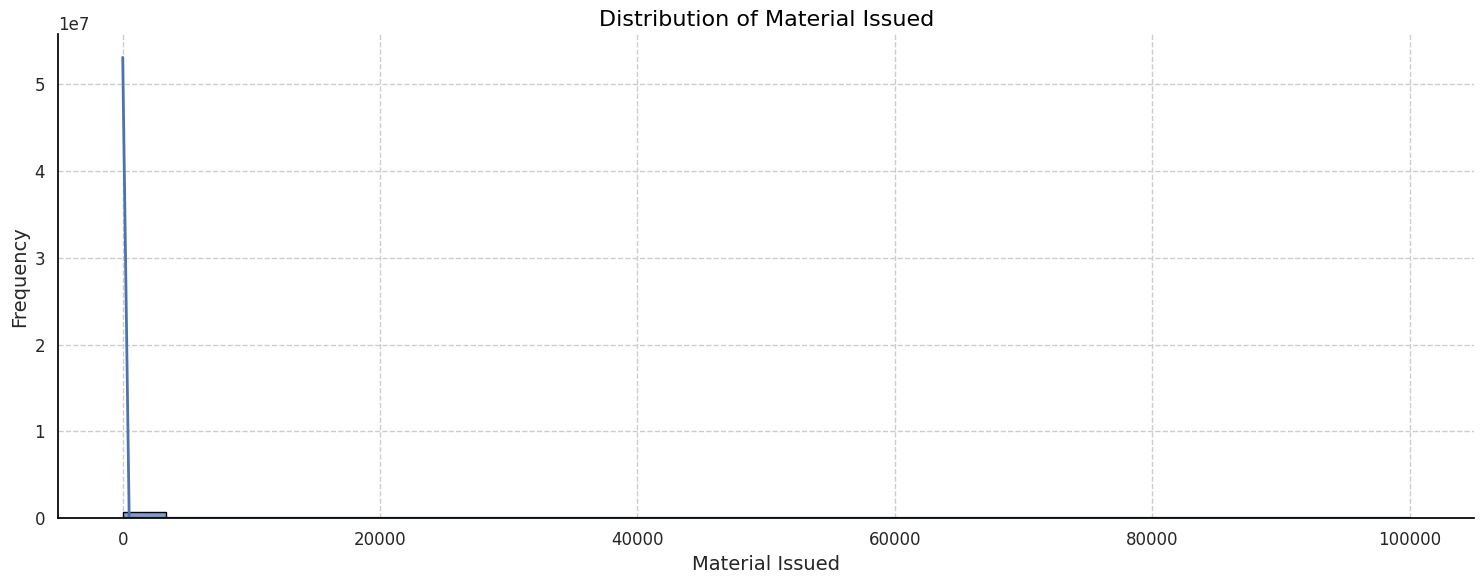

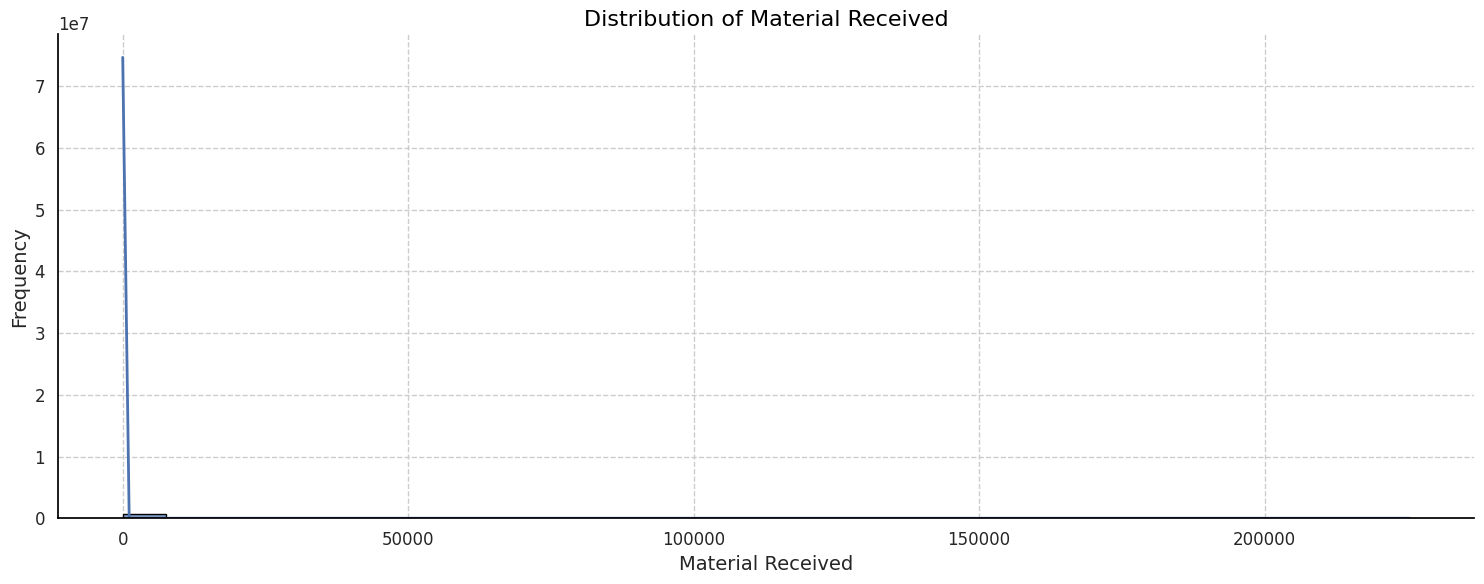

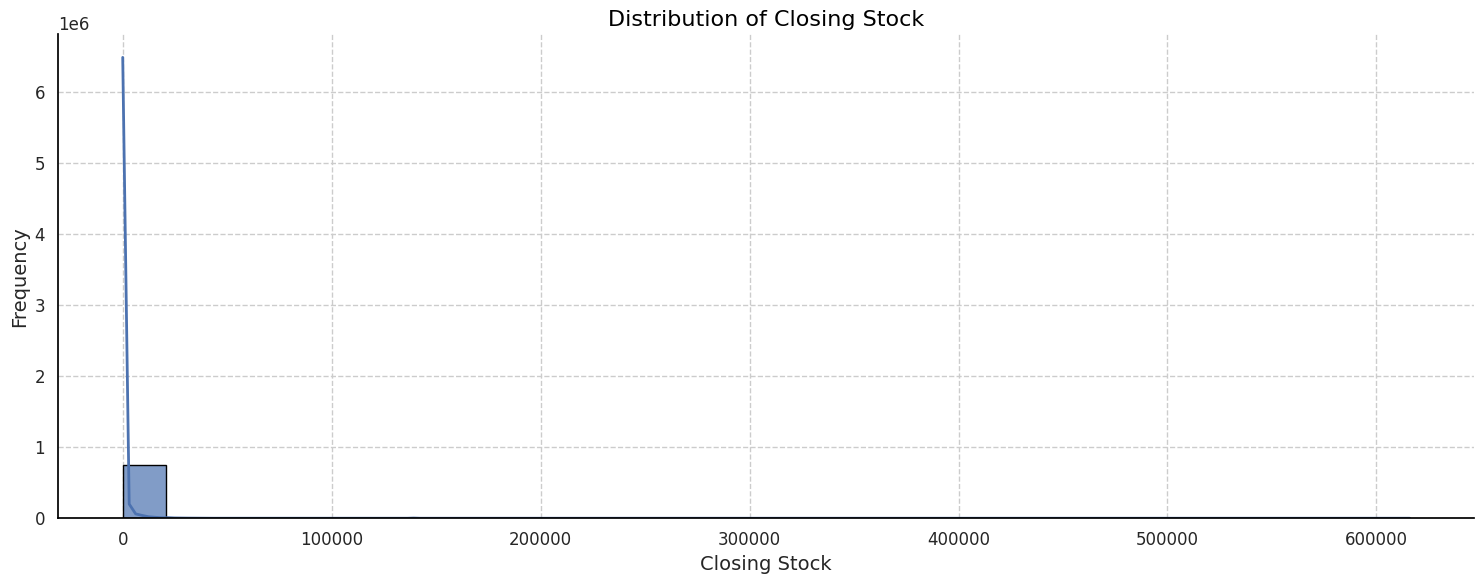

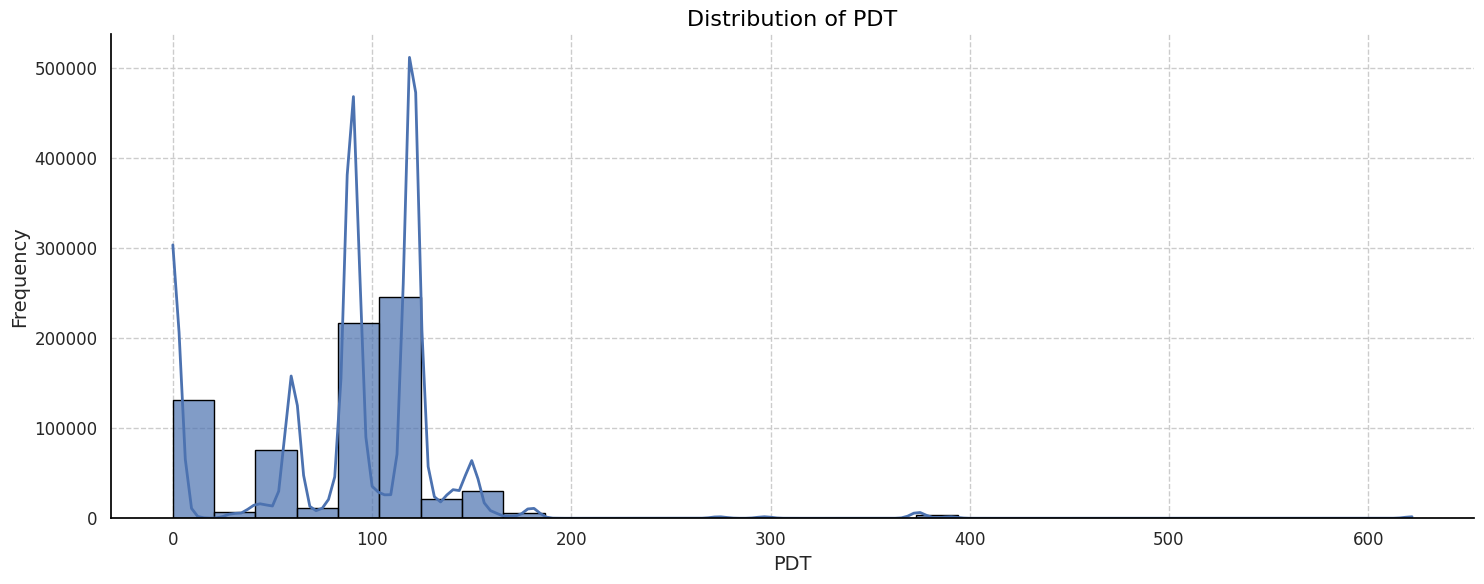

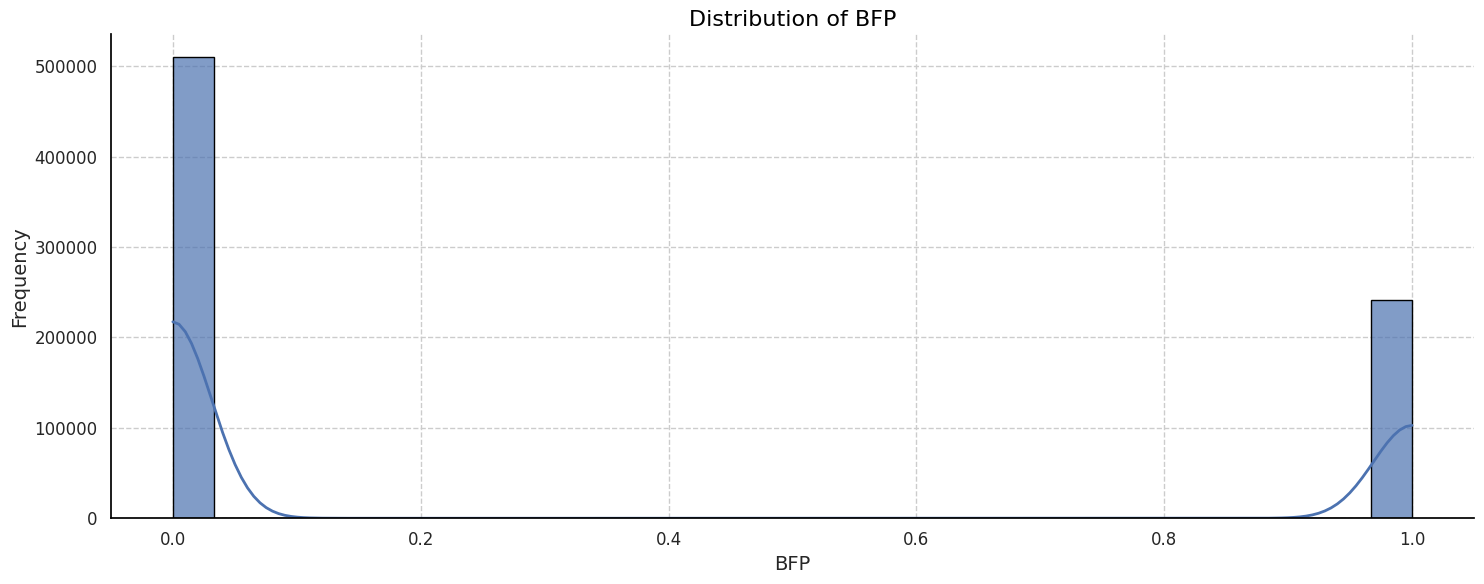

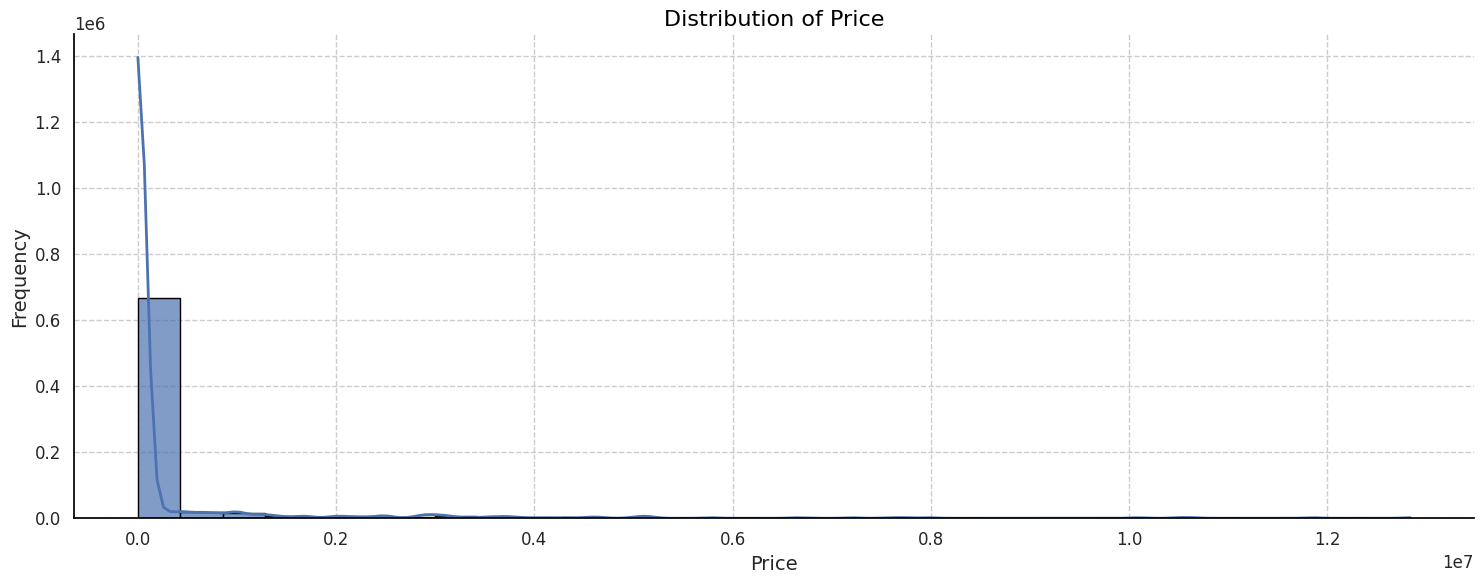

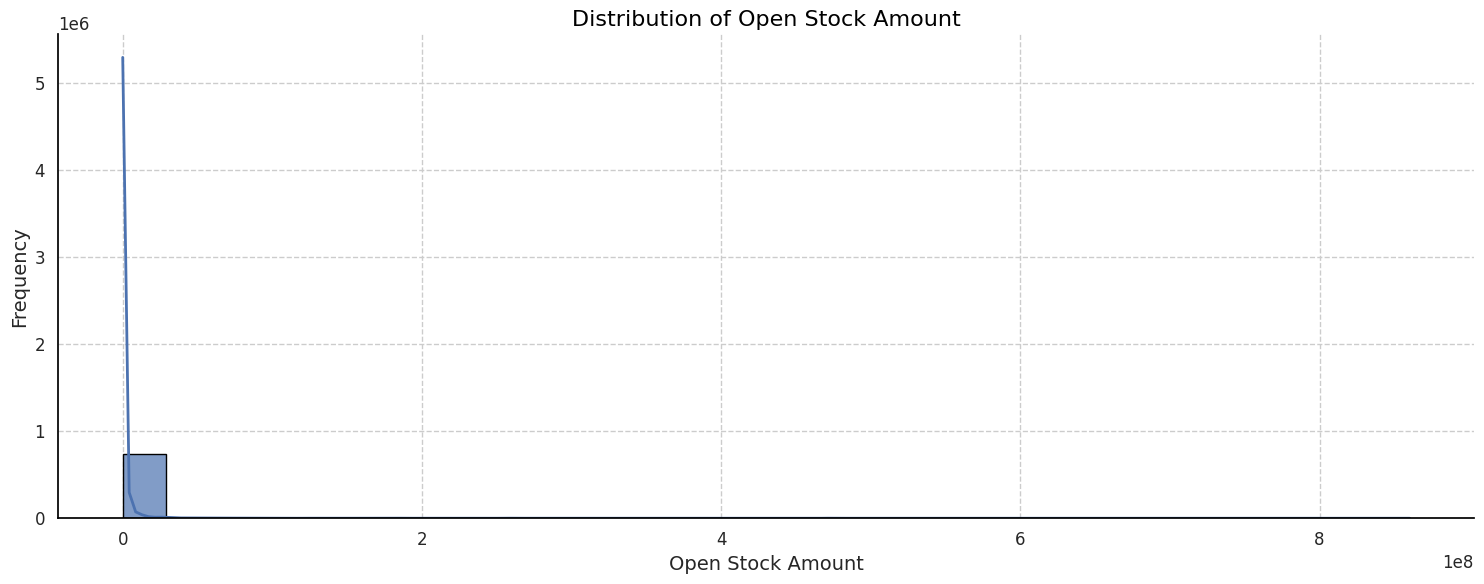

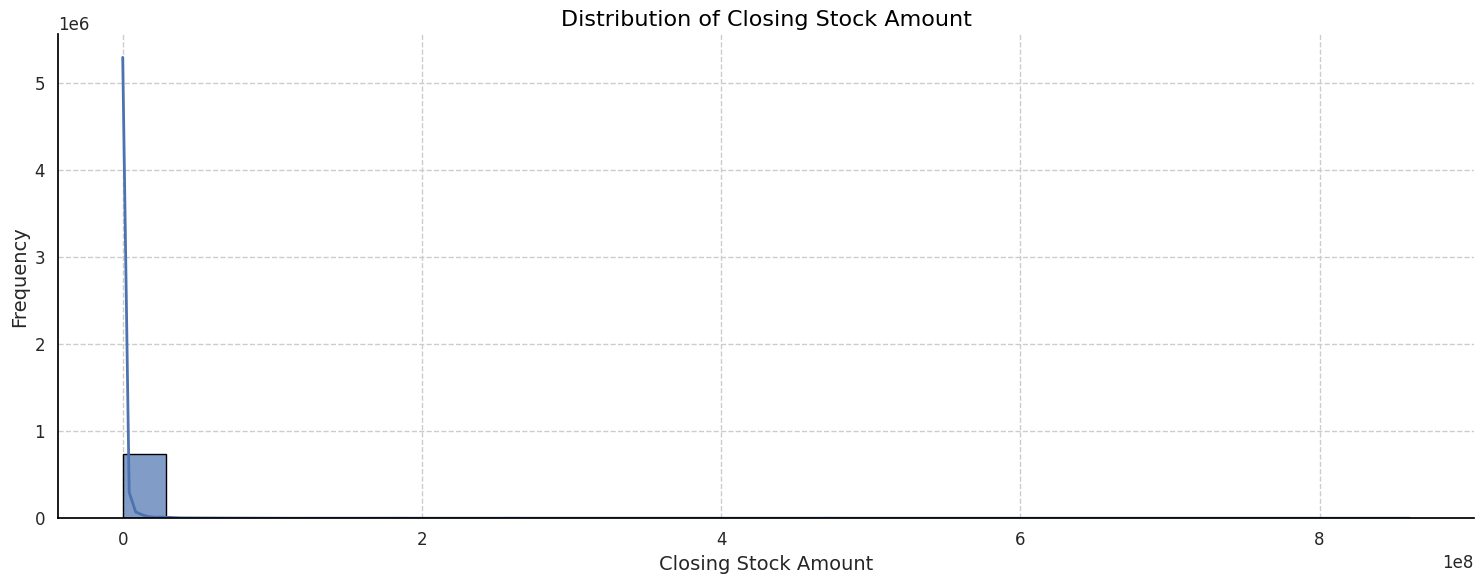

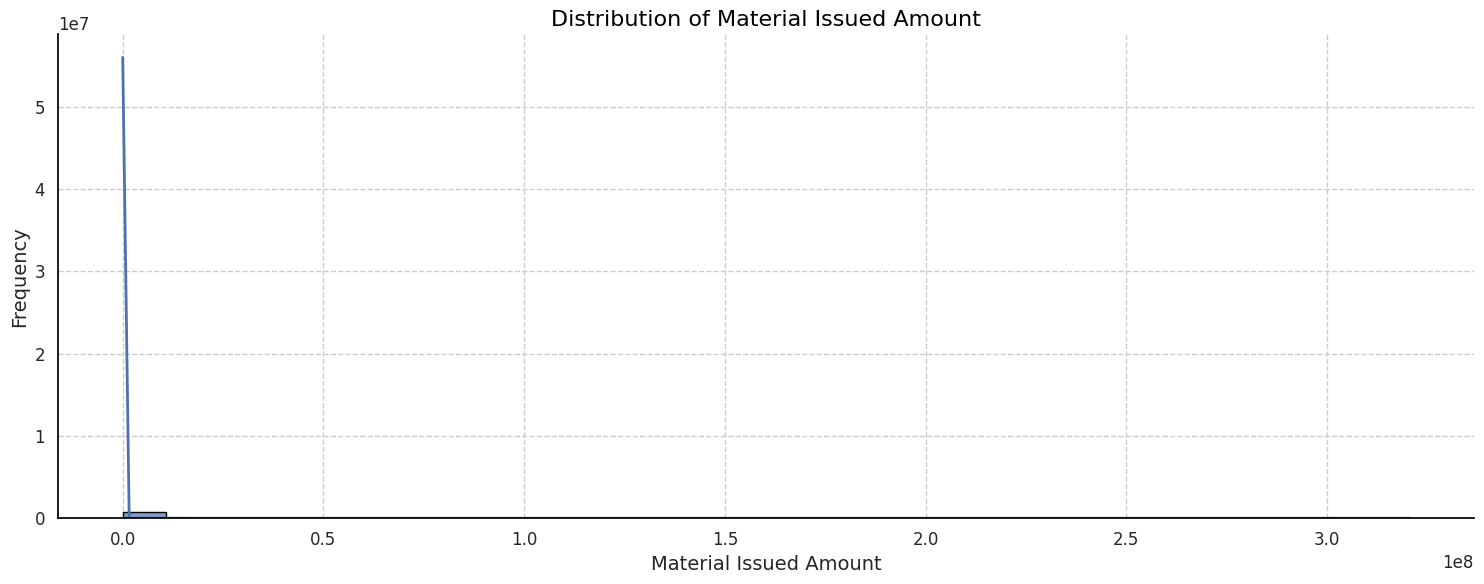

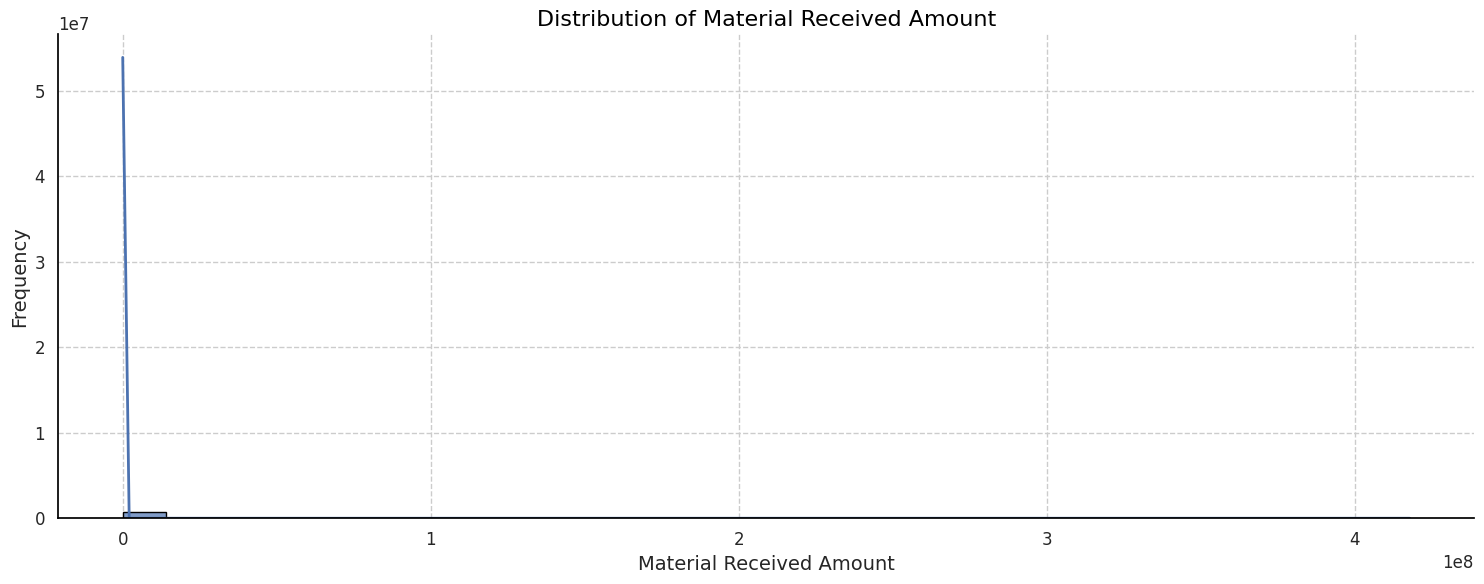

In [35]:
# Distribution plots for numerical columns using seaborn
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
for column in numerical_columns:
    sns.histplot(data[column], kde=True, bins=30, alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(f'../results/eda/{column}_Distribution.png')
    plt.show()

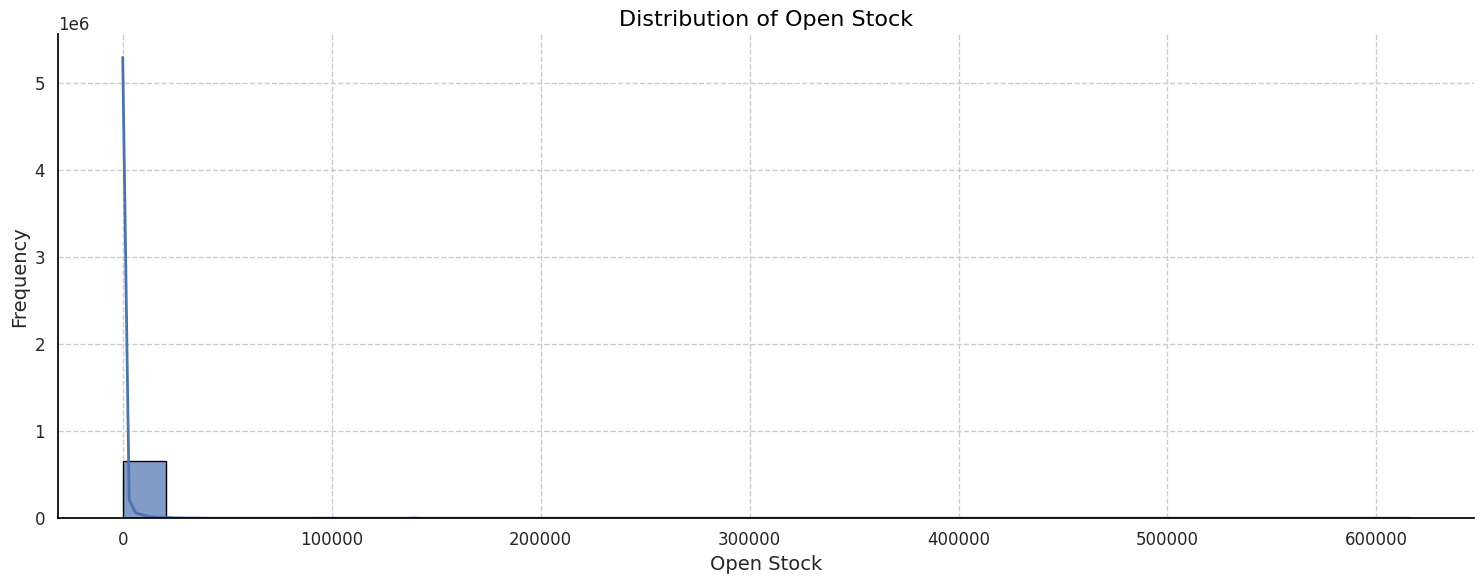

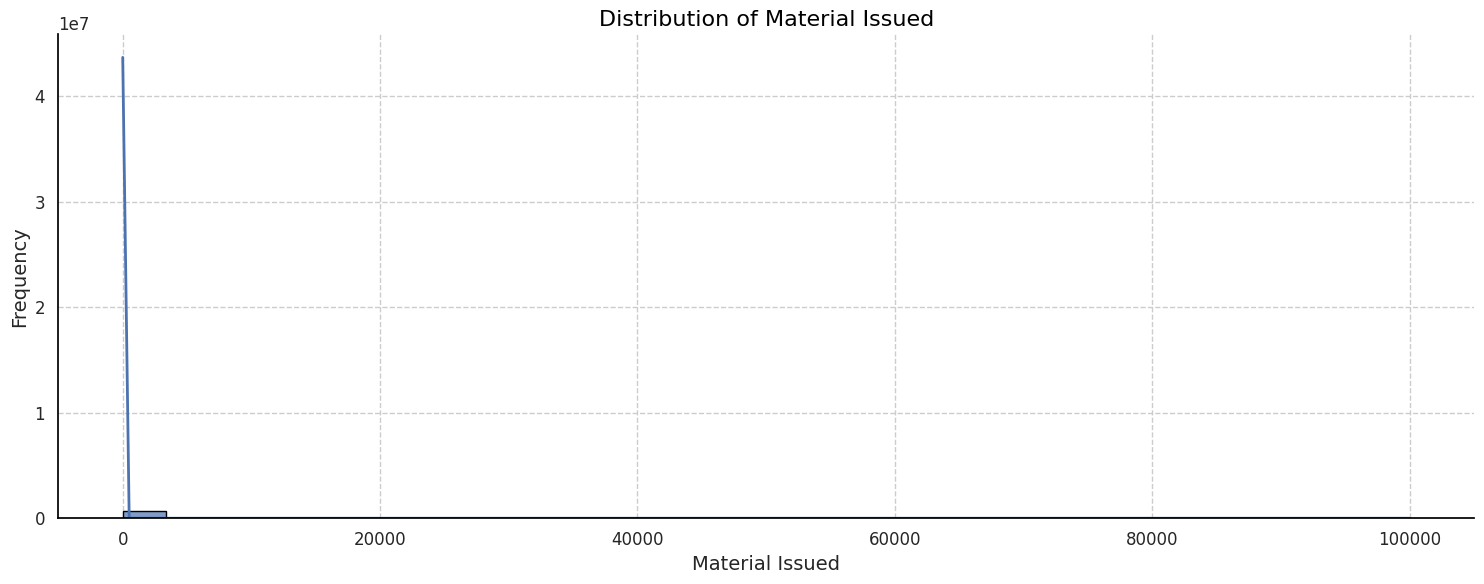

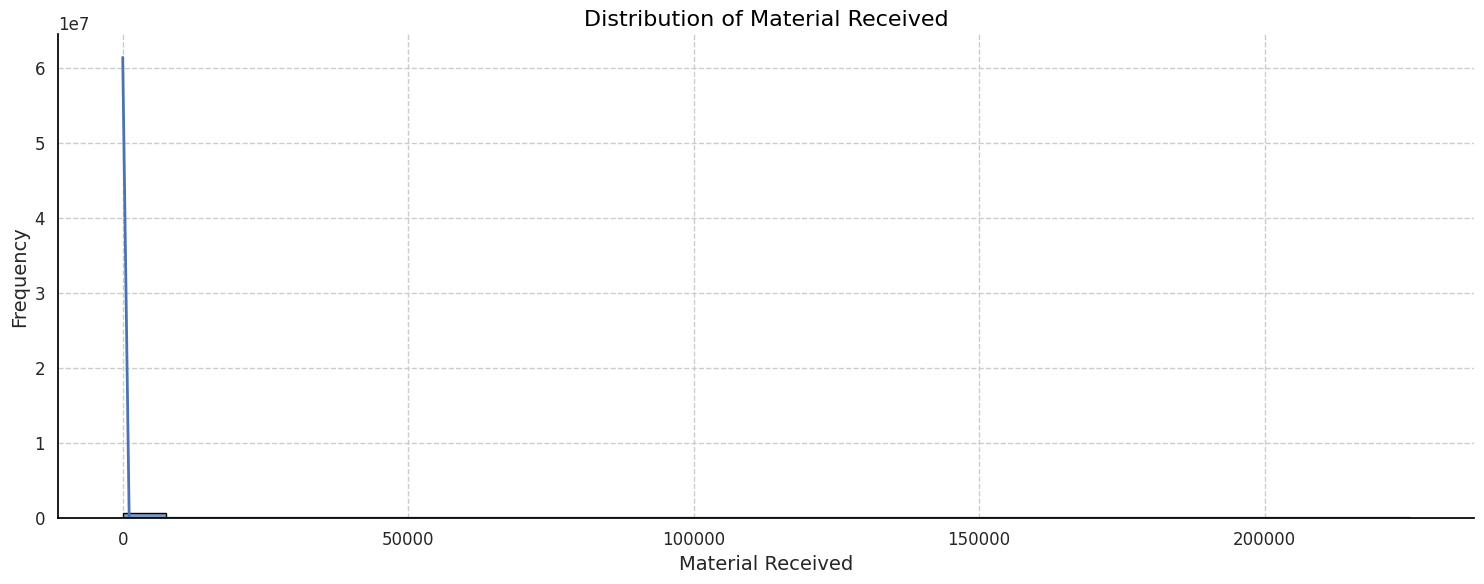

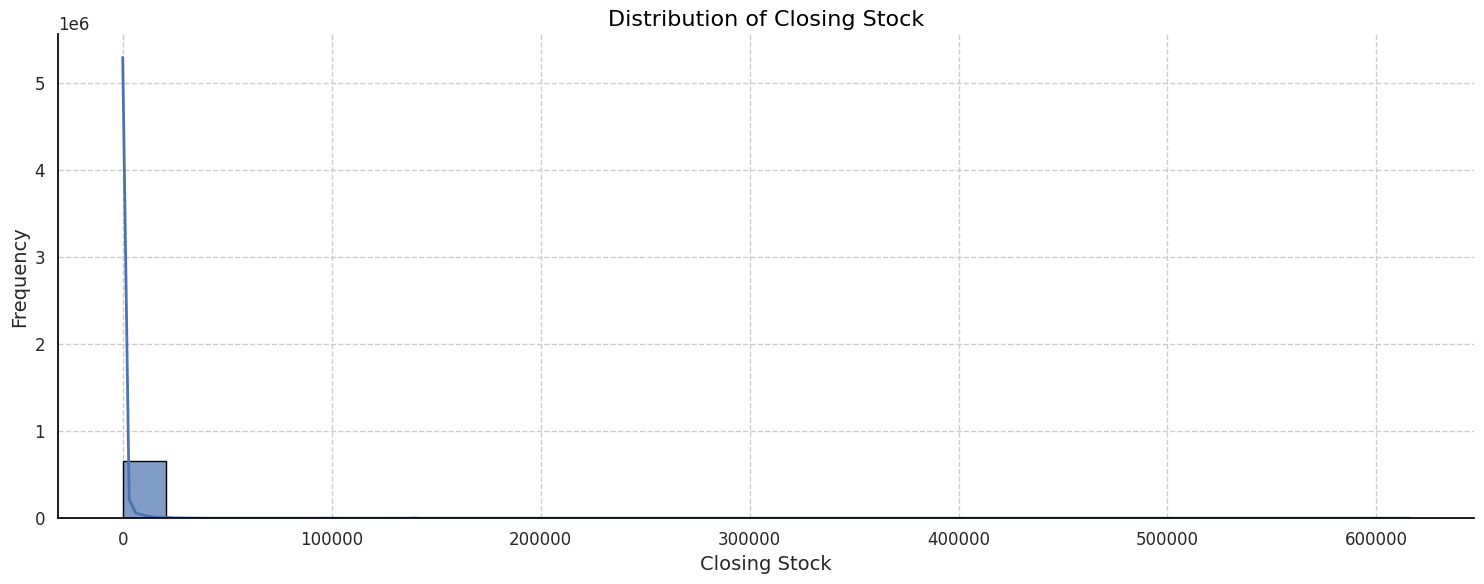

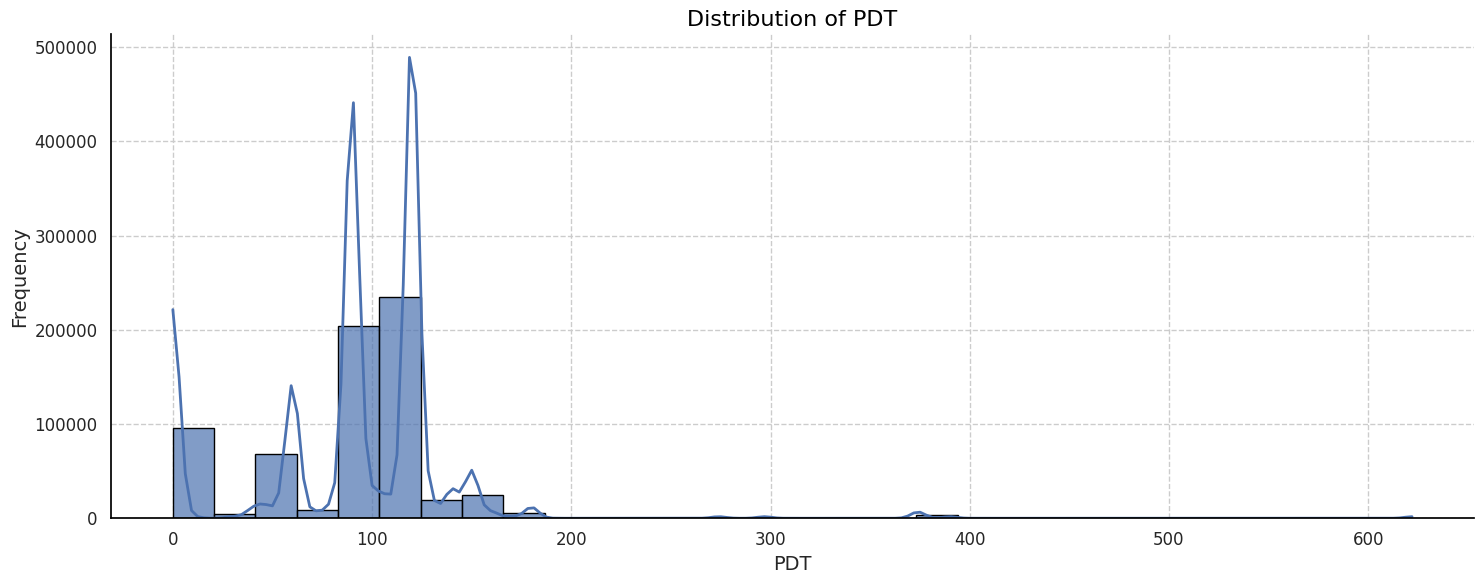

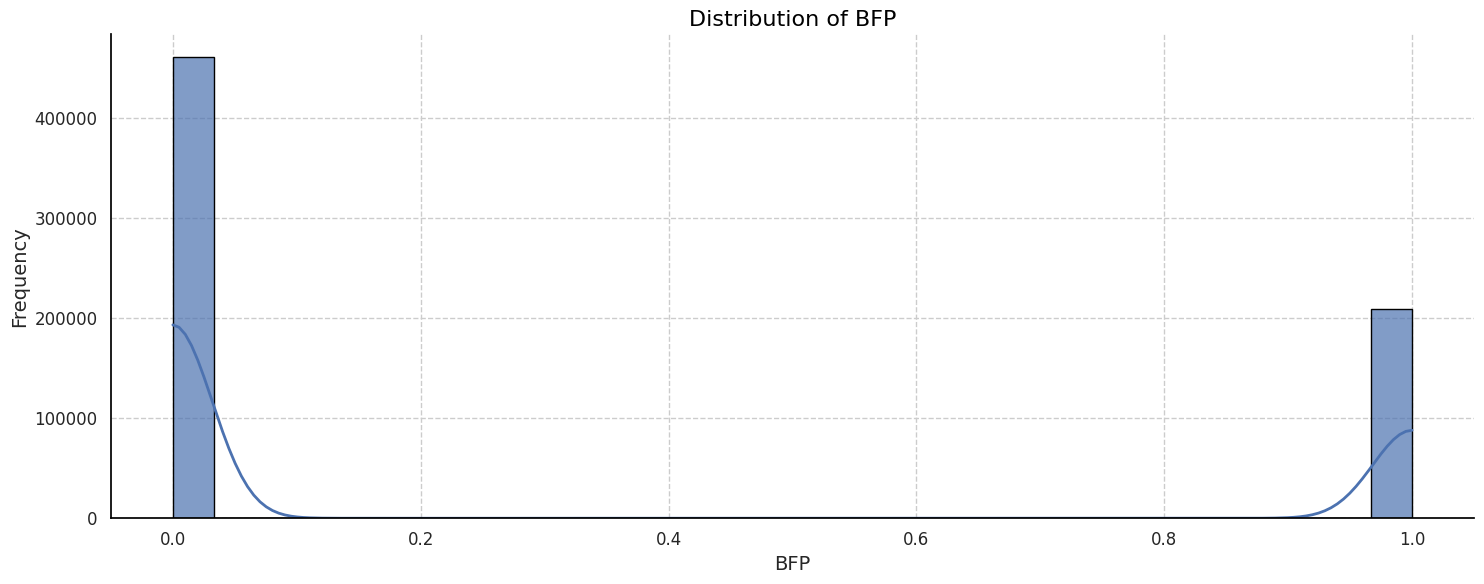

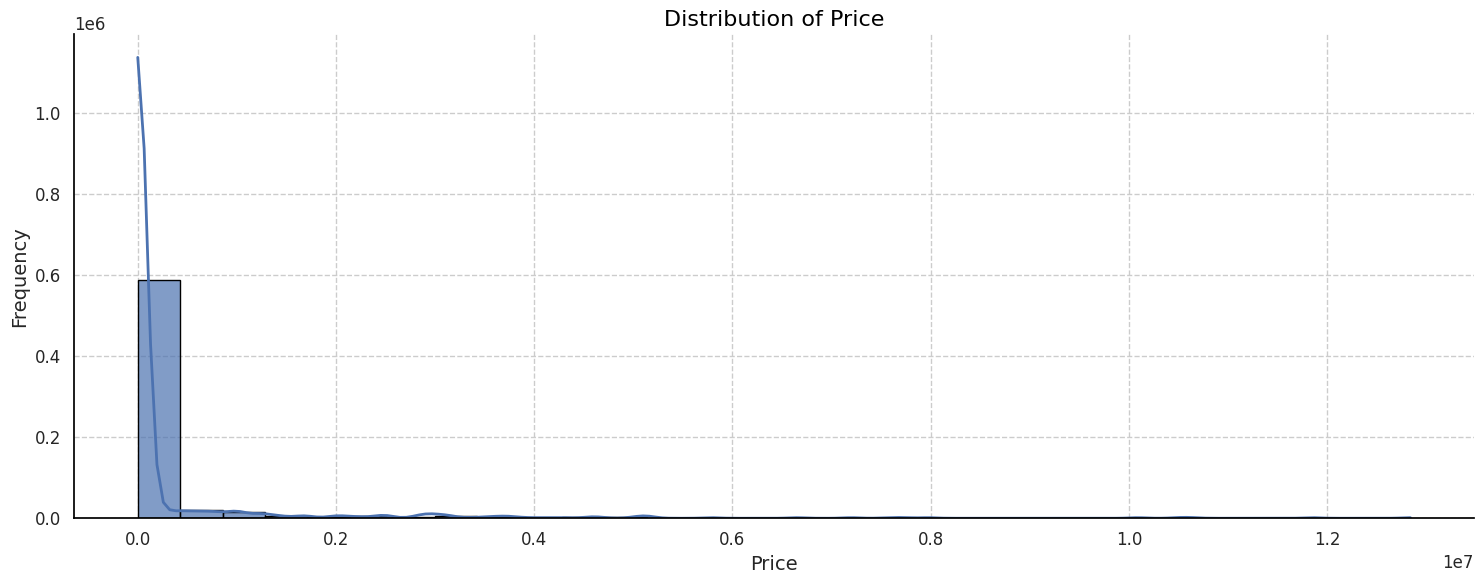

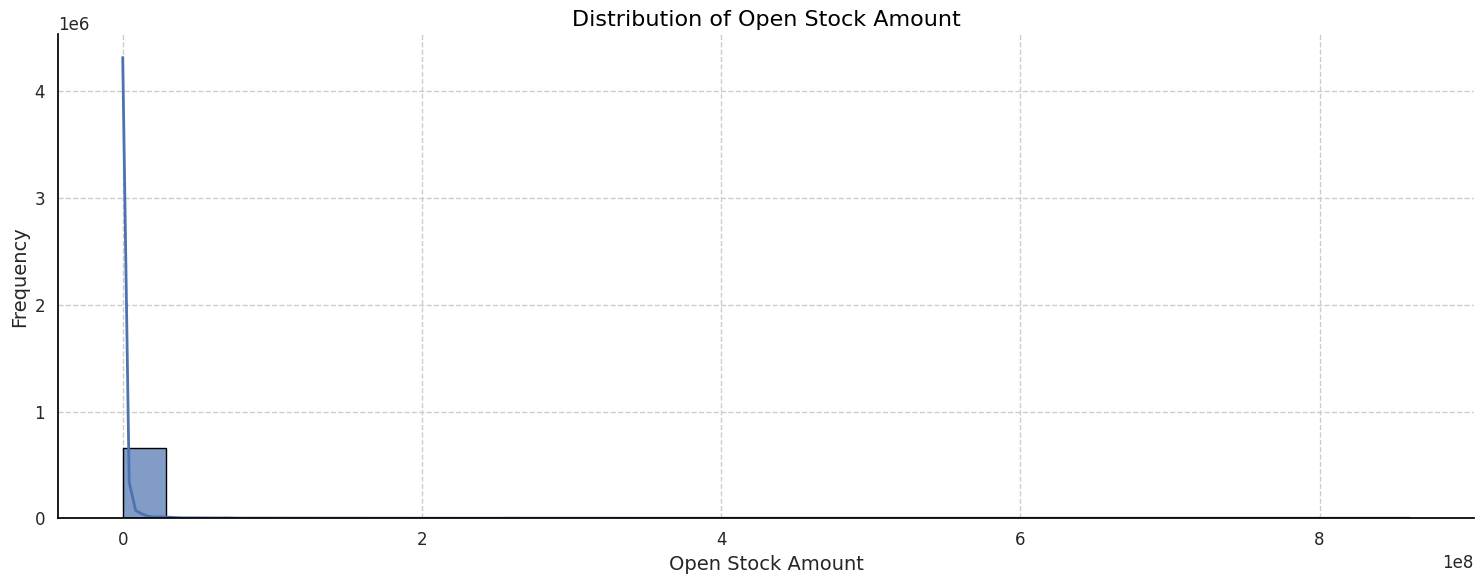

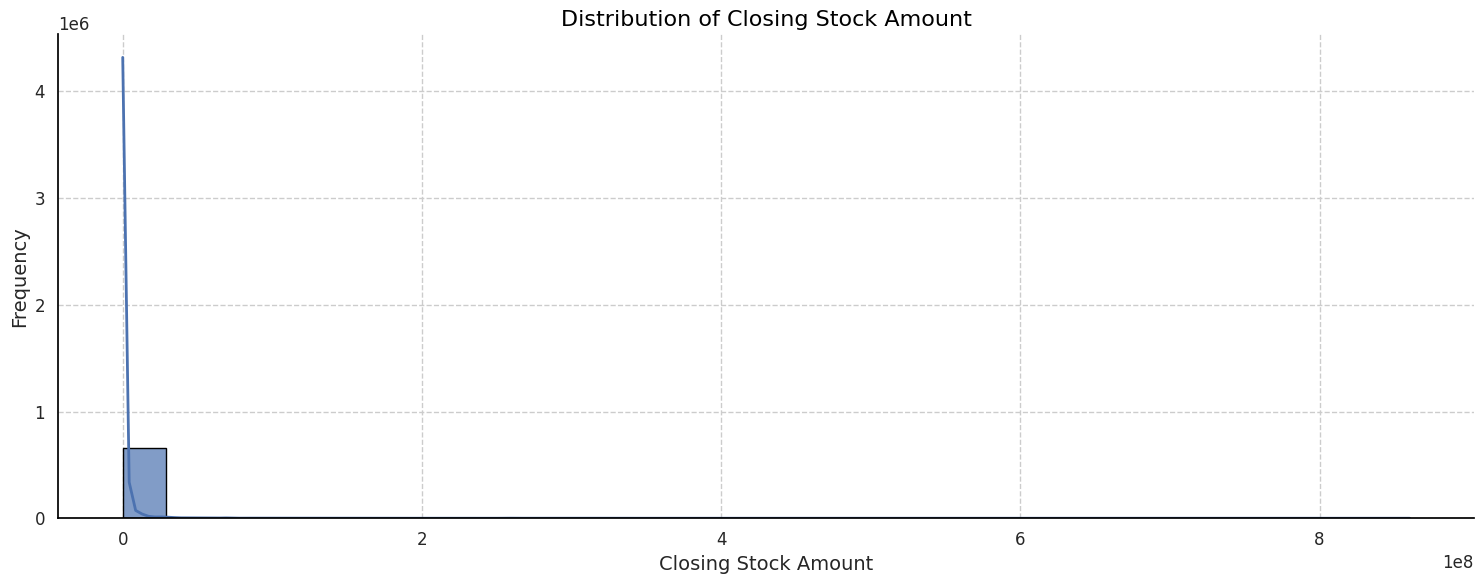

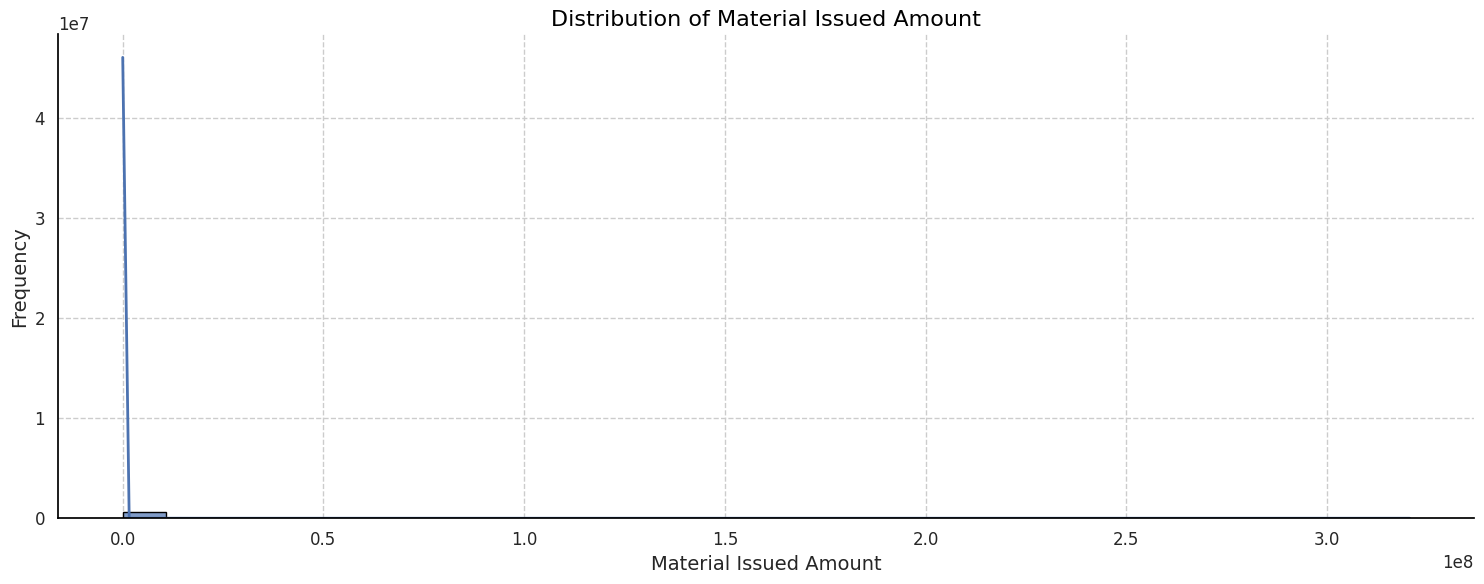

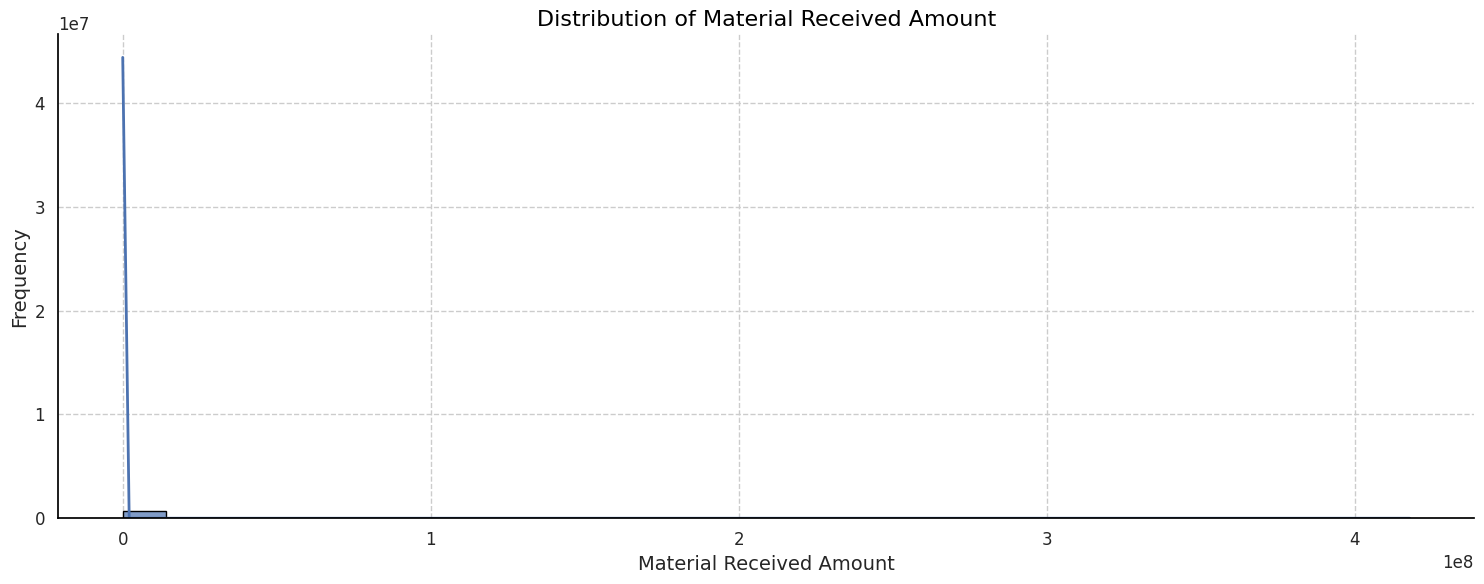

In [62]:
# Distribution plots for numerical columns using seaborn
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
for column in numerical_columns:
    sns.histplot(data[data['Type']=='Material'][column], kde=True, bins=30, alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(f'../results/eda/{column}_Material_Distribution.png')
    plt.show()

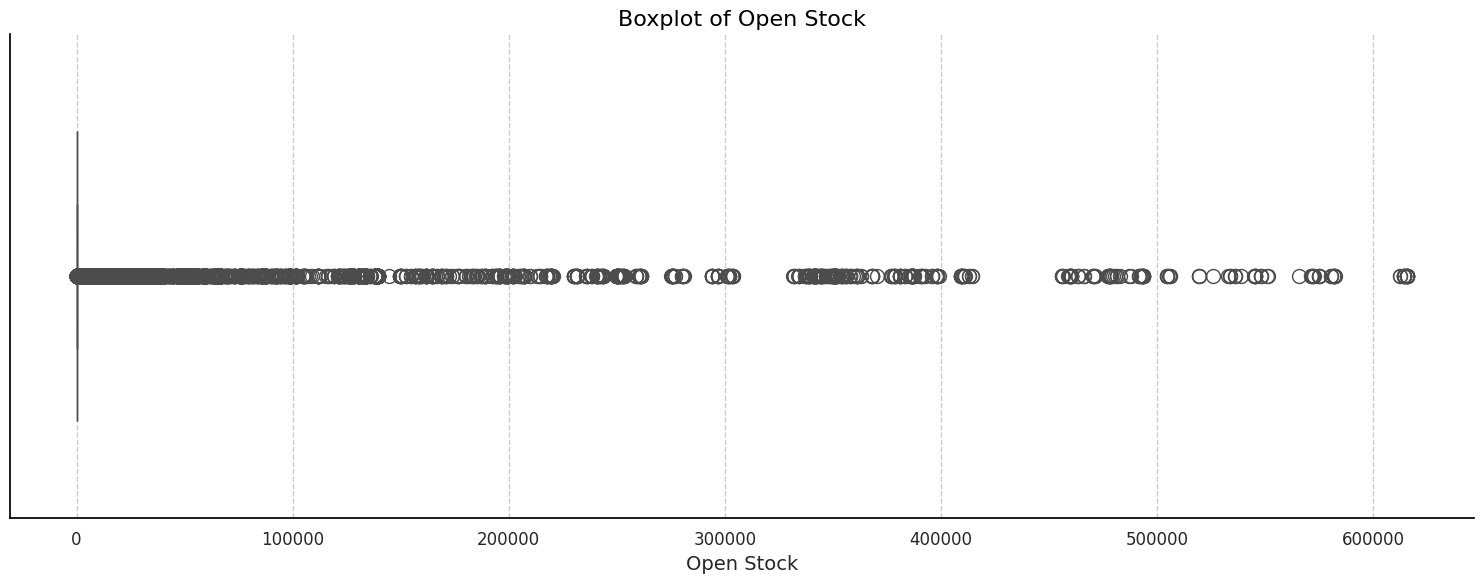

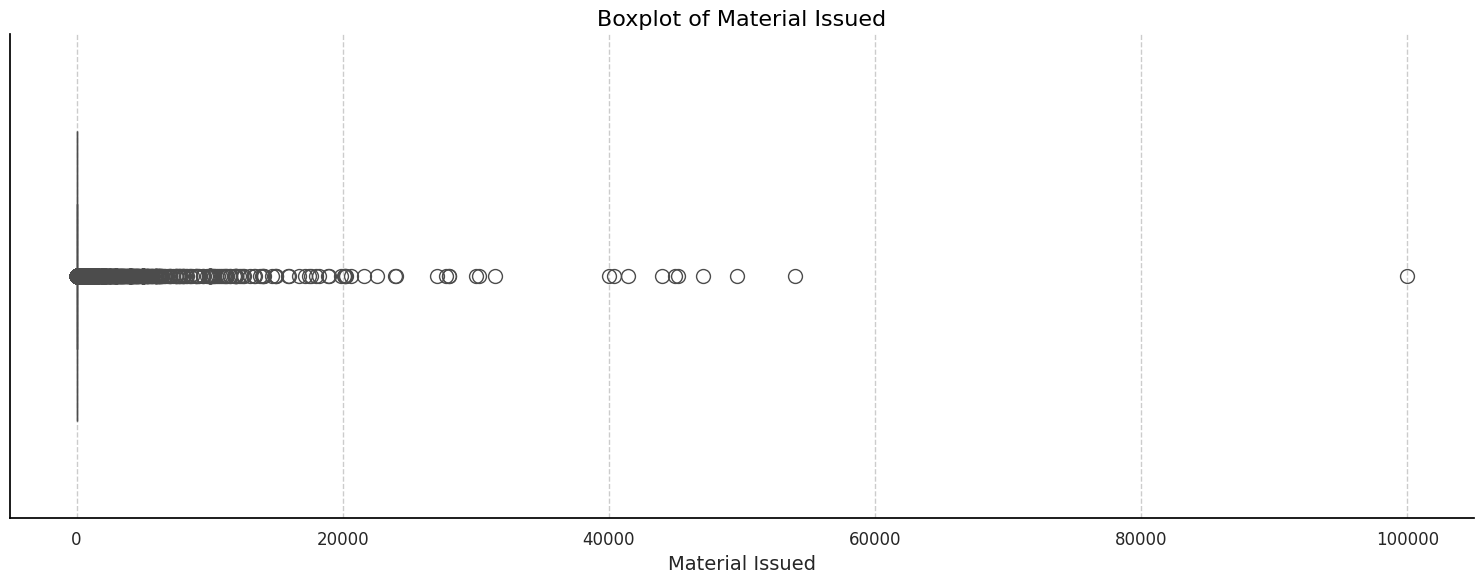

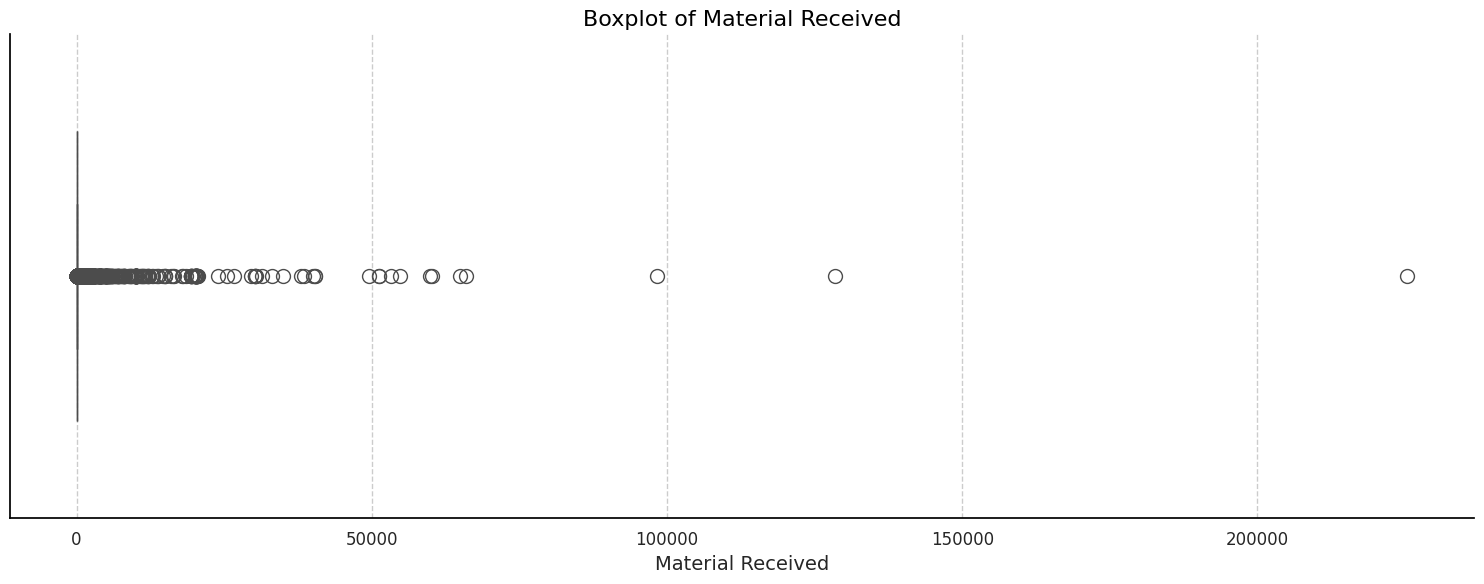

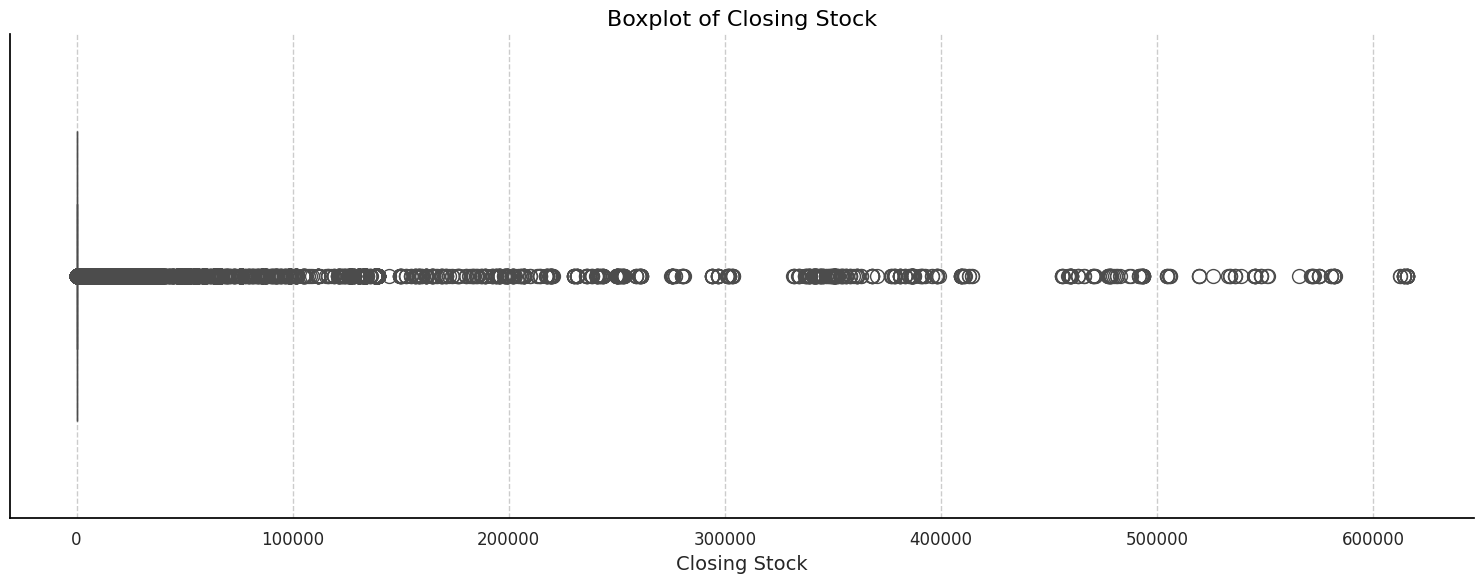

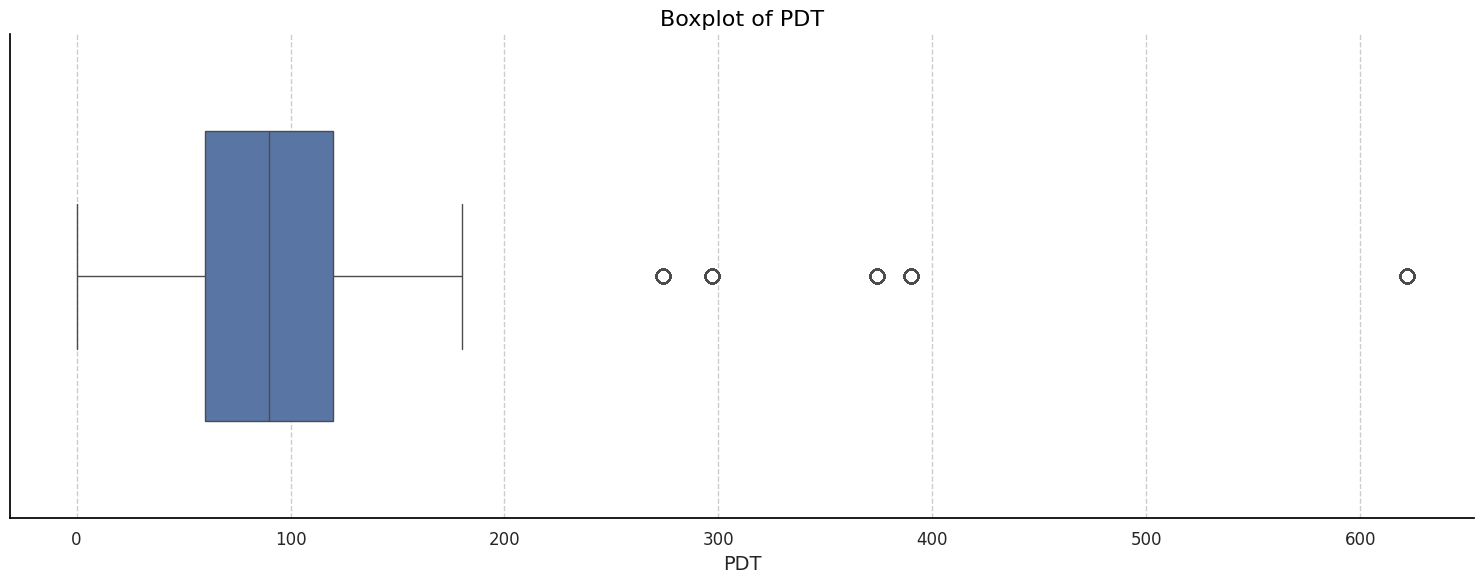

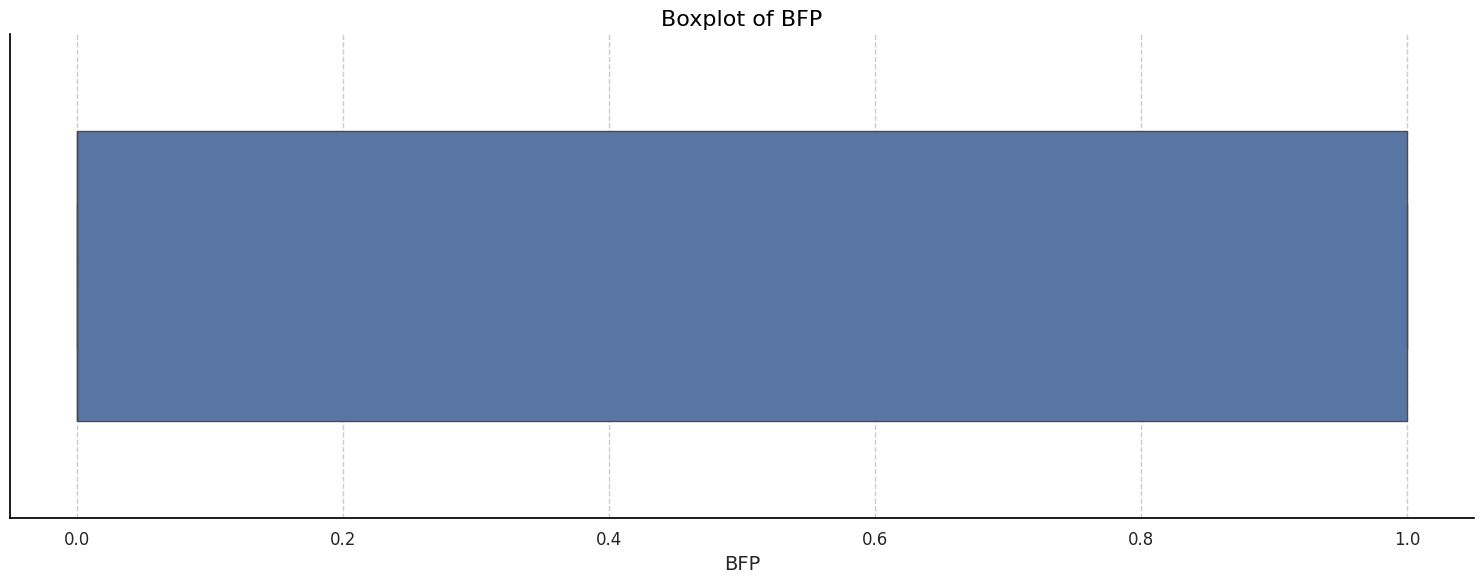

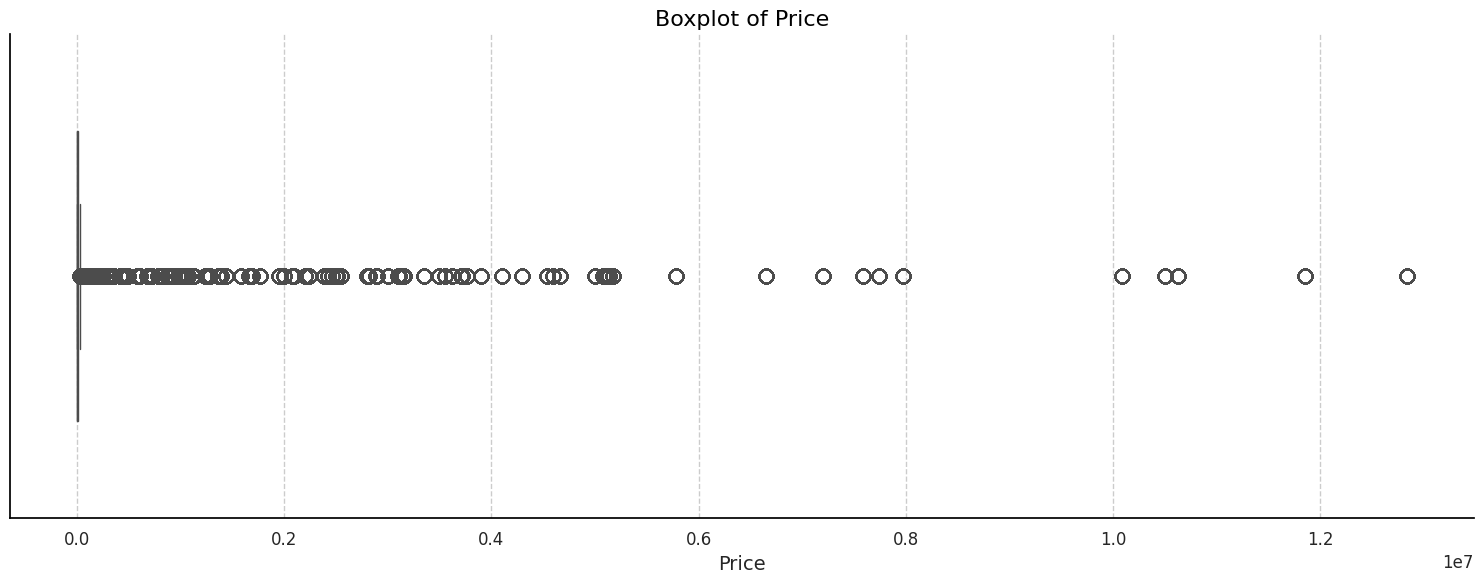

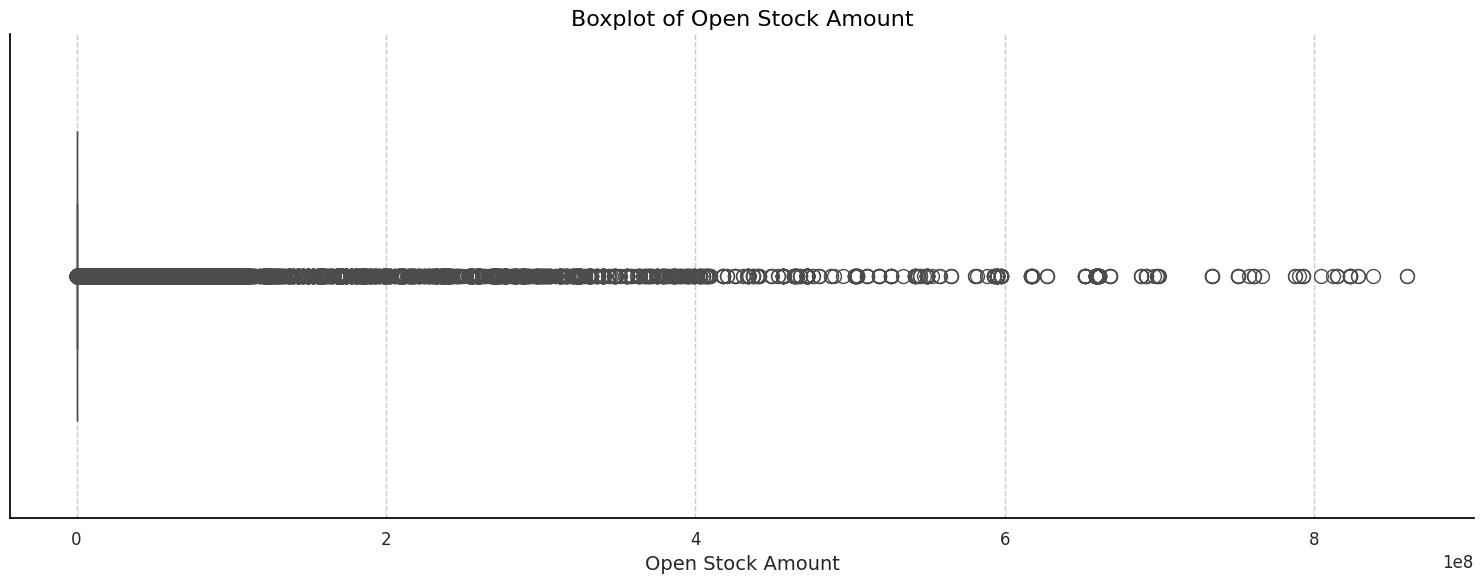

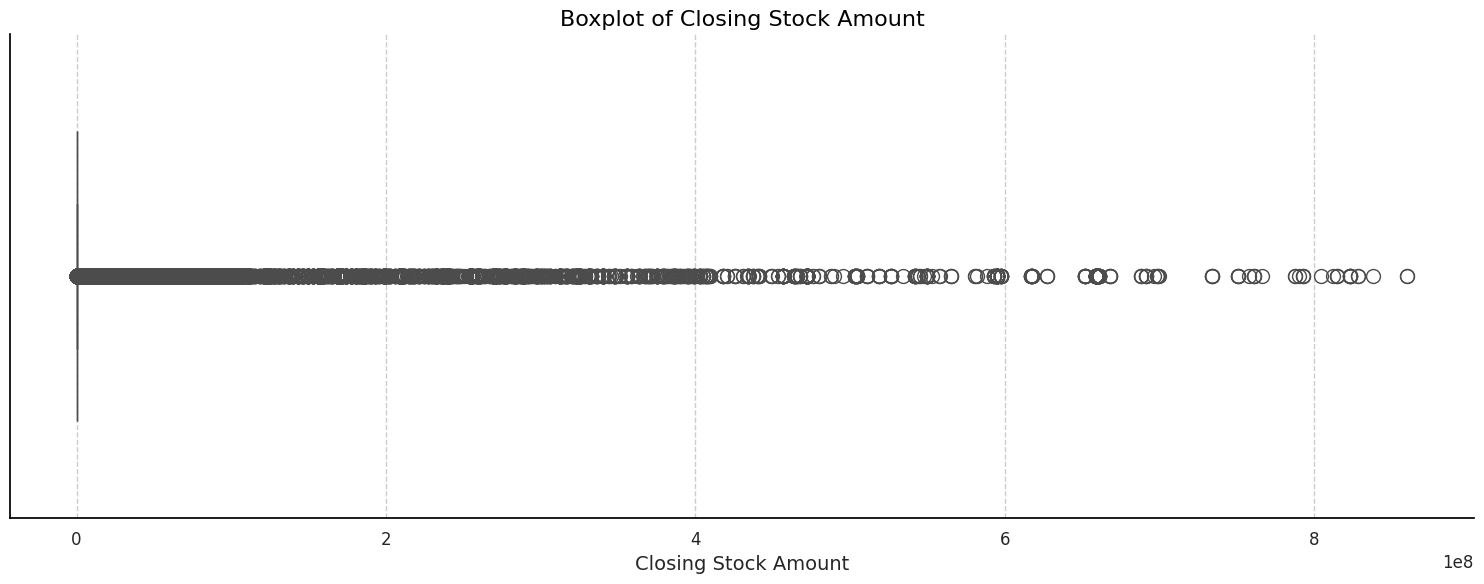

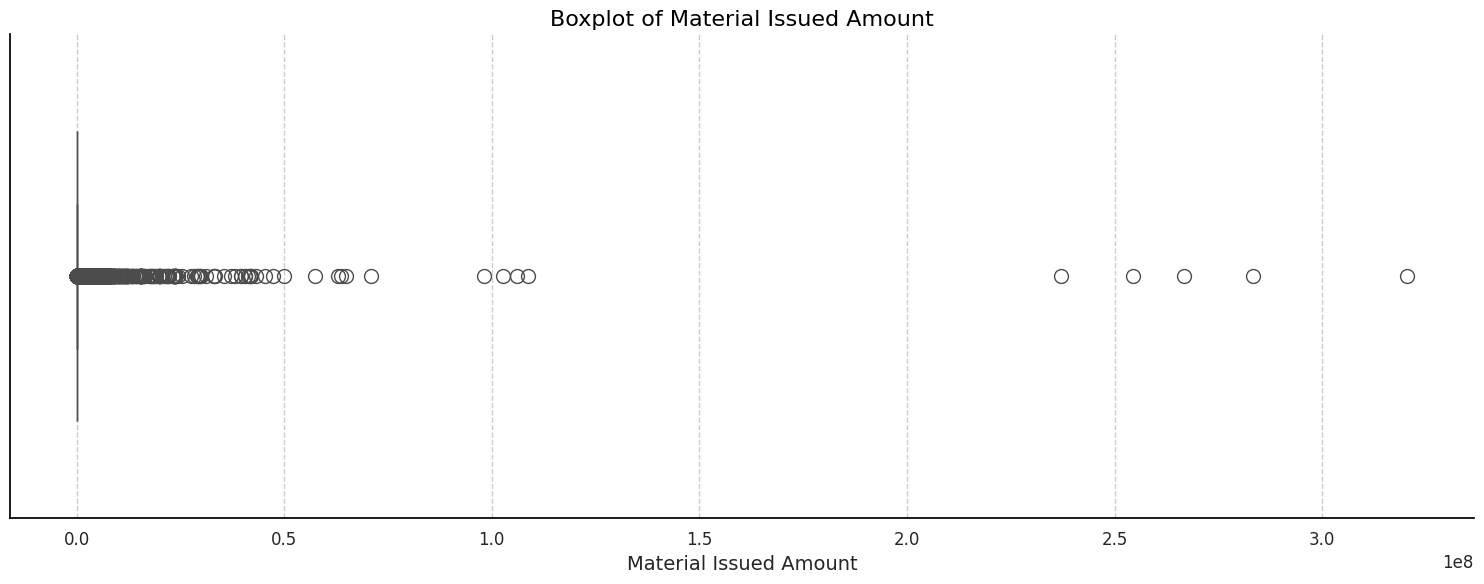

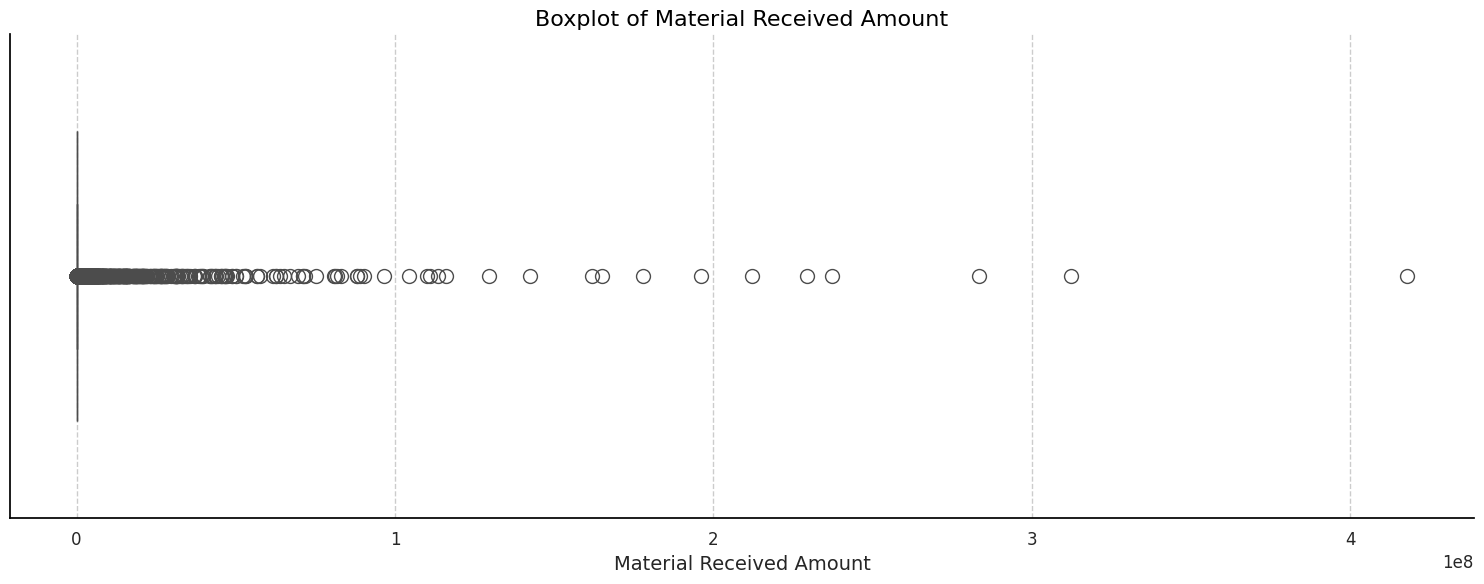

In [40]:
# Box plots for outlier detection using seaborn
for column in numerical_columns:
    sns.boxplot(x=data[column], width=0.6)
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.tight_layout()
    plt.savefig(f'../results/eda/{column}_Boxplot.png')
    plt.show()


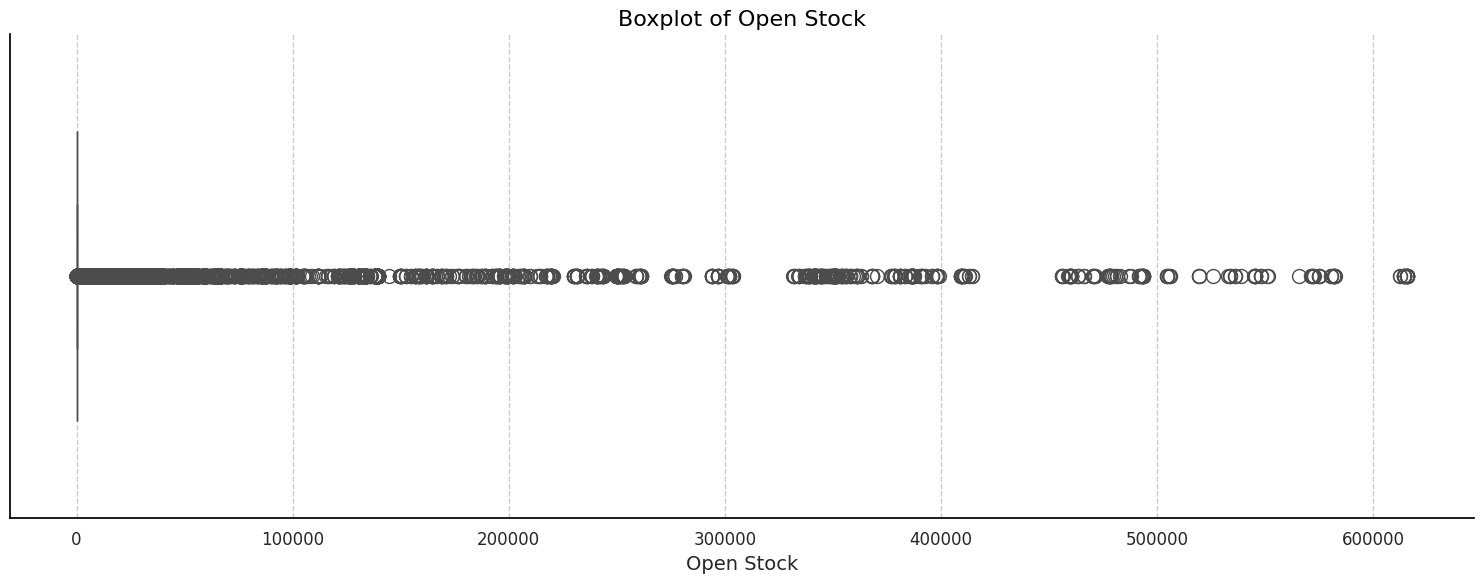

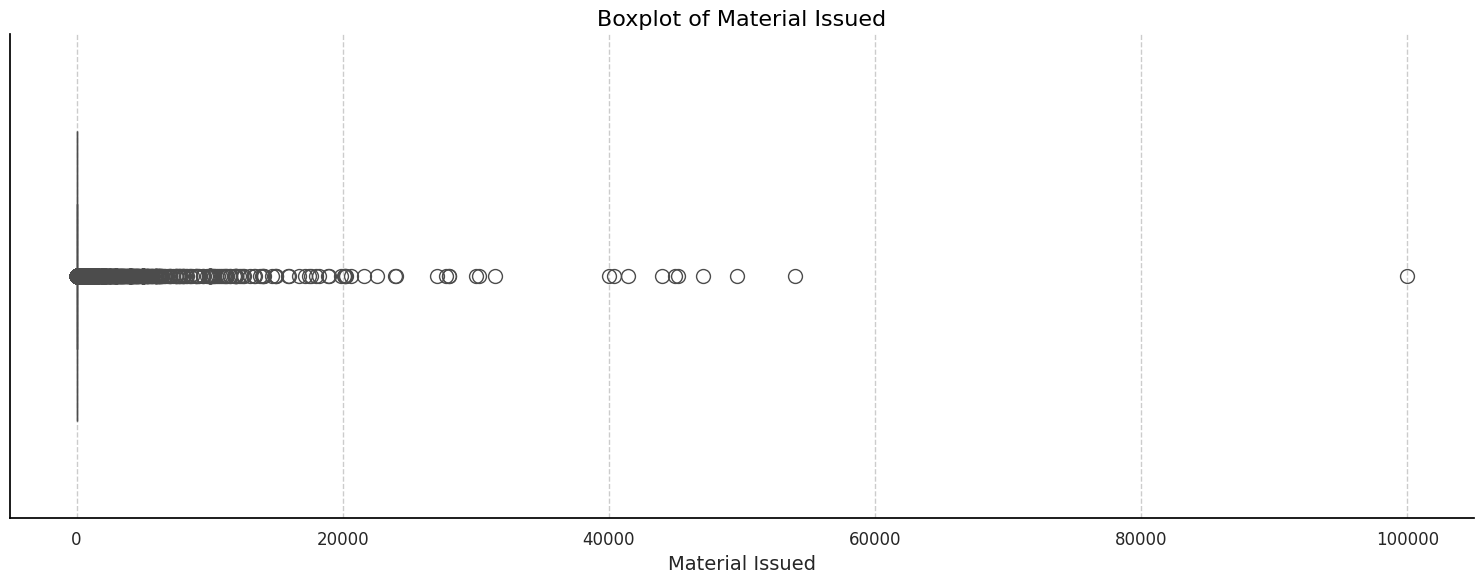

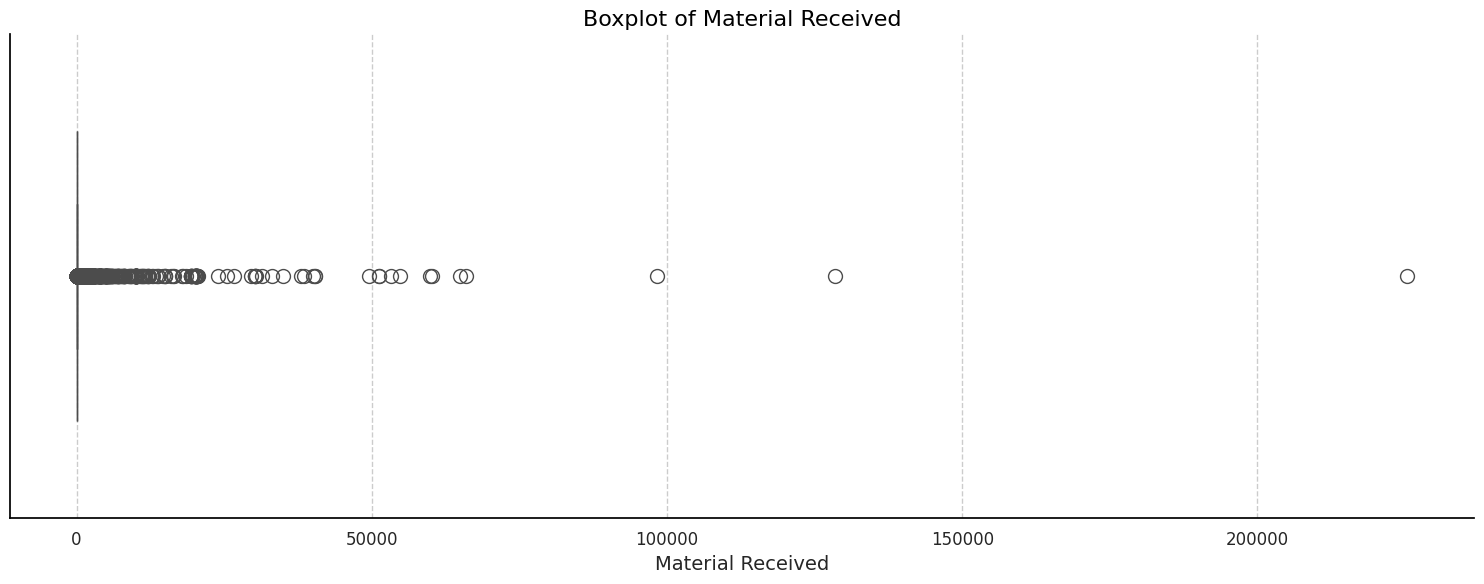

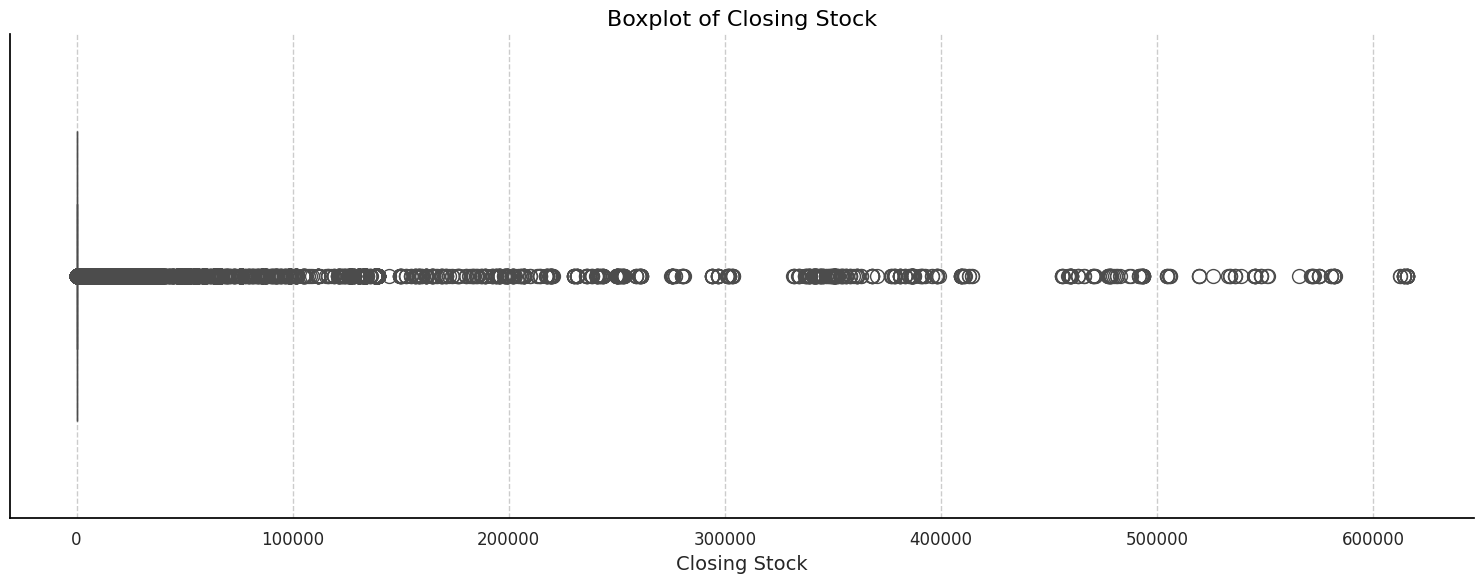

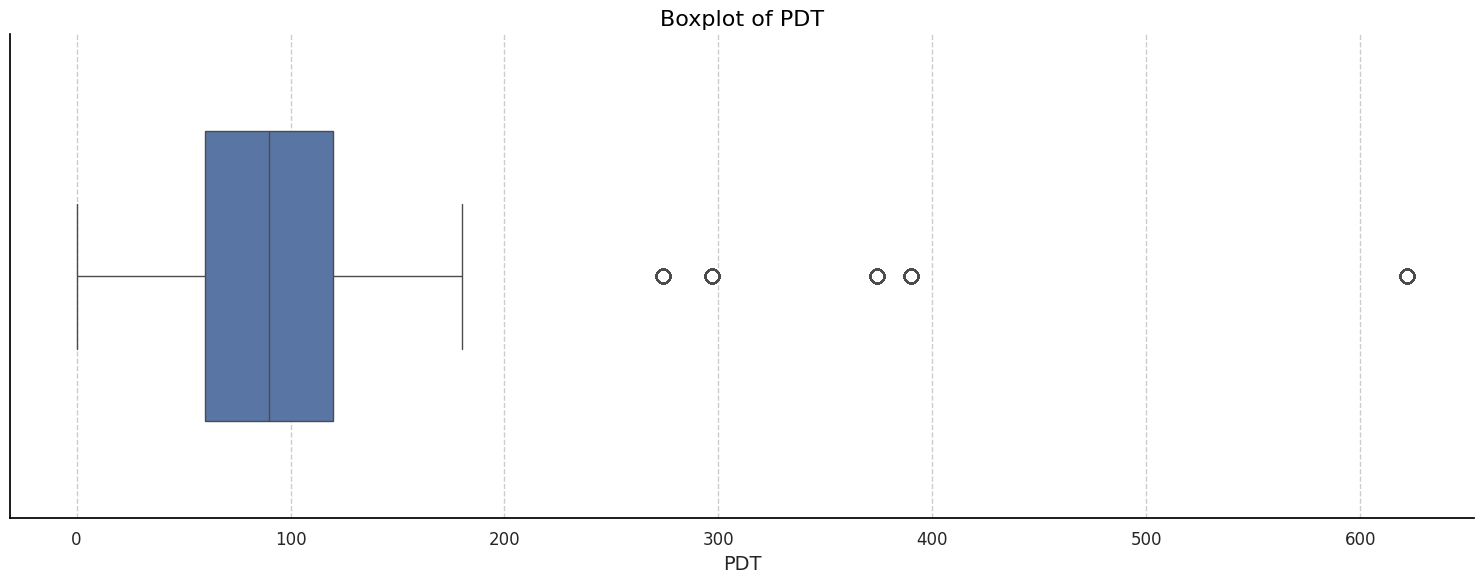

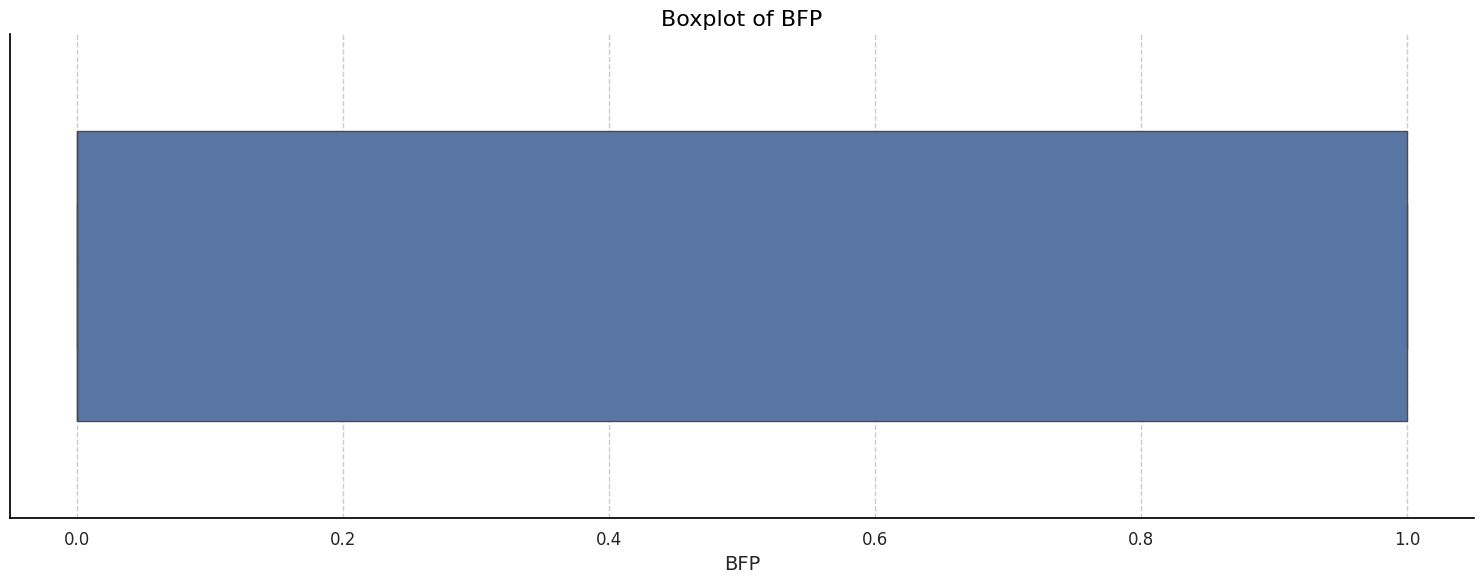

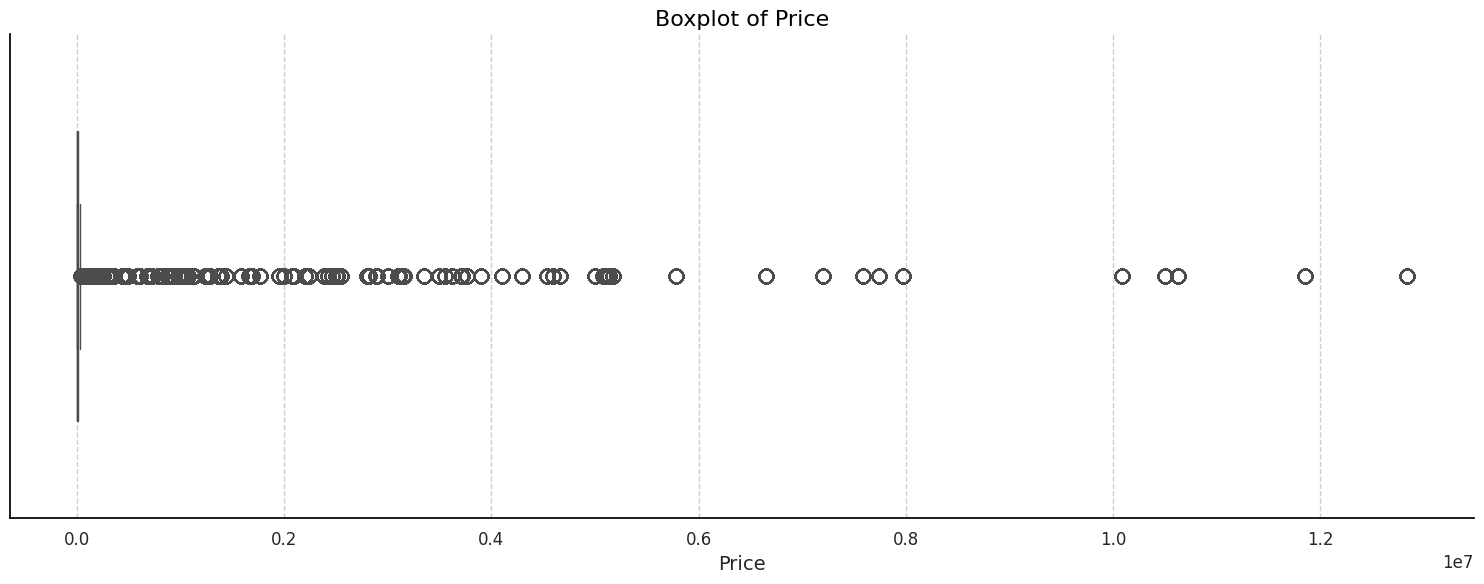

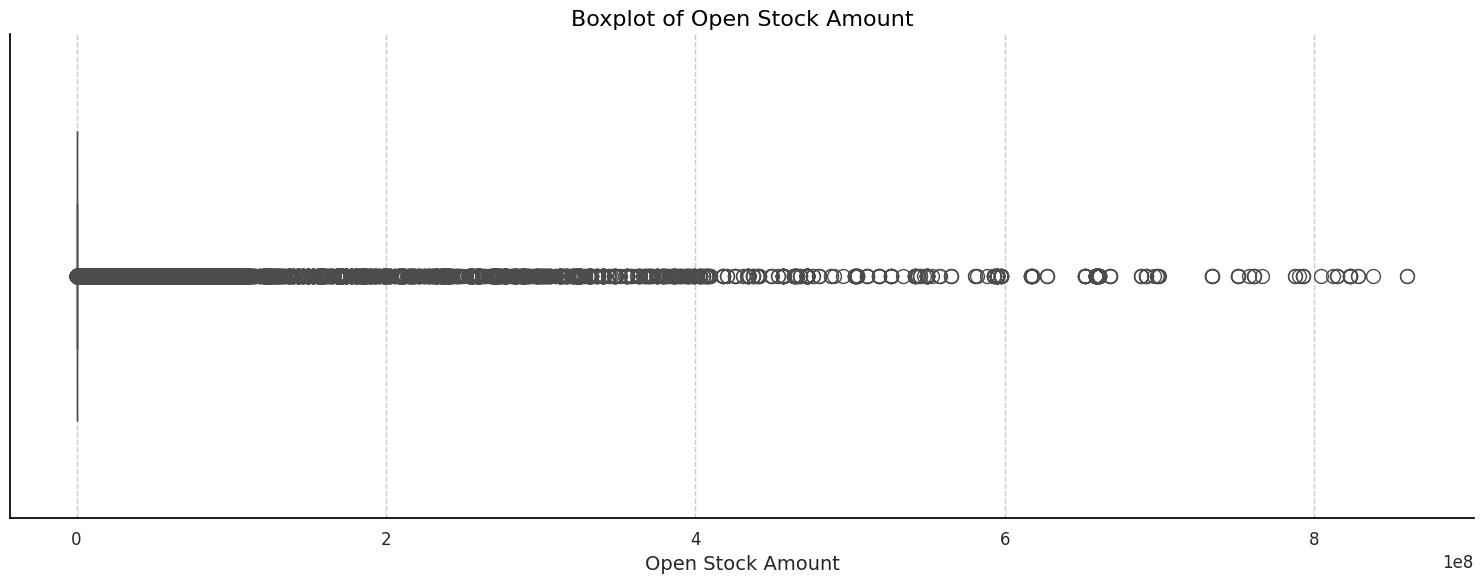

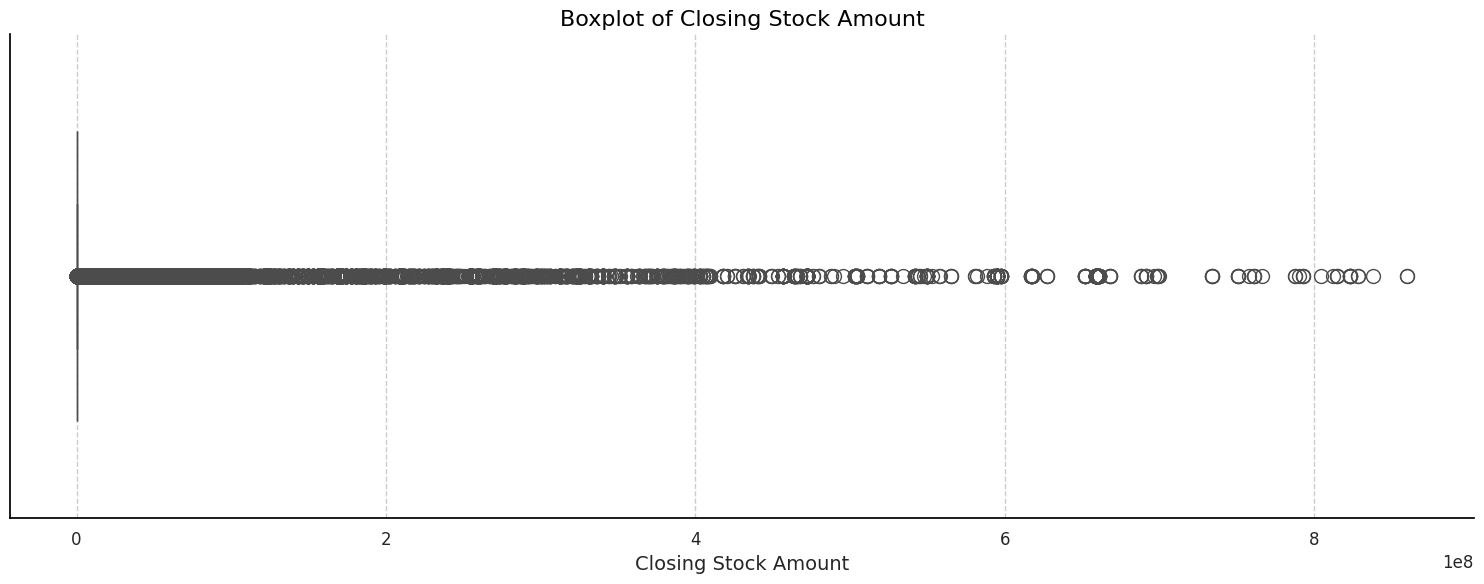

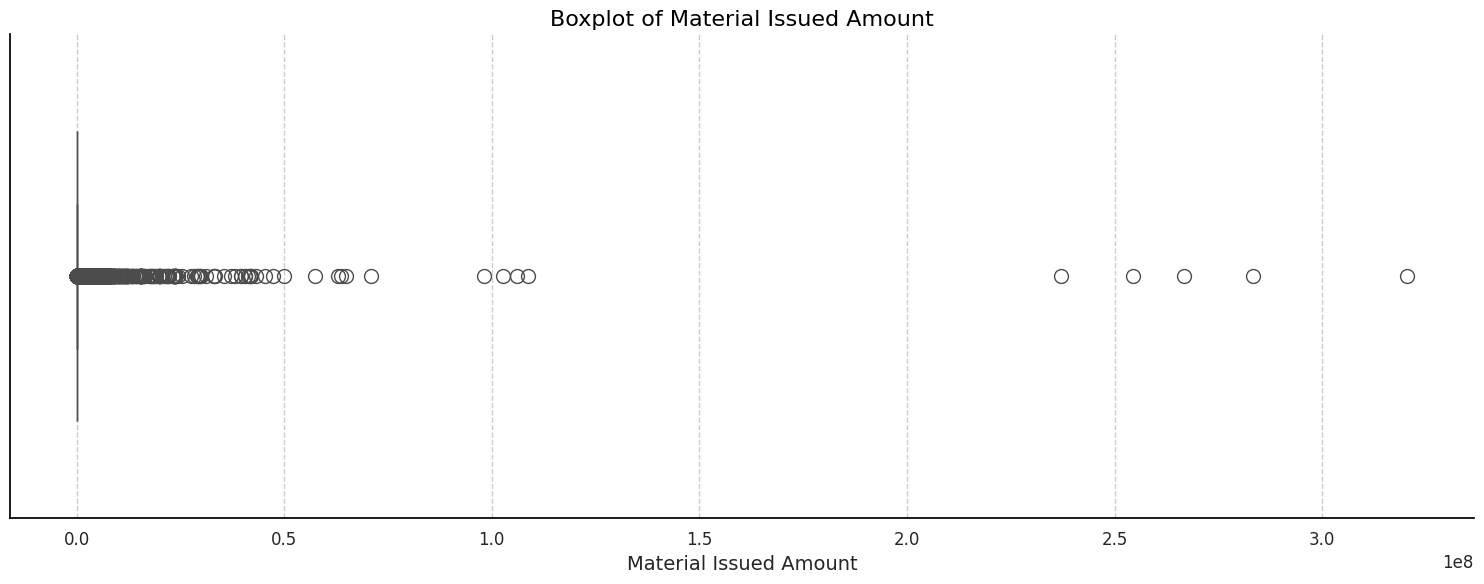

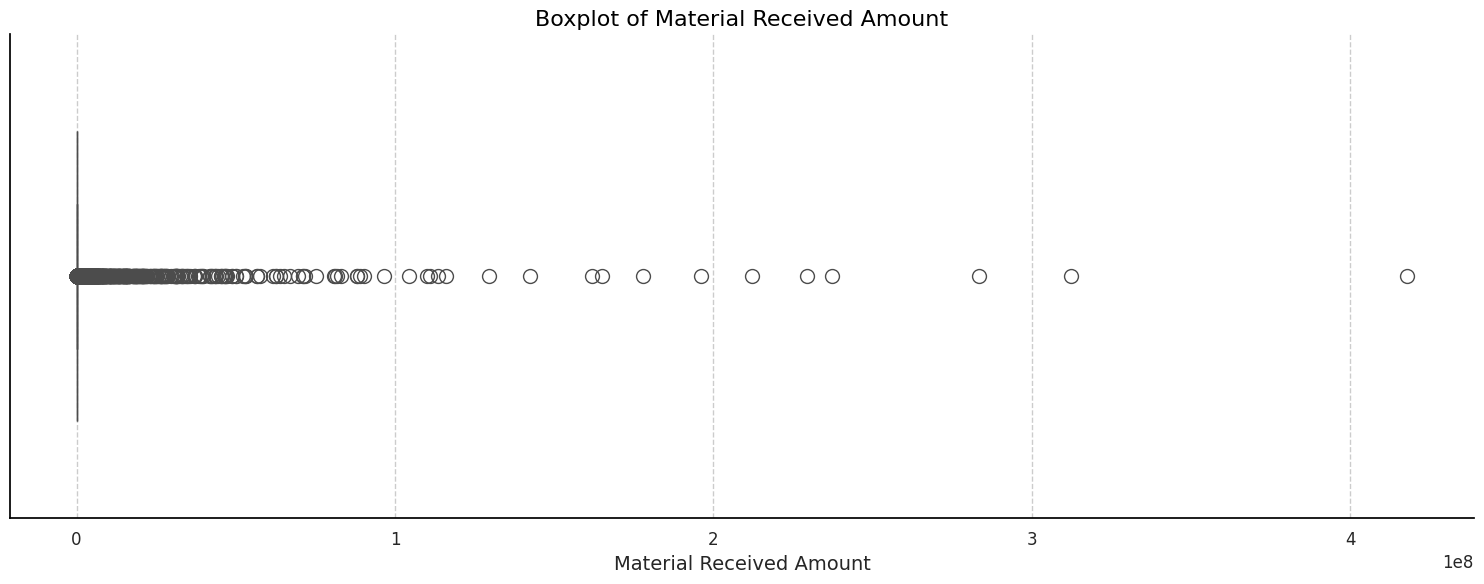

In [63]:
# Box plots for outlier detection using seaborn
for column in numerical_columns:
    sns.boxplot(x=data[data['Type']=='Material'][column], width=0.6)
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.tight_layout()
    plt.savefig(f'../results/eda/{column}_Boxplot.png')
    plt.show()

Unit
EA     853
M       92
KG      44
PAA     31
SET     13
L       10
M3       2
FT       1
PAC      1
Name: Material Code, dtype: int64

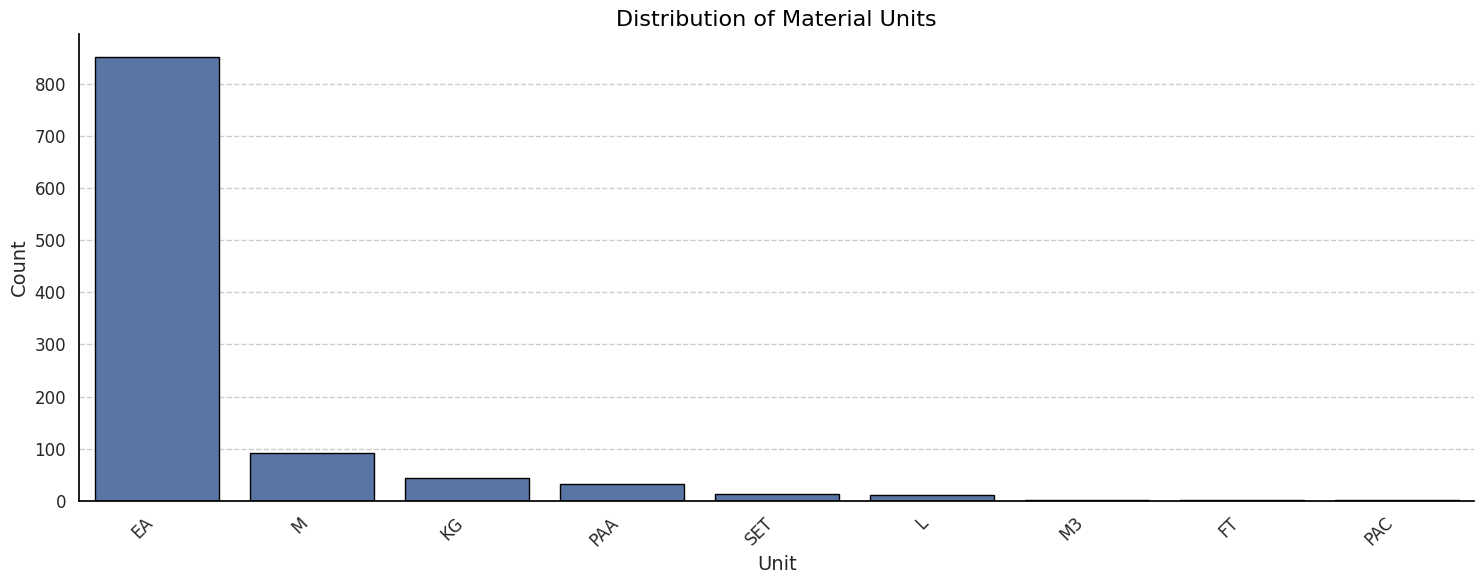

In [64]:
# Plot Distribution of Material Units
plot_grouped_data(
    data=data,
    group_by_column='Unit',
    count_column='Material Code',
    title="Distribution of Material Units",
    xlabel="Unit",
    ylabel="Count",
    save_path='../results/eda/unit_distribution.png'
)

Type
Material    934
Tools        66
Used         23
Scrap        15
Chemical      9
Name: Material Code, dtype: int64

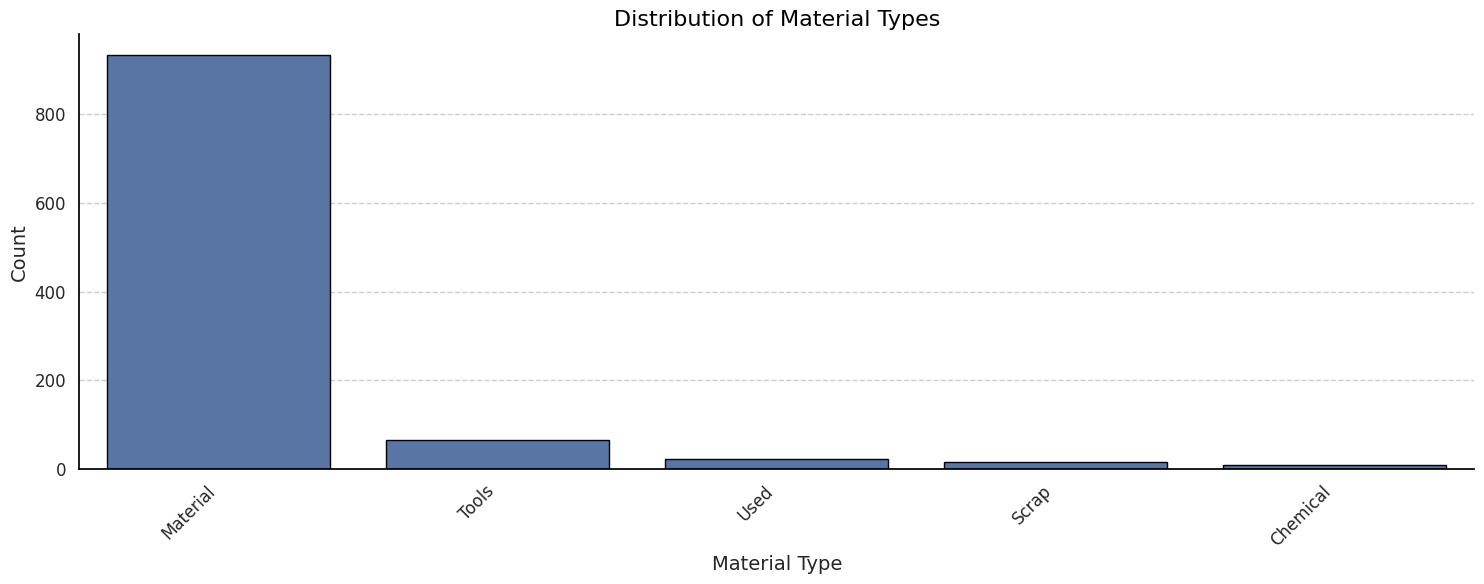

In [65]:
# Plot Distribution of Material Types
plot_grouped_data(
    data=data,
    group_by_column='Type',
    count_column='Material Code',
    title="Distribution of Material Types",
    xlabel="Material Type",
    ylabel="Count",
    save_path='../results/eda/type_distribution.png'
)

BFP
0    711
1    336
Name: Material Code, dtype: int64

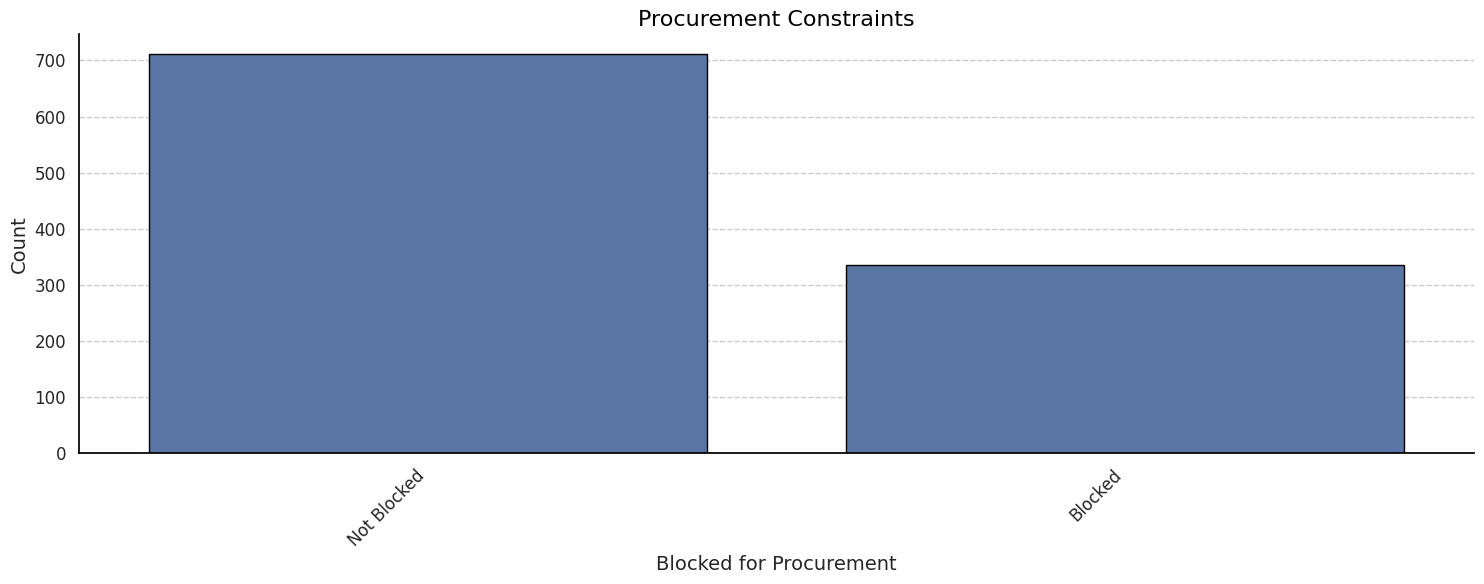

In [66]:
# Plot Procurement Constraints
plot_grouped_data(
    data=data,
    group_by_column='BFP',
    count_column='Material Code',
    title="Procurement Constraints",
    xlabel="Blocked for Procurement",
    ylabel="Count",
    save_path='../results/eda/bfp_analysis.png',
    is_xticks=True,
    xticks_labels=["Not Blocked", "Blocked"]
)

Type  Chemical  Material  Scrap  Tools  Used
BFP                                         
0          9.0     642.0   15.0   43.0   2.0
1          NaN     292.0    NaN   23.0  21.0

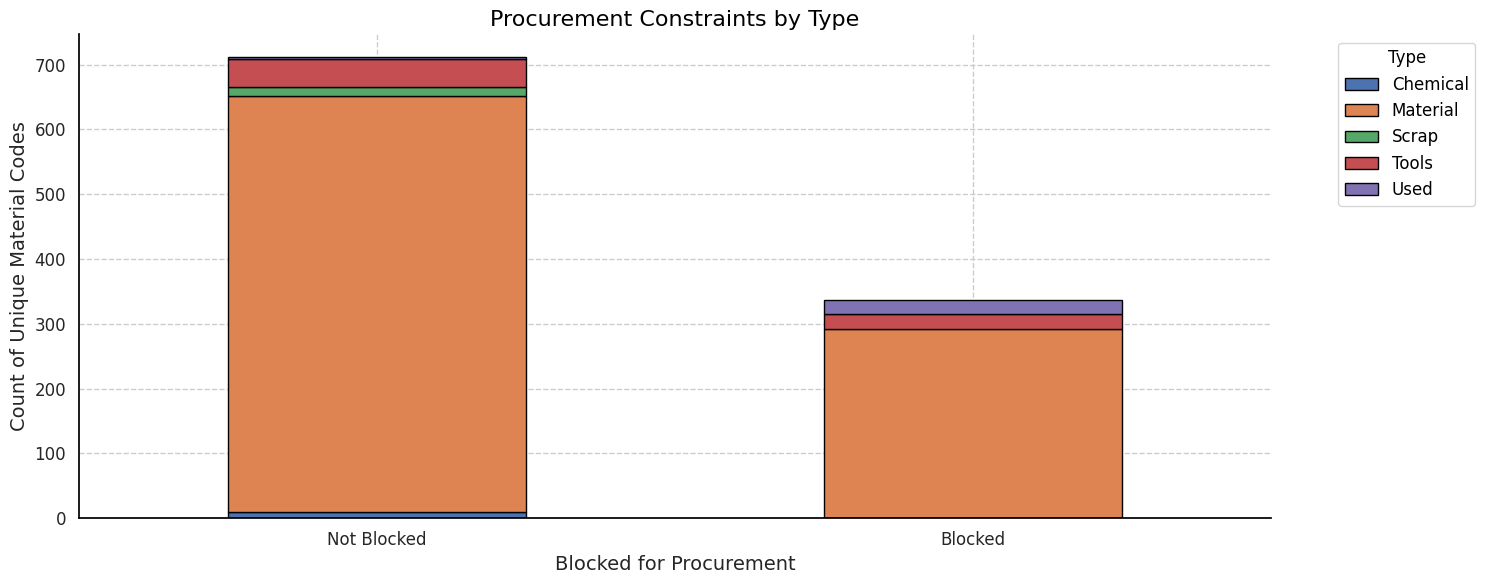

In [70]:
# Group by 'BFP' and 'Type' and count the unique 'Material Code' for each combination
grouped_data = data.groupby(['BFP', 'Type'])['Material Code'].nunique().reset_index()

# Pivot the data to prepare for stacked bar plotting
pivot_data = grouped_data.pivot(index='BFP', columns='Type', values='Material Code')

# Display the pivoted data
display(pivot_data)

# Plot the stacked bar chart using seaborn
pivot_data.plot(kind='bar', stacked=True)

# Add titles and labels
plt.title("Procurement Constraints by Type")
plt.xticks([0, 1], ["Not Blocked", "Blocked"], rotation=0)
plt.xlabel("Blocked for Procurement")
plt.ylabel("Count of Unique Material Codes")
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save and display the plot
plt.tight_layout()
plt.savefig('../results/eda/bfp_type_analysis.png')
plt.show()

### Lead Time Analysis
Lead time analyis without data filteration

In [71]:
print(f'Average Lead Time {data["PDT"].mean(): 0.2f} days')
print(f'Average Lead Time with [BFP == 0] {data[data["BFP"] == 0]["PDT"].mean(): 0.2f} days')
print(f'Average Lead Time with [BFP == 1] {data[data["BFP"] == 1]["PDT"].mean(): 0.2f} days')

Average Lead Time  86.89 days
Average Lead Time with [BFP == 0]  92.52 days
Average Lead Time with [BFP == 1]  74.96 days


In [72]:
# Summary statistics of lead time by Type
lead_time_grouped = data[data['BFP'] == 0].groupby('Material Code', as_index=False).agg({
    'PDT': 'mean', 'Type': 'first'
})

lead_time_summary_by_type = lead_time_grouped.groupby('Type')['PDT'].describe()
print("Summary Statistics of Lead Time (days) by Type:")
display(lead_time_summary_by_type)

Summary Statistics of Lead Time (days) by Type:


count        mean        std  min   25%   50%    75%    max
Type                                                                 
Chemical    9.0   63.333333  35.000000  0.0  60.0  60.0   90.0  120.0
Material  642.0   94.647975  51.527229  0.0  90.0  90.0  120.0  622.0
Scrap      15.0    0.000000   0.000000  0.0   0.0   0.0    0.0    0.0
Tools      43.0  103.488372  31.988370  0.0  90.0  90.0  120.0  150.0
Used        2.0    0.000000   0.000000  0.0   0.0   0.0    0.0    0.0

In [73]:
# Summary statistics of lead time by Type
lead_time_grouped = data[(data['BFP'] == 0) & (data['PDT'] > 0)].groupby('Material Code', as_index=False).agg({
    'PDT': 'mean', 'Type': 'first'
})

lead_time_summary_by_type = lead_time_grouped[lead_time_grouped['PDT'] > 0].groupby('Type')['PDT'].describe()
print("Summary Statistics of Lead Time by Type [BFP == 0] & [PDT > 0]:")
display(lead_time_summary_by_type)

Summary Statistics of Lead Time by Type [BFP == 0] & [PDT > 0]:


count        mean        std   min   25%    50%    75%    max
Type                                                                   
Chemical    8.0   71.250000  27.483761  30.0  60.0   60.0   90.0  120.0
Material  567.0  107.167549  40.777581  10.0  90.0  105.0  120.0  622.0
Tools      42.0  105.952381  27.942408  40.0  90.0  105.0  120.0  150.0

PDT
120    322
90     277
0      182
60      96
150     38
140     18
130     12
80      12
100     11
87      10
105      9
180      7
45       6
110      6
40       5
95       4
160      4
374      4
50       4
30       3
122      3
71       2
274      1
297      1
170      1
390      1
107      1
117      1
113      1
10       1
72       1
70       1
38       1
622      1
Name: Material Code, dtype: int64

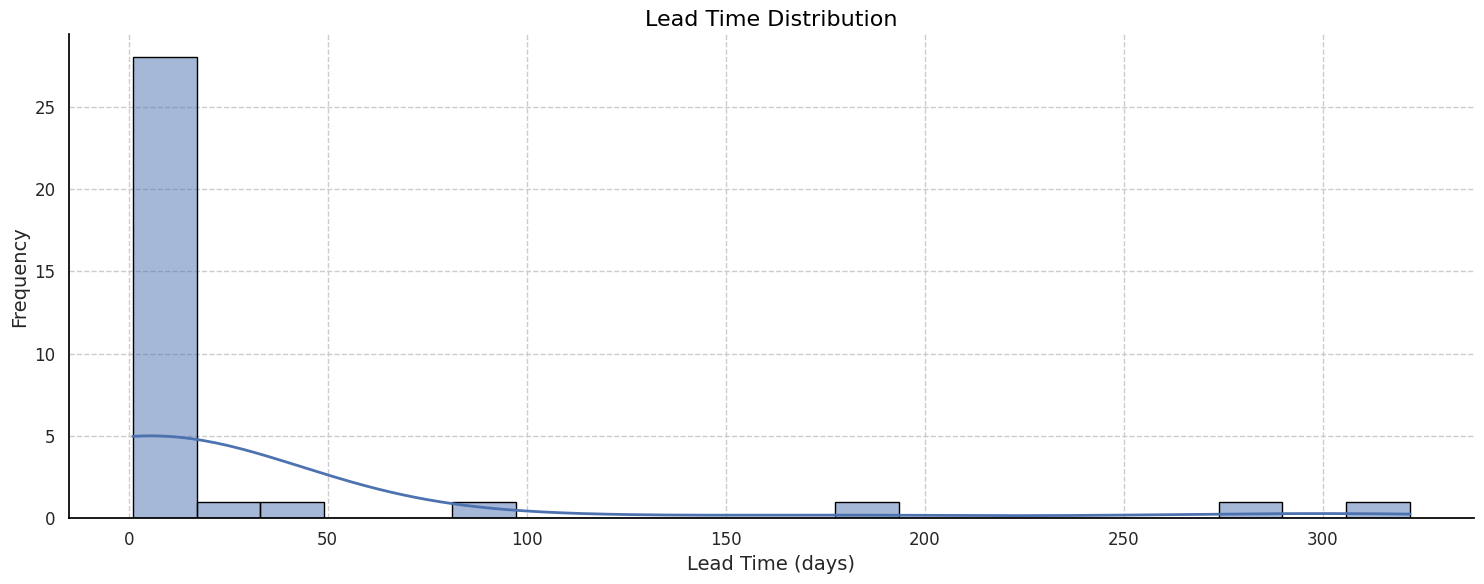

In [85]:
# 1. Lead Time Distribution
group_and_plot(
    data=data,
    group_by_column='PDT',
    count_column='Material Code',
    plot_type='hist',
    bins=20,
    kde=True,
    title='Lead Time Distribution',
    xlabel='Lead Time (days)',
    ylabel='Frequency',
    save_path='../results/eda/lead_time_distribution.png'
)

PDT
120    322
90     277
60      96
150     38
140     18
130     12
80      12
100     11
87      10
105      9
180      7
45       6
110      6
40       5
95       4
160      4
374      4
50       4
30       3
122      3
71       2
170      1
274      1
297      1
390      1
10       1
107      1
117      1
113      1
72       1
70       1
38       1
622      1
Name: Material Code, dtype: int64

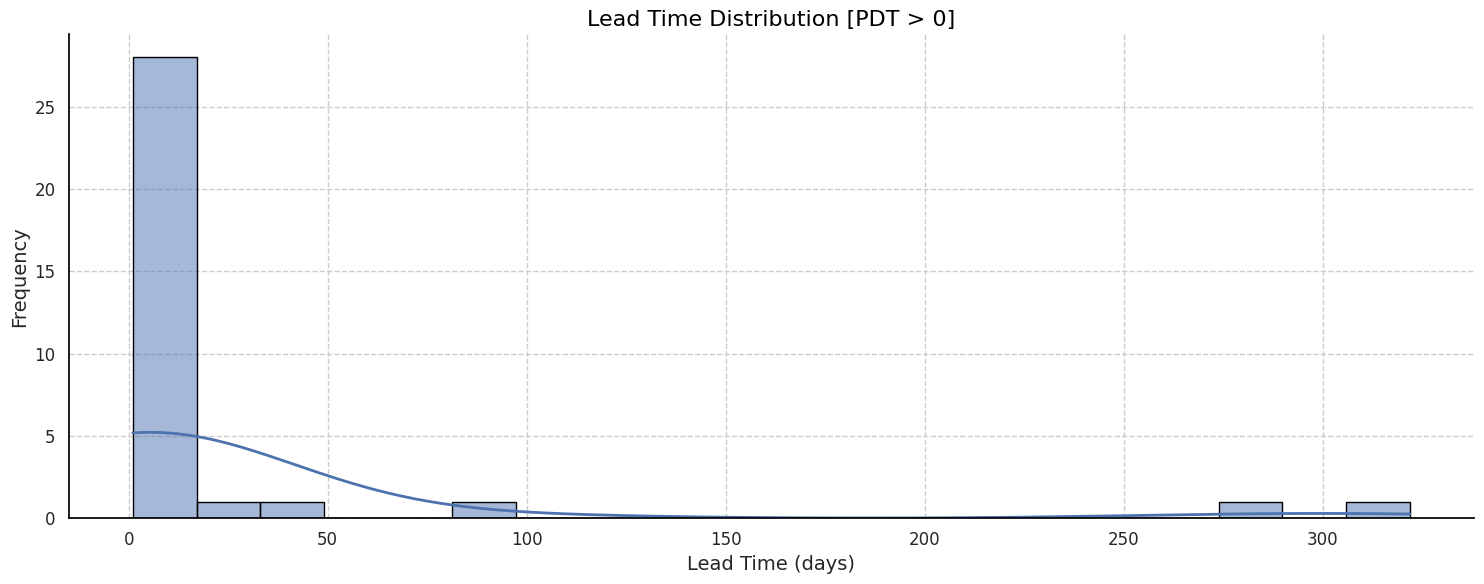

In [ ]:
# 2. Filtered Lead Time Distribution (PDT > 0)
filtered_data = data[data['PDT'] > 0]
group_and_plot(
    data=filtered_data,
    group_by_column='PDT',
    count_column='Material Code',
    plot_type='hist',
    bins=20,
    kde=True,
    title='Lead Time Distribution [PDT > 0]',
    xlabel='Lead Time (days)',
    ylabel='Frequency',
    save_path='../results/eda/lead_time_distribution_filtered.png'
)

Average Lead Time: 86.89 days


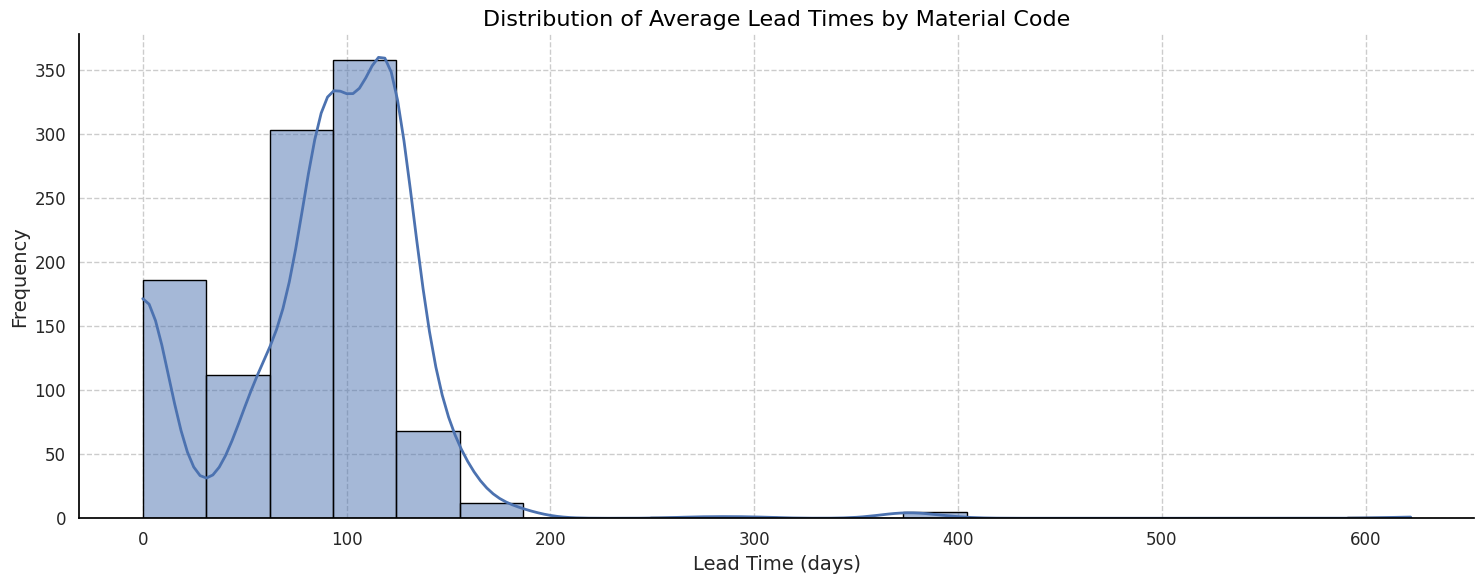

In [91]:
# 3. Average Lead Time Per Material
calculate_and_plot_average_lead_time(
    data=data,
    group_by_column='Material Code',
    agg_column='PDT',
    title="Distribution of Average Lead Times by Material Code",
    xlabel="Lead Time (days)",
    ylabel="Frequency",
    save_path='../results/eda/lead_time_distribution_material.png'
)

Average Lead Time: 105.17 days


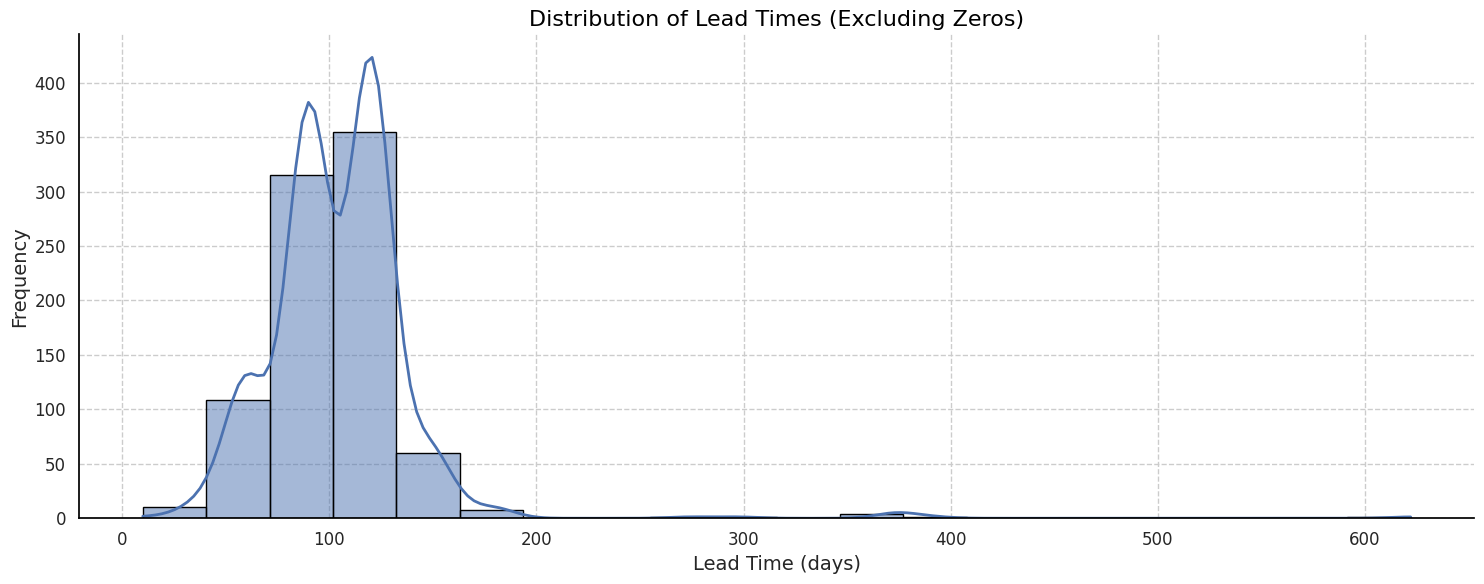

In [92]:
# 4. Filtered Average Lead Time (Excluding Zeros)
filtered_lead_time_data = data.groupby('Material Code', as_index=False).agg({'PDT': 'mean'})
filtered_lead_time_data = filtered_lead_time_data[filtered_lead_time_data['PDT'] > 0]
calculate_and_plot_average_lead_time(
    data=filtered_lead_time_data,
    group_by_column='Material Code',
    agg_column='PDT',
    title="Distribution of Lead Times (Excluding Zeros)",
    xlabel="Lead Time (days)",
    ylabel="Frequency",
    save_path='../results/eda/lead_time_distribution_material_filtered.png'
)


Average Lead Time: 92.52 days


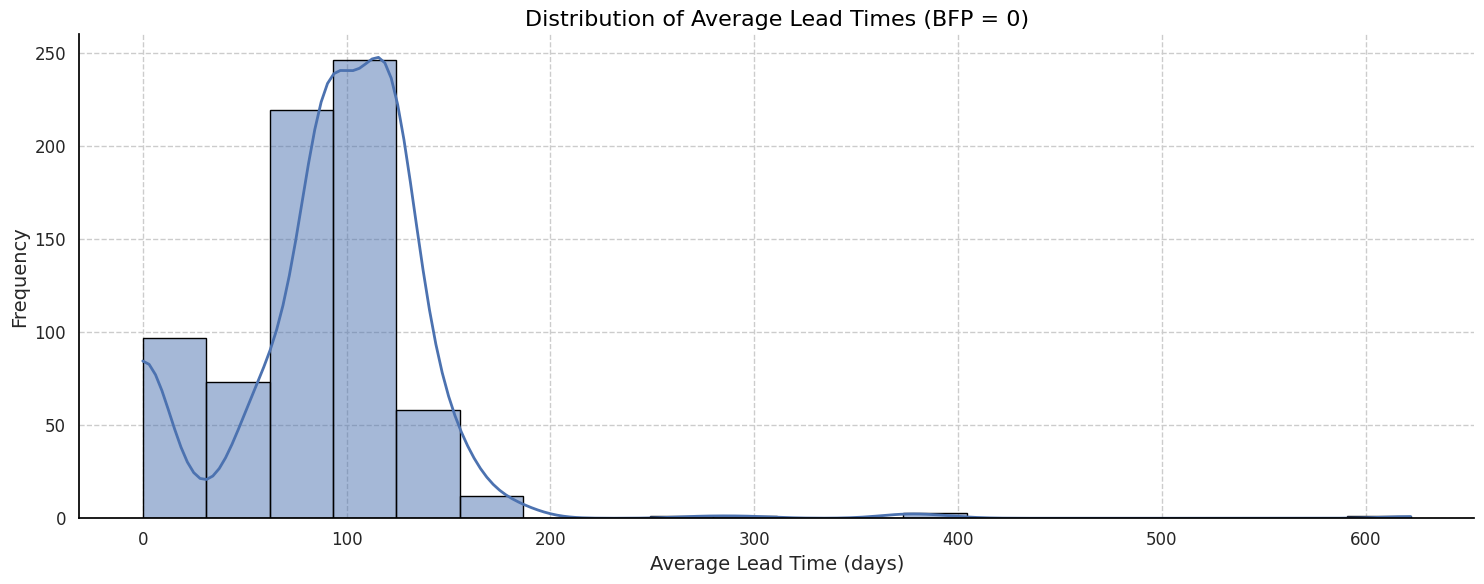

In [93]:
# 5. Average Lead Time for Non-Blocked Procurement (BFP = 0)
non_blocked_data = data[data['BFP'] == 0]
calculate_and_plot_average_lead_time(
    data=non_blocked_data,
    group_by_column='Material Code',
    agg_column='PDT',
    title="Distribution of Average Lead Times (BFP = 0)",
    xlabel="Average Lead Time (days)",
    ylabel="Frequency",
    save_path='../results/eda/lead_time_distribution_material_bfp.png'
)

## Material Issuance Over Time

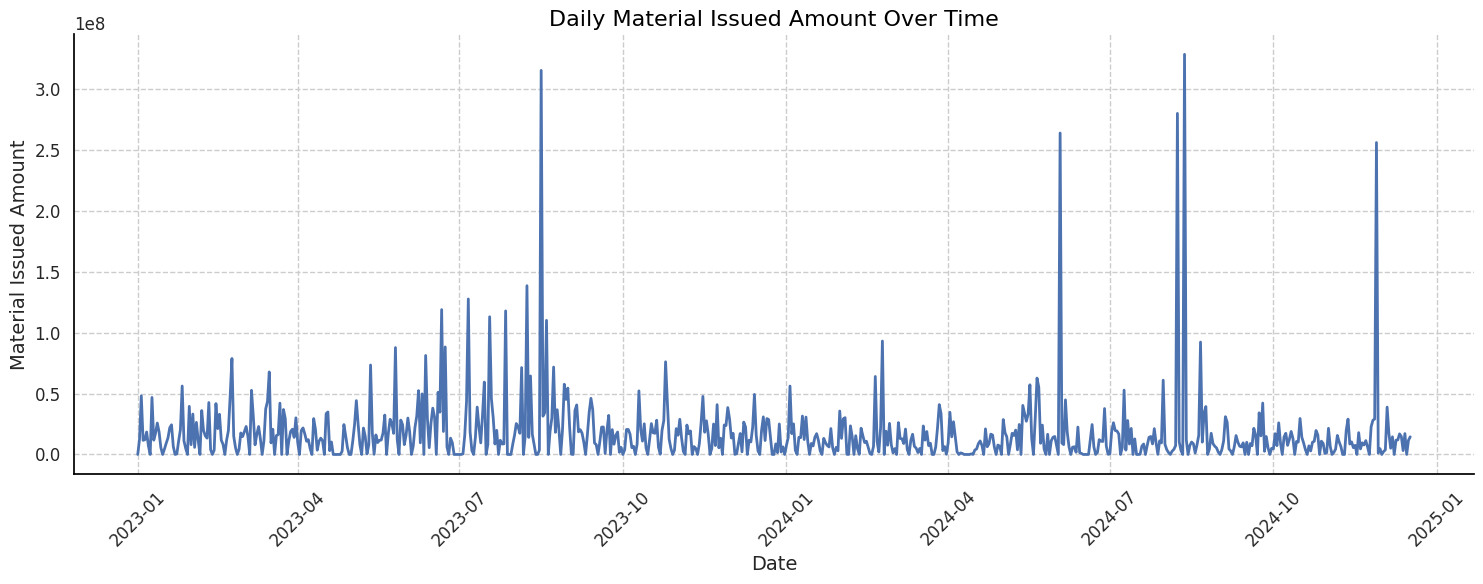

In [105]:
plot_daily_material_amount(data=data,
                                  column='Material Issued Amount',
                                  save_path='../results/eda/daily_material_issued_amount',
                                  title="Daily Material Issued Amount Over Time",
                                  y_label="Material Issued Amount")

**General Observations:**
* **Overall Trend:**
> * The plot shows daily fluctuations in the material issued amount over a period from January 2023 to January 2025.
> * There are noticeable peaks and troughs, indicating variability in the material issued amounts.

* **Seasonality and Periodicity:**
> * There appear to be periodic spikes in the material issued amount, suggesting potential seasonal or cyclical patterns in material issuance.
> * The peaks seem to occur at regular intervals, which could be indicative of monthly or quarterly cycles.

**Specific Observations:**
* **Early 2023:**
> * The material issued amount starts relatively low in January 2023.
> * There is a gradual increase in the material issued amount leading up to mid-2023.

* **Mid-2023 Peak:**
> * A significant peak is observed around July 2023, where the material issued amount reaches its highest value in the observed period.
> * This peak is followed by a sharp decline, indicating a sudden decrease in material issuance.

* **Late 2023 to Early 2024:**
> * After the mid-2023 peak, the material issued amount shows fluctuations with no clear trend, indicating variability in material issuance.
> * There are smaller peaks and troughs, suggesting periodic increases and decreases in material issuance.

* **Mid-2024 Peak:**
> * Another notable peak is observed around July 2024, similar to the peak in July 2023.
> * This peak is also followed by a sharp decline, indicating a similar pattern to the previous year.

* **Late 2024 to Early 2025:**
> * The material issued amount shows a declining trend towards the end of the period, with smaller peaks and troughs.
> *The amounts drop to lower values around January 2025.

**Interpretation:**

The plot provides a clear visual representation of how the material issued amount has changed on a daily basis over the specified period.

The significant peaks in July 2023 and July 2024 suggest seasonal or periodic increases in material issuance, which could be important for resource allocation and supply chain management.

The fluctuations indicate variability in material issuance, which could be due to various factors such as seasonal demand, supply chain issues, or business operations.

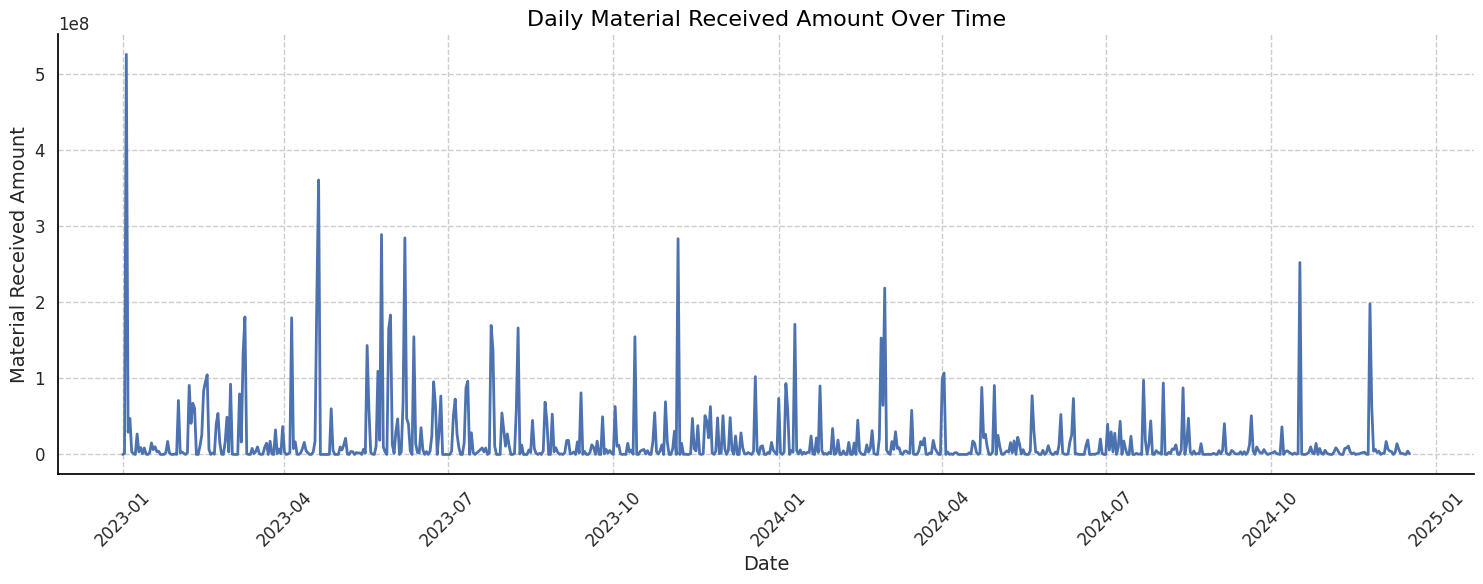

In [104]:
plot_daily_material_amount(data=data,
                                  column='Material Received Amount',
                                  save_path='../results/eda/daily_material_received_amount.png',
                                  title="Daily Material Received Amount Over Time",
                                  y_label="Material Received Amount")

**General Observations:**
* **Overall Trend:**
> * The plot shows daily fluctuations in the material received amount over a period from January 2023 to January 2025.
> * There are noticeable peaks and troughs, indicating variability in the material received amounts.

* **Seasonality and Periodicity:**
> * There appear to be periodic spikes in the material received amount, suggesting potential seasonal or cyclical patterns in material receipt.
> * The peaks seem to occur at regular intervals, which could be indicative of monthly or quarterly cycles.

**Specific Observations:**
* **Early 2023:**
> * The material received amount starts with a significant peak in January 2023, reaching the highest value in the observed period.
> * After the initial peak, there is a sharp decline, followed by smaller fluctuations.

* **Mid-2023:**
> * There are several smaller peaks and troughs throughout mid-2023, indicating variability in material receipt.
> * The material received amount shows a general decreasing trend after the initial peak, with occasional spikes.

* **Late 2023 to Early 2024:**
> * The material received amount continues to show fluctuations with no clear trend, indicating variability in material receipt.
> * There are smaller peaks and troughs, suggesting periodic increases and decreases in material receipt.

* **Mid-2024:**
> * Another notable peak is observed around mid-2024, similar to the peak in early 2023.
> * This peak is also followed by a sharp decline, indicating a similar pattern to the previous year.

* **Late 2024 to Early 2025:**
> * The material received amount shows a declining trend towards the end of the period, with smaller peaks and troughs.
> * The amounts drop to lower values around January 2025.

**Interpretation:**

The plot provides a clear visual representation of how the material received amount has changed on a daily basis over the specified period.

The significant peaks in early 2023 and mid-2024 suggest seasonal or periodic increases in material receipt, which could be important for resource allocation and supply chain management.

The fluctuations indicate variability in material receipt, which could be due to various factors such as seasonal demand, supply chain issues, or business operations.

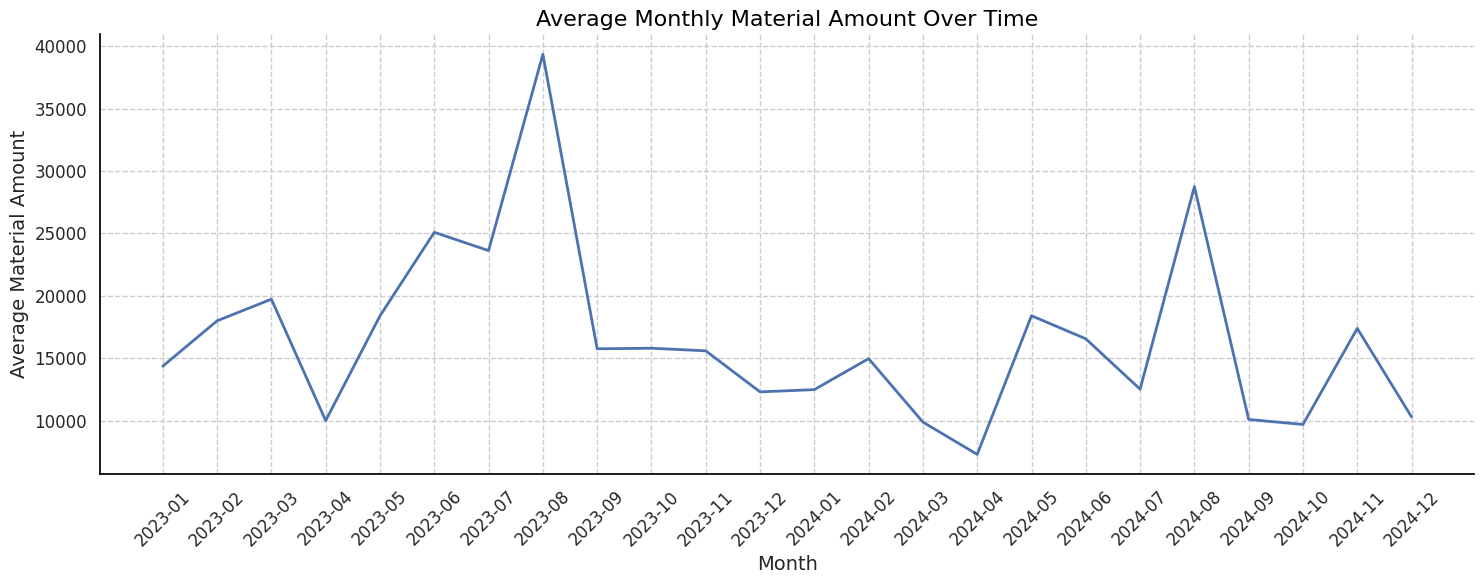

In [108]:
plot_average_monthly_amount(
    data=data,
    column='Material Issued Amount',
    save_path='../results/eda/average_monthly_material_amount.png',
    title='Average Monthly Material Amount Over Time',
    y_label='Average Material Amount'
)

**Overall Trend:**
> * The average monthly material issued amount shows significant fluctuations over the observed period.
> * There is no clear upward or downward trend; instead, the data exhibits periodic peaks and troughs.

**Peak Values:**
> * The highest peak occurs around July 2023, where the average material issued amount reaches approximately 38,000.
> * Another notable peak is observed around August 2024, with the amount reaching close to 28,000.

**Low Values:**
> * The lowest points are observed in March 2023 and March 2024, where the average material issued amount drops to around 10,000.
> * There are other troughs in September 2023 and January 2024, but they are not as low as the March values.

**Seasonality:**
> * There appears to be some seasonality in the data, with peaks occurring roughly every 6-8 months.
> * The data suggests that there might be cyclical patterns influencing the material issued amounts, possibly related to seasonal demand or operational cycles.

**Variability:**
> * The variability in the data is high, with significant differences between peak and trough values.
> * This high variability could indicate external factors influencing the material issued amounts, such as changes in production schedules, market demand, or supply chain disruptions.

**Recent Trends:**
> * Towards the end of the observed period (late 2024), the average material issued amount shows a slight upward trend, suggesting a potential increase in demand or production.

**Potential Anomalies:**
> * The sharp peak in July 2023 and the subsequent drop might indicate an anomaly or a special event that caused an unusually high material issued amount.
> * Similarly, the peak in August 2024 could be another anomaly or a result of a specific event.

**Consistency:**
> * Despite the fluctuations, the data shows some consistency in the cyclical pattern, which could be useful for forecasting future material issued amounts.

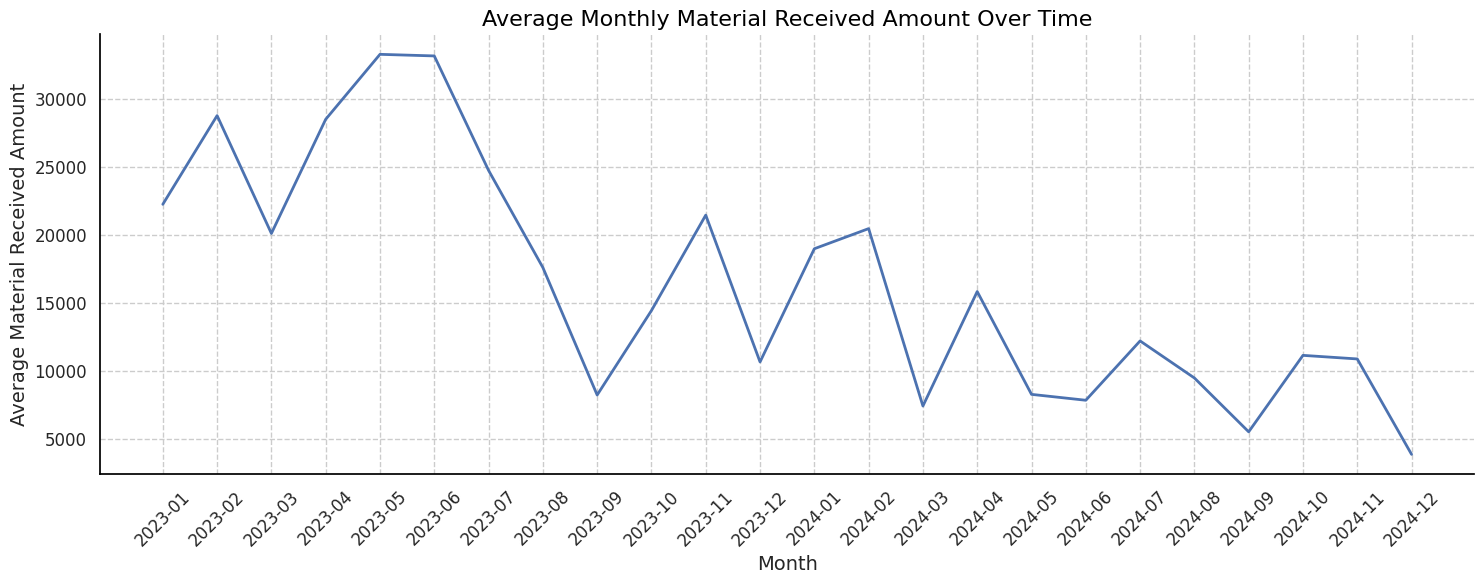

In [109]:
plot_average_monthly_amount(
    data=data,
    column='Material Received Amount',
    save_path='../results/eda/average_monthly_received_amount.png',
    title='Average Monthly Material Received Amount Over Time',
    y_label='Average Material Received Amount'
)

**Overall Trend:**
> * The average monthly material received amount shows significant fluctuations over the observed period.
> * There is a general downward trend in the material received amounts from early 2023 to late 2024.

**Peak Values:**
> * The highest peak occurs around May 2023, where the average material received amount reaches approximately 32,000.
> * Another notable peak is observed around October 2023, with the amount reaching close to 22,000.

**Low Values:**
> * The lowest point is observed in December 2024, where the average material received amount drops to around 5,000.
> * Other troughs are observed in August 2023 and March 2024, but they are not as low as the December 2024 value.

**Seasonality:**
> * There appears to be some seasonality in the data, with peaks and troughs occurring at roughly regular intervals.
> * The data suggests that there might be cyclical patterns influencing the material received amounts, possibly related to seasonal demand or operational cycles.

**Variability:**
> * The variability in the data is high, with significant differences between peak and trough values.
> * This high variability could indicate external factors influencing the material received amounts, such as changes in supply chain dynamics, market demand, or production schedules.

**Recent Trends:**
> * Towards the end of the observed period (late 2024), the average material received amount shows a slight upward trend after hitting the lowest point in December 2024, suggesting a potential recovery or increase in supply.

**Potential Anomalies:**
> * The sharp peak in May 2023 and the subsequent drop might indicate an anomaly or a special event that caused an unusually high material received amount.
> * Similarly, the peak in October 2023 could be another anomaly or a result of a specific event.

**Consistency:**
> * Despite the fluctuations, the data shows some consistency in the cyclical pattern, which could be useful for forecasting future material received amounts.

**Comparison with Material Issued:**
> * Comparing this chart with the "Average Monthly Material Issued Amount Over Time" chart, it appears that the material received amounts generally lag behind the material issued amounts. This could indicate a delay in the supply chain or inventory management processes.
> * The peaks and troughs in the material received amounts often follow the peaks and troughs in the material issued amounts, suggesting a correlation between the two metrics.

## Outliers

In [110]:
# Calculate and count outliers for each numerical column
for column in numerical_columns:
    Q1 = data[column].quantile(0.25)  # First quartile
    Q3 = data[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    outlier_count = data[(data[column] < Q1 - 1.5 * IQR) | (data[column] > Q3 + 1.5 * IQR)].shape[0]  # Count of outliers
    print(f"Number of outliers in {column}: {outlier_count}")

Number of outliers in Open Stock: 149072
Number of outliers in Material Issued: 34742
Number of outliers in Material Received: 6968
Number of outliers in Closing Stock: 149023
Number of outliers in PDT: 5736
Number of outliers in BFP: 0
Number of outliers in Price: 139098
Number of outliers in Open Stock Amount: 154172
Number of outliers in Closing Stock Amount: 154147
Number of outliers in Material Issued Amount: 34742
Number of outliers in Material Received Amount: 6968


## Top 10 Most Issued & Received Material

In [111]:
# Aggregating top 10 materials by issuance
top_issued = data.groupby('Material Code')['Material Issued'].sum().sort_values(ascending=False).head(10)

# Aggregating top 10 materials by receipt
top_received = data.groupby('Material Code')['Material Received'].sum().sort_values(ascending=False).head(10)

# Convert to DataFrame for better readability
top_issued_df = top_issued.reset_index().rename(columns={'Material Issued': 'Total Issued'})
top_received_df = top_received.reset_index().rename(columns={'Material Received': 'Total Received'})

print("Top 10 Issued Materials:")
display(top_issued_df)

print("\nTop 10 Received Materials:")
display(top_received_df)

Top 10 Issued Materials:


Material Code  Total Issued
0      10025031   1662643.000
1      10002203    563113.622
2      10036545    448398.000
3      10098377    178575.000
4      10005075    175525.000
5      10102094    124262.000
6      10099475     82205.000
7      10025998     66642.000
8      10022563     56702.000
9      10025567     55435.000


Top 10 Received Materials:


Material Code  Total Received
0      10025031       1592935.0
1      10036545        454400.0
2      10002203        359329.0
3      10005075        180303.0
4      10098377        160848.0
5      10021177        138936.0
6      10102094        131268.0
7      10099475         97361.0
8      10025998         73883.0
9      10025567         65251.0

In [115]:
# Aggregating top 10 materials by issuance
top_issued_amt = data.groupby('Material Code').agg({'Material Issued Amount':'sum', 'Material Issued':'sum'}).sort_values('Material Issued Amount', ascending=False).head(10)

# Aggregating top 10 materials by receipt
top_received_amt = data.groupby('Material Code').agg({'Material Received Amount':'sum', 'Material Received':'sum'}).sort_values('Material Received Amount', ascending=False).head(10)

# Convert to DataFrame for better readability
top_issued_df_amt = top_issued_amt.reset_index().rename(columns={'Material Issued Amount': 'Total Issued Amount', 'Material Issued': 'Total Issued'})
top_received_df_amt = top_received_amt.reset_index().rename(columns={'Material Received Amount': 'Total Received Amount', 'Material Received': 'Total Received'})

print("Top 10 Issued Materials (Amount):")
display(top_issued_df_amt)

print("\nTop 10 Received Materials (Amount):")
display(top_received_df_amt)

Top 10 Issued Materials (Amount):


Material Code  Total Issued Amount  Total Issued
0      10098377         2.110989e+09      178575.0
1      10005075         1.740643e+09      175525.0
2      10119319         8.385167e+08         145.0
3      10000710         6.479821e+08         208.0
4      10000698         5.357156e+08         302.0
5      10098866         5.107729e+08          66.0
6      10094526         4.689978e+08        3921.0
7      10036234         4.217693e+08       20190.0
8      10098672         3.884815e+08         176.0
9      10005061         3.368771e+08       14806.0


Top 10 Received Materials (Amount):


Material Code  Total Received Amount  Total Received
0      10098377           1.901432e+09        160848.0
1      10005075           1.788025e+09        180303.0
2      10119319           8.385167e+08           145.0
3      10000710           7.196340e+08           231.0
4      10098866           6.732916e+08            87.0
5      10000698           5.481328e+08           309.0
6      10036234           4.889516e+08         23406.0
7      10094526           4.355065e+08          3641.0
8      10098672           4.127616e+08           187.0
9      10005061           3.152392e+08         13855.0

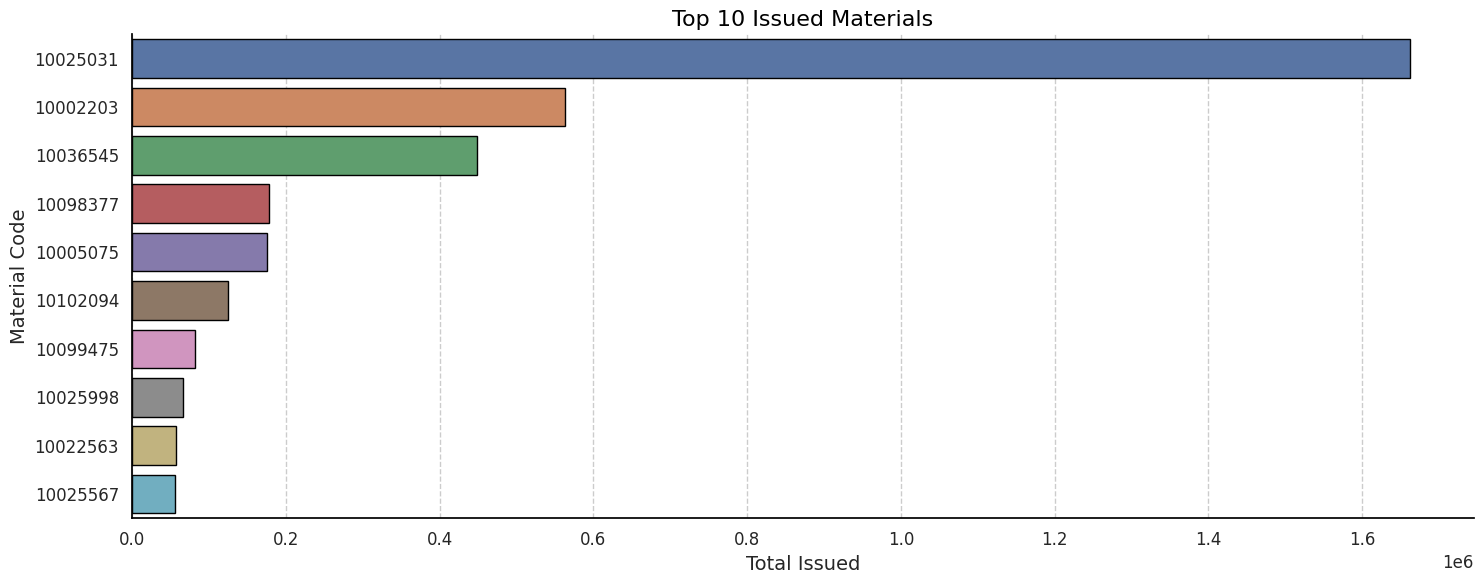

In [117]:
# Plotting top issued materials
sns.barplot(x='Total Issued', y='Material Code', data=top_issued_df, hue='Material Code')
plt.title('Top 10 Issued Materials')
plt.xlabel('Total Issued')
plt.ylabel('Material Code')
plt.savefig('../results/eda/top_issued_materials.png')
plt.show()

### Top 10 Average Issued Material

In [118]:
avg_issued = data.groupby('Material Code')['Material Issued'].mean().sort_values(ascending=False).head(10)
avg_issued_df = avg_issued.reset_index().rename(columns={'Material Issued': 'Average Issued'})
print("\nTop 10 Average Material Issued Over Date:")
avg_issued_df


Top 10 Average Material Issued Over Date:


Material Code  Average Issued
0      10025031     2318.888424
1      10002203      785.374647
2      10036545      625.380753
3      10098377      249.058577
4      10005075      244.804742
5      10102094      173.308229
6      10099475      114.651325
7      10025998       92.945607
8      10022563       79.082287
9      10025567       77.315202

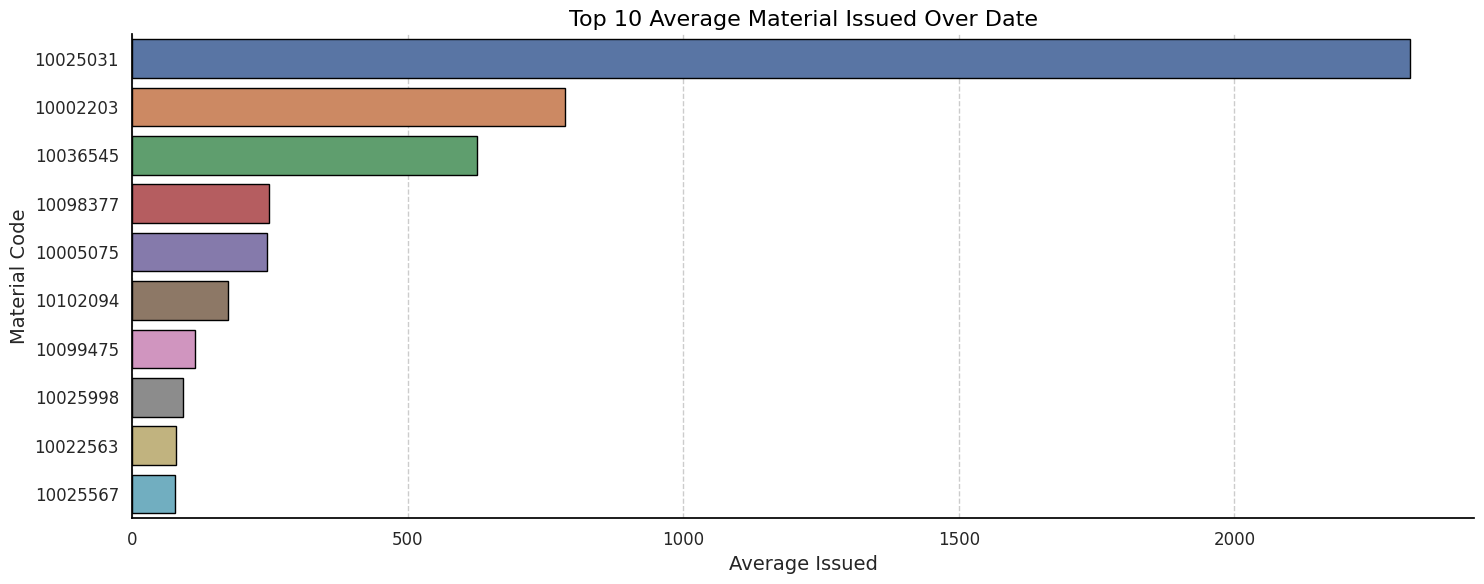

In [ ]:
sns.barplot(x='Average Issued', y='Material Code', data=avg_issued_df, hue='Material Code')
plt.title('Top 10 Average Material Issued Over Date')
plt.xlabel('Average Issued')
plt.ylabel('Material Code')
plt.savefig('../results/eda/top_average_issued_materials.png')
plt.show()

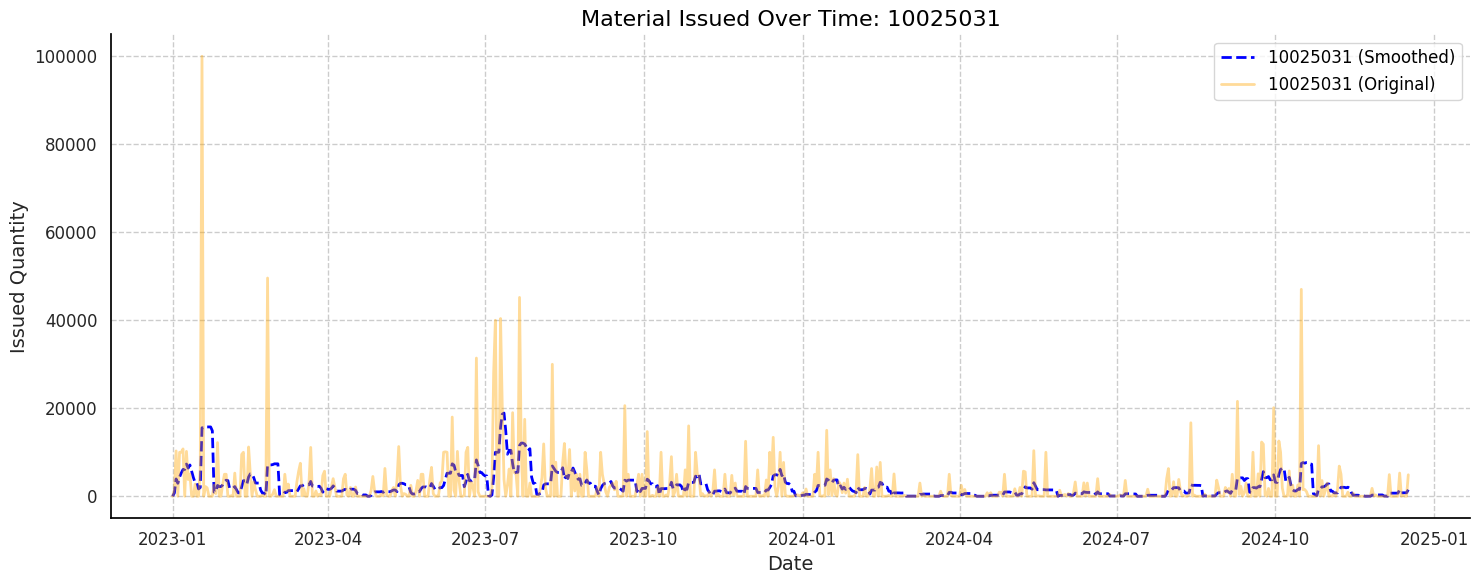

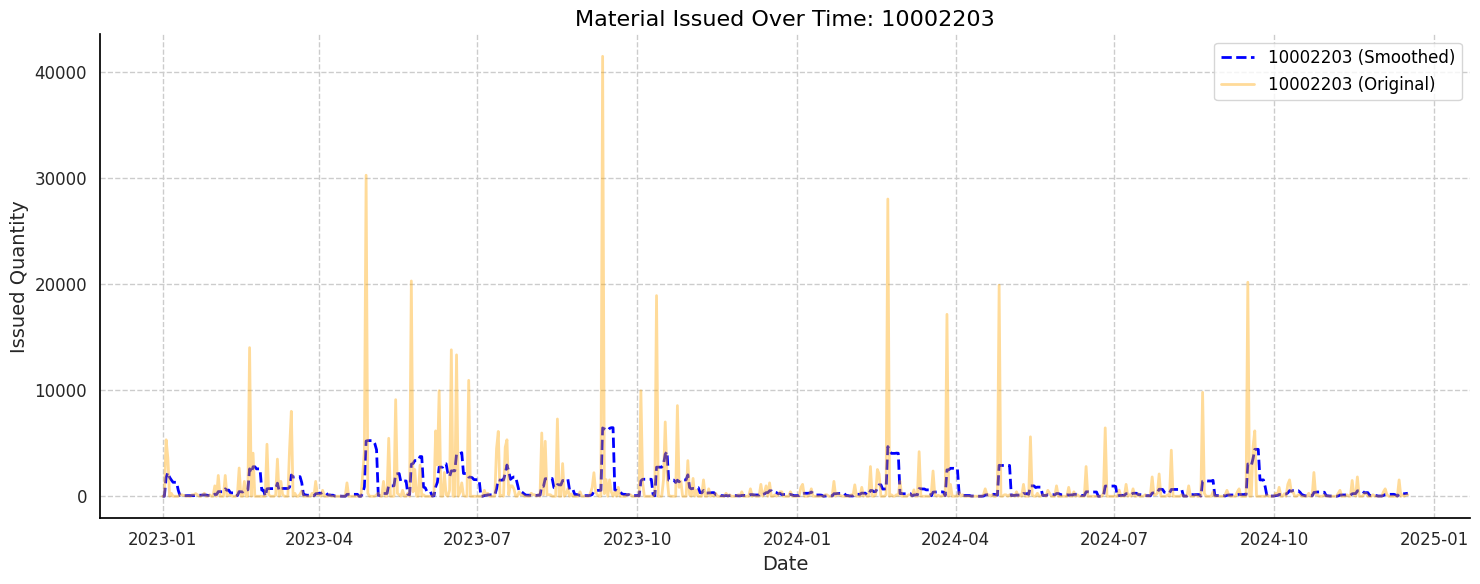

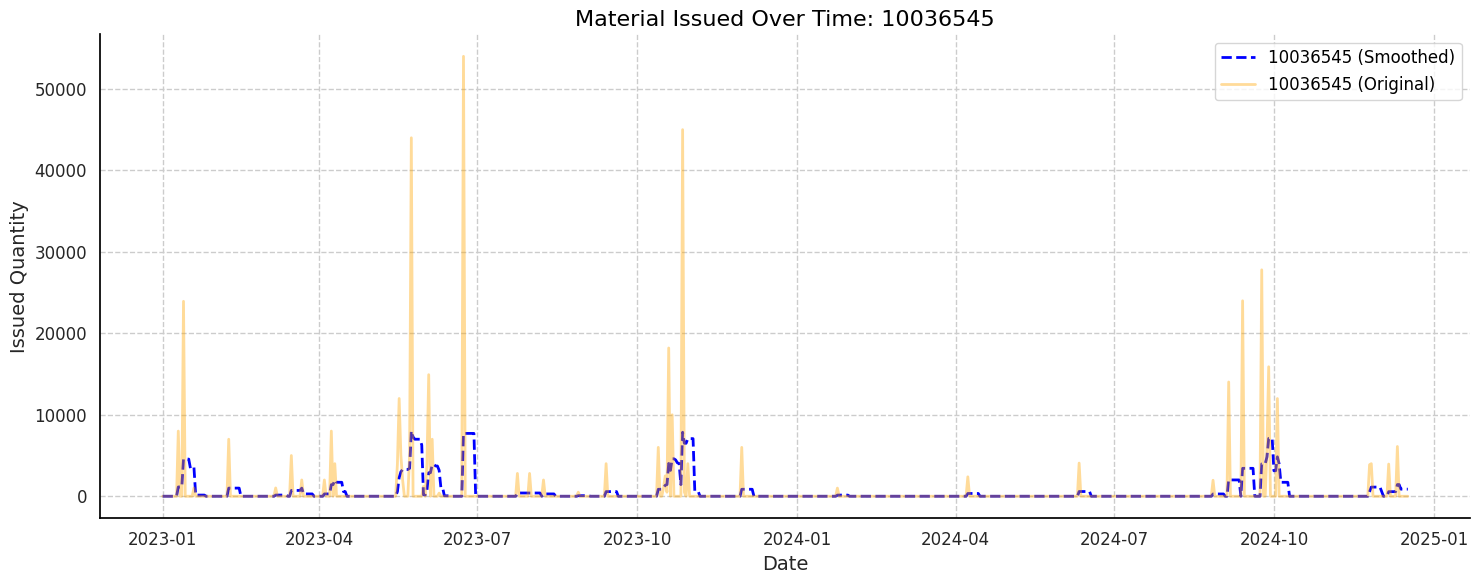

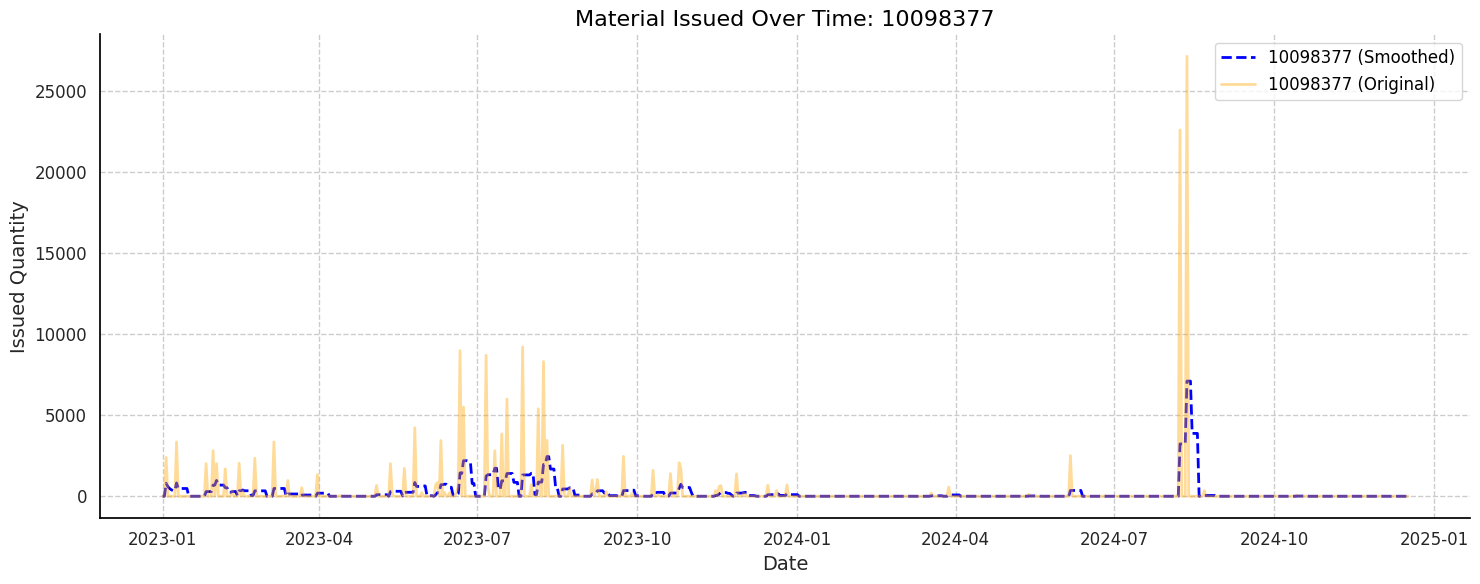

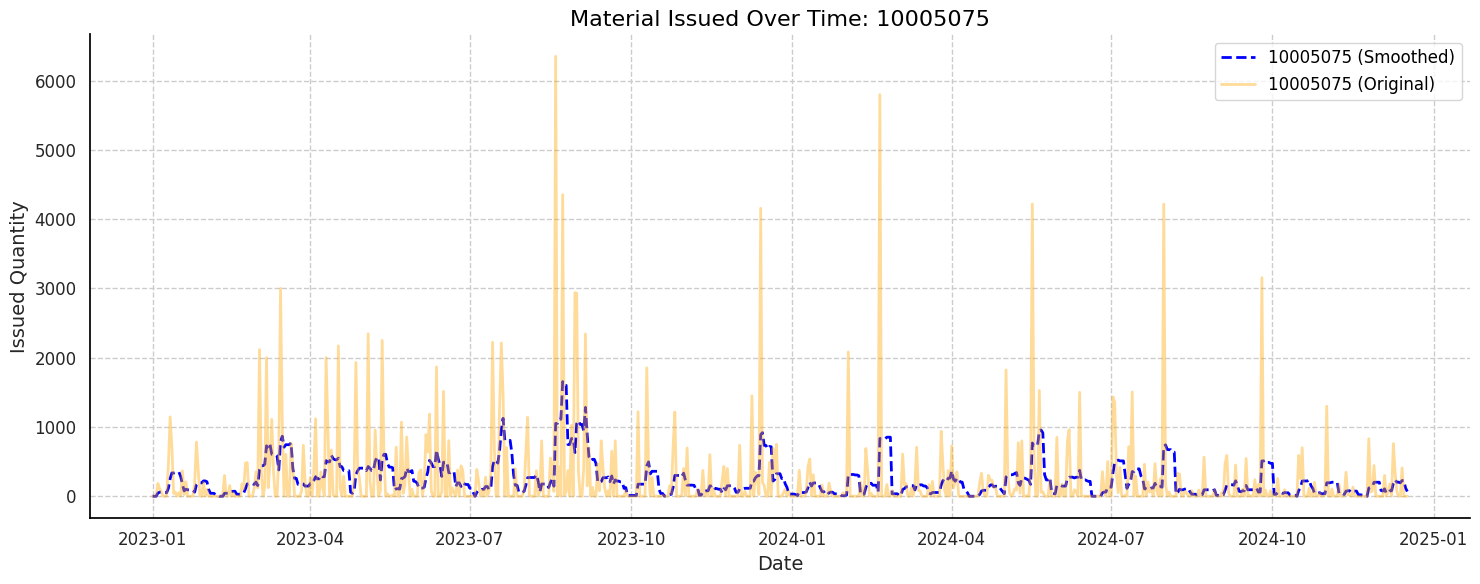

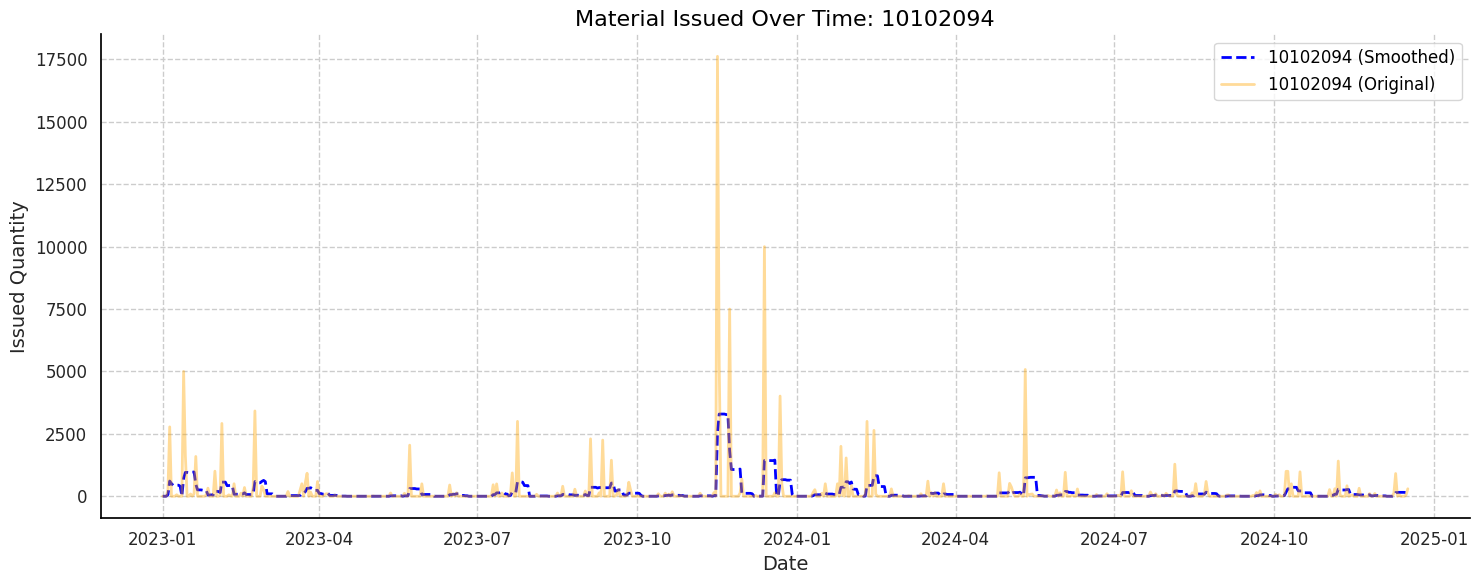

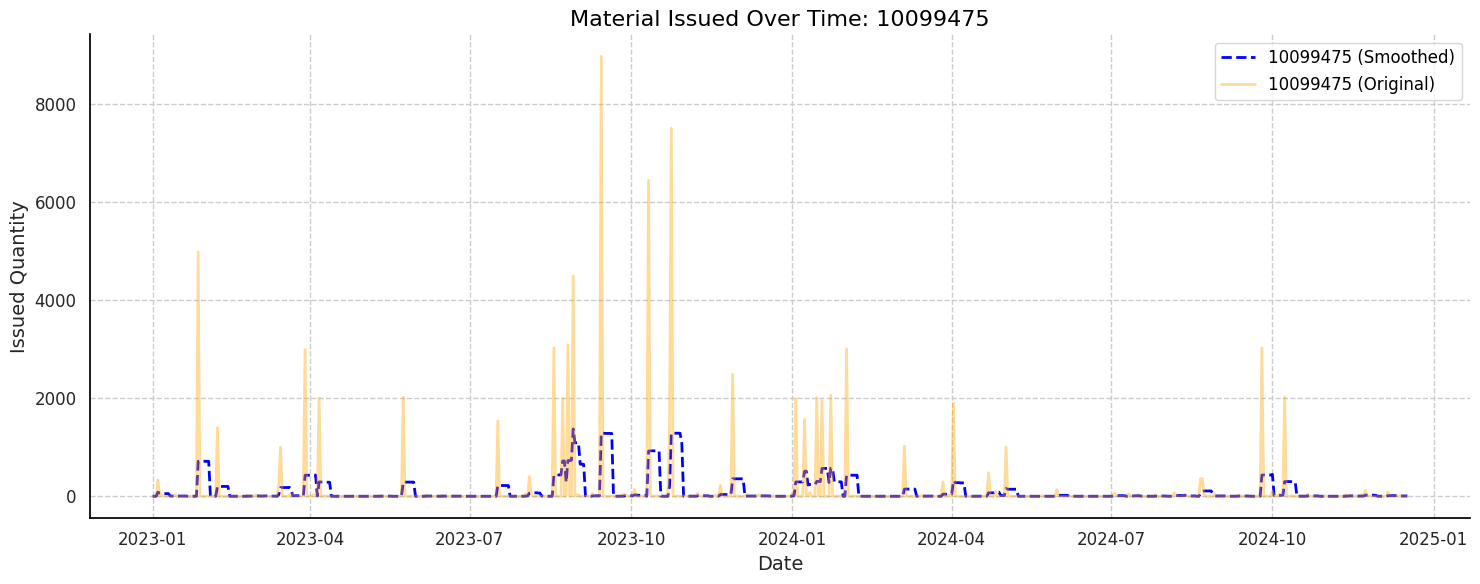

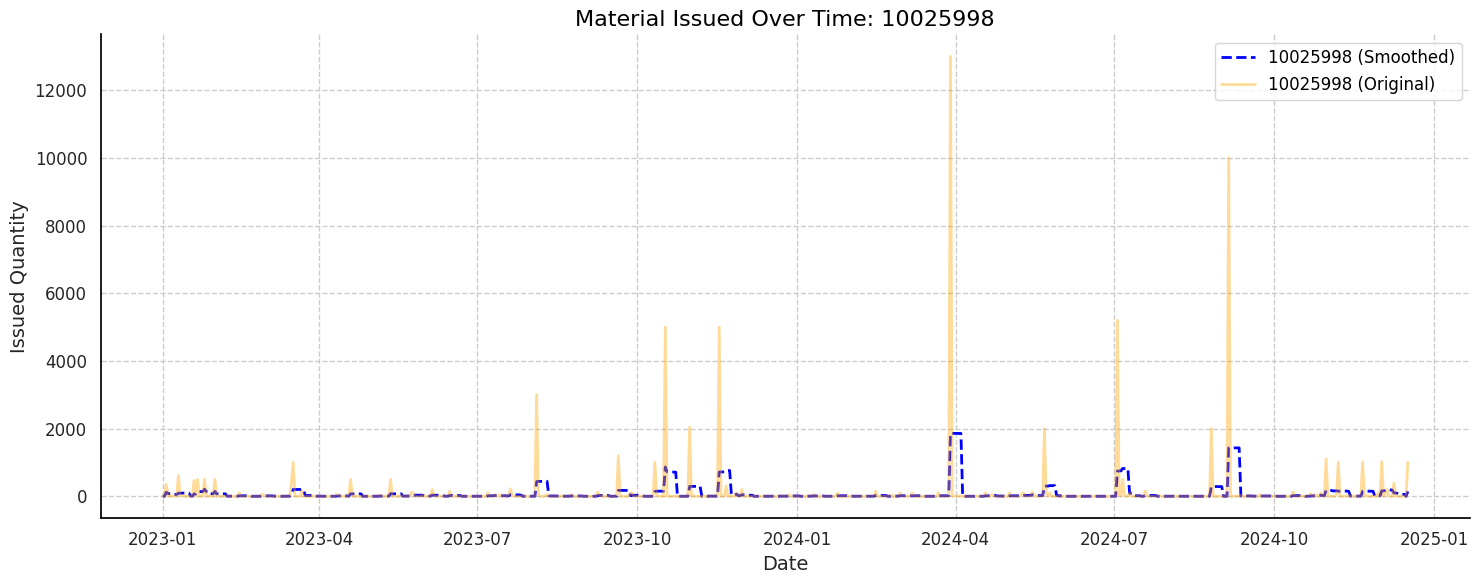

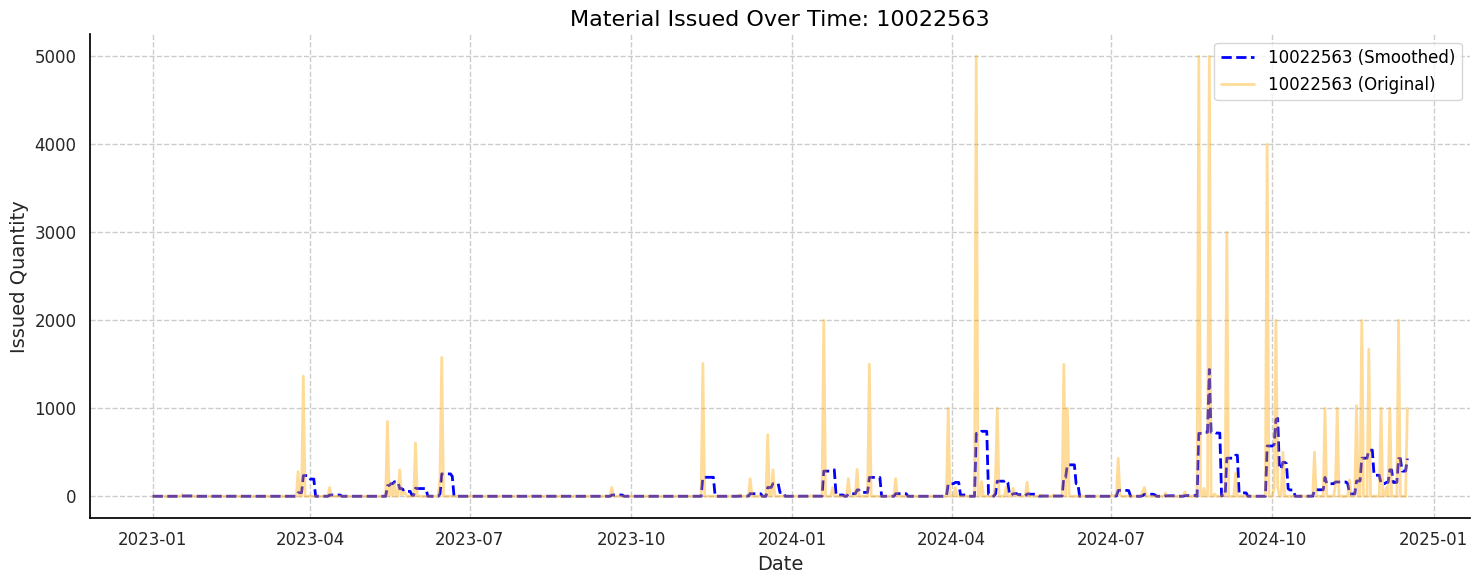

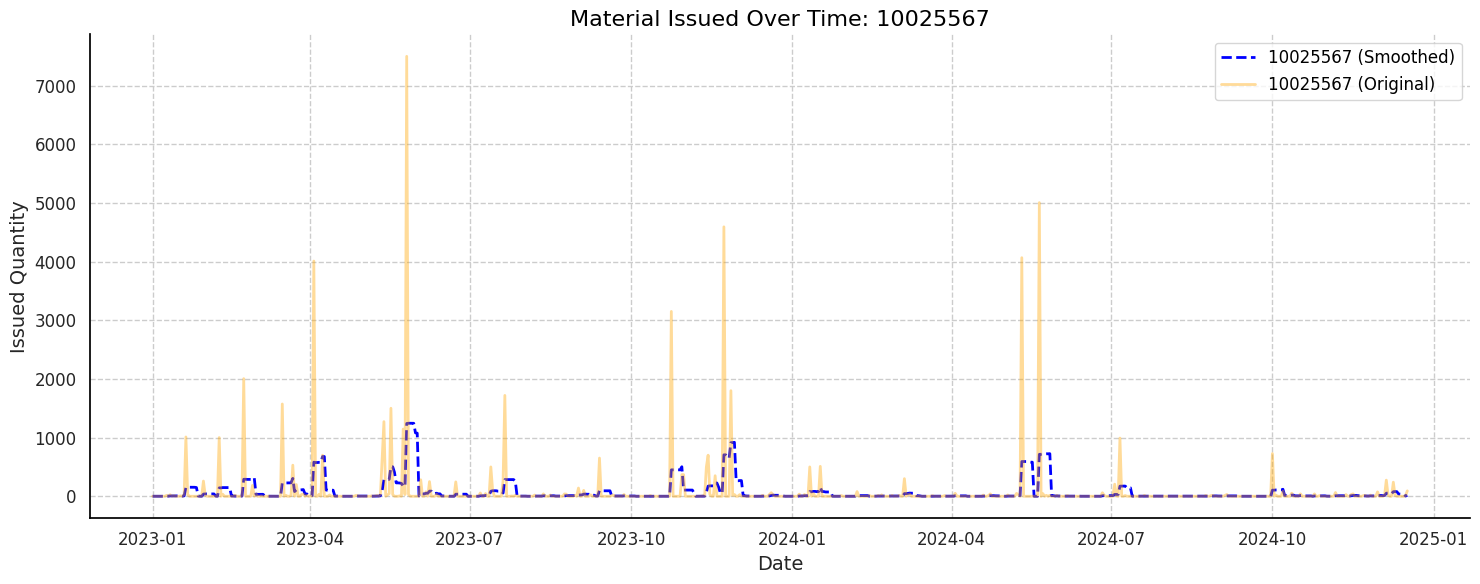

In [124]:
# Plotting for issued materials
plot_material_over_time(
    data=data,
    material_df=top_issued_df,
    value_column='Material Issued',
    smoothed_column='Smoothed_Issued',
    title_prefix='Material Issued',
    y_label='Issued Quantity',
    file_prefix='material_issued'
)

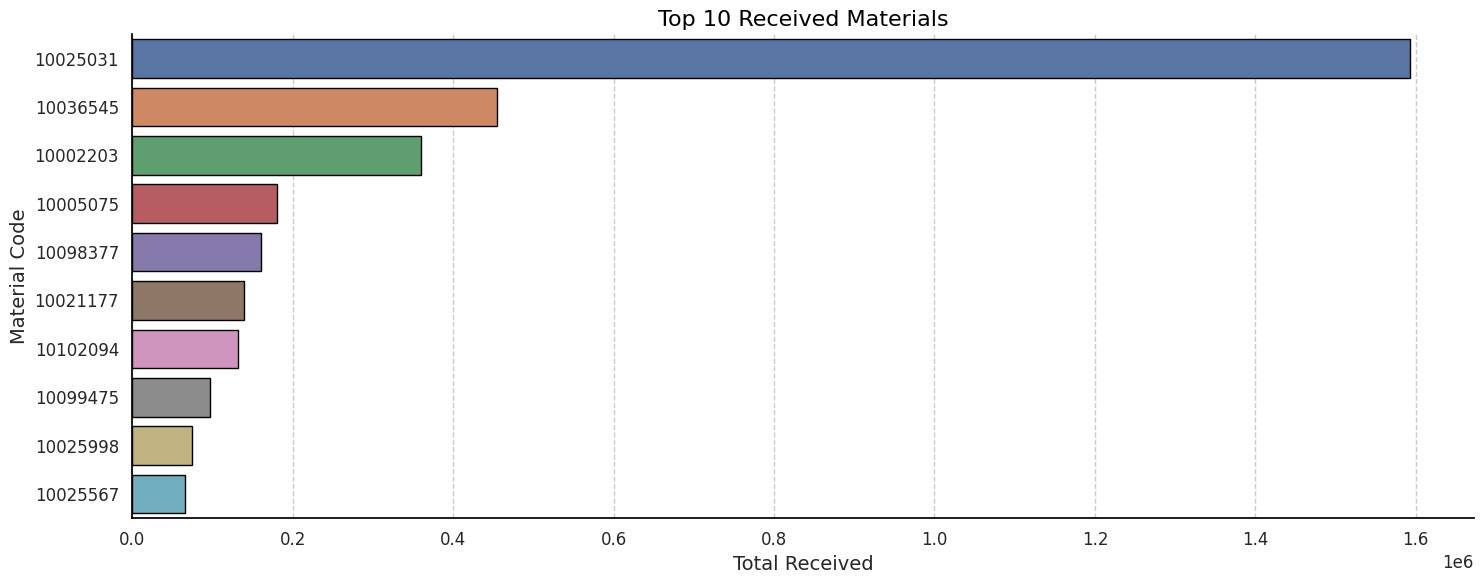

In [ ]:
sns.barplot(x='Total Received', y='Material Code', data=top_received_df, hue='Material Code')
plt.title('Top 10 Received Materials')
plt.xlabel('Total Received')
plt.ylabel('Material Code')
plt.savefig('../results/eda/top_received_materials.png')
plt.show()


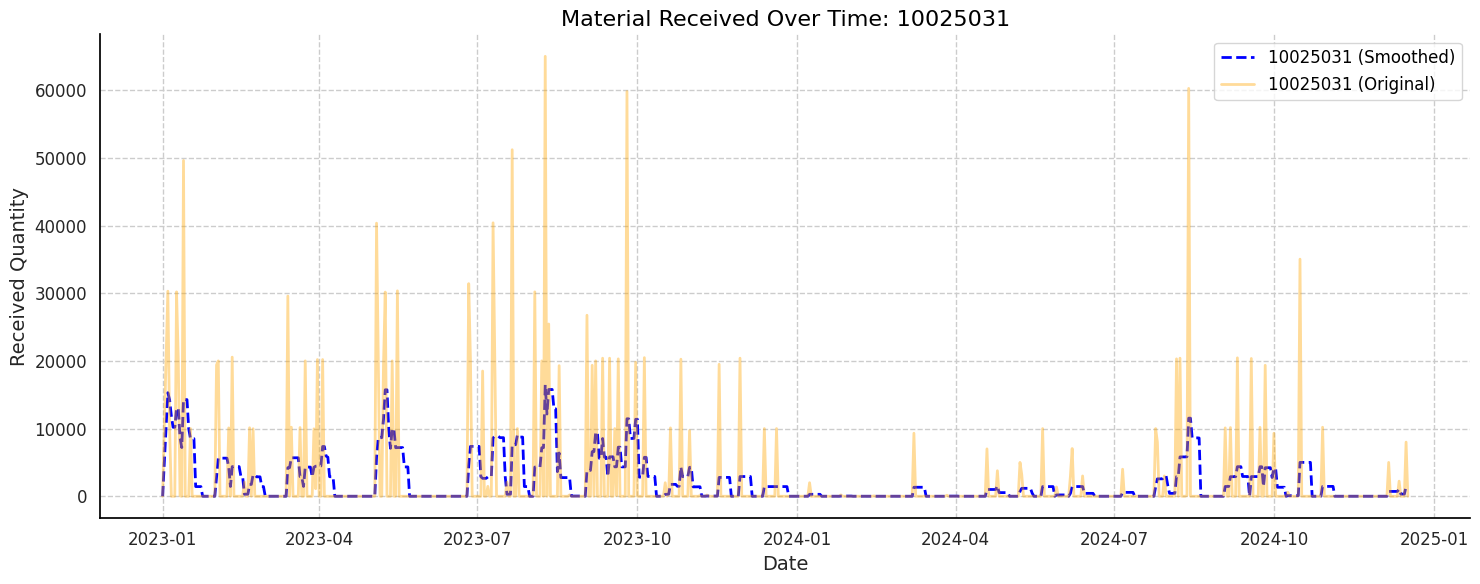

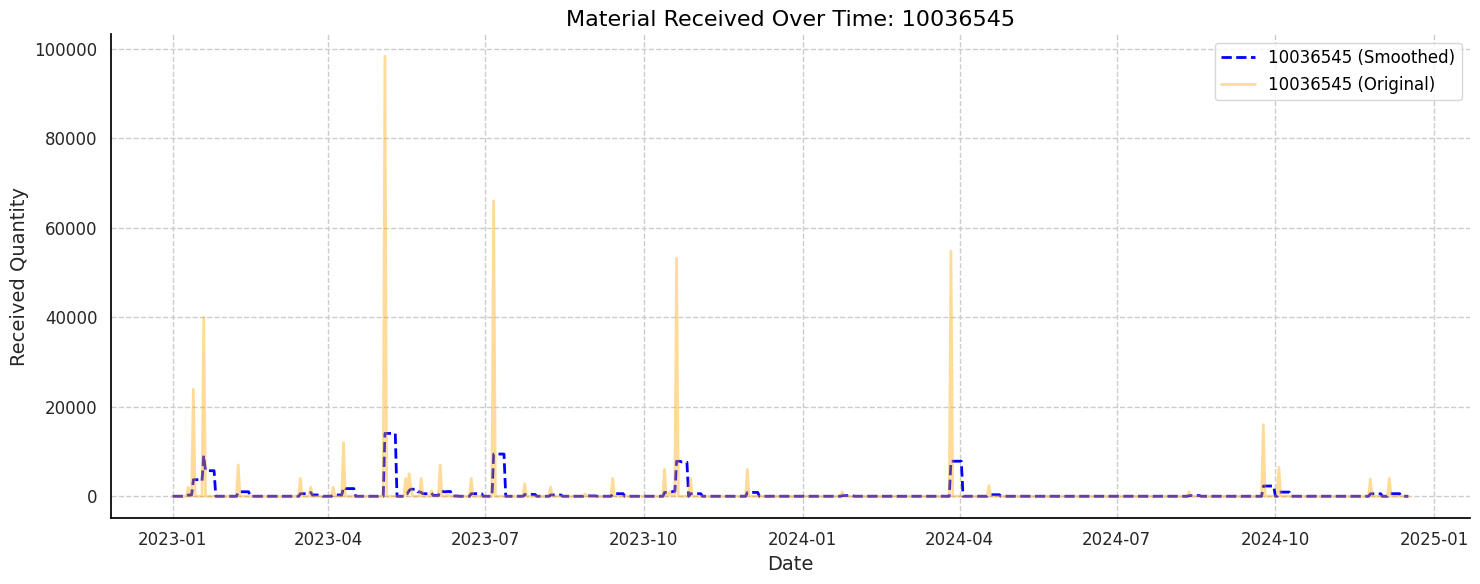

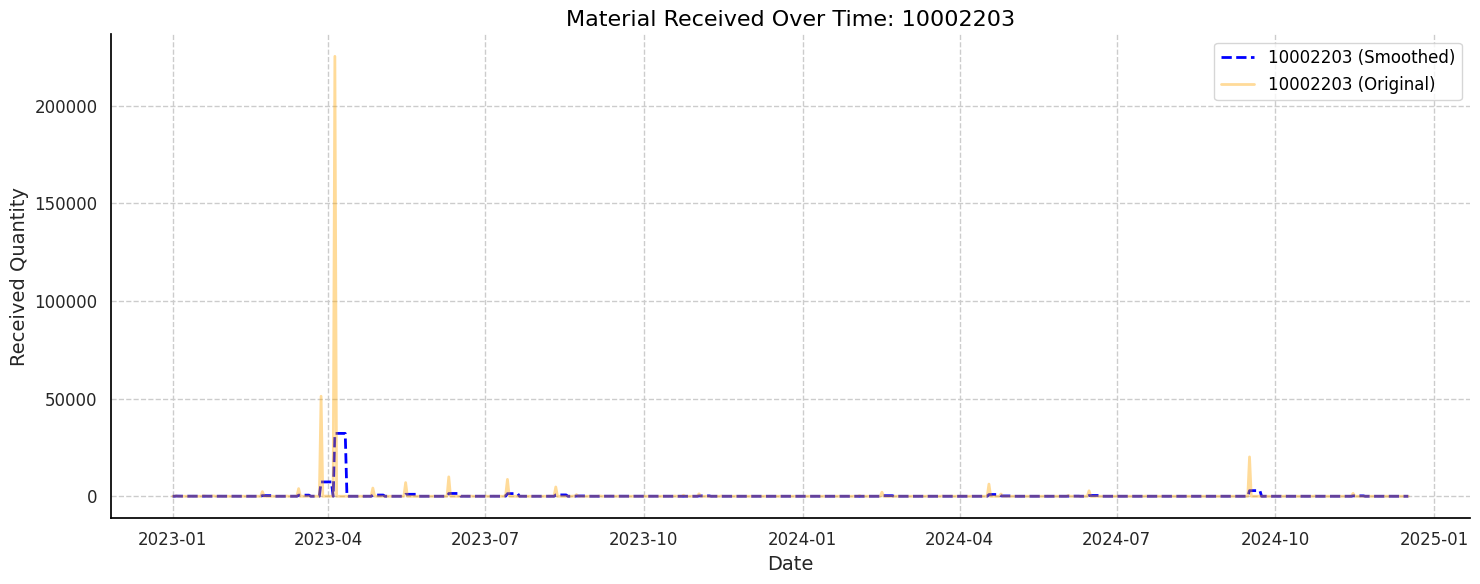

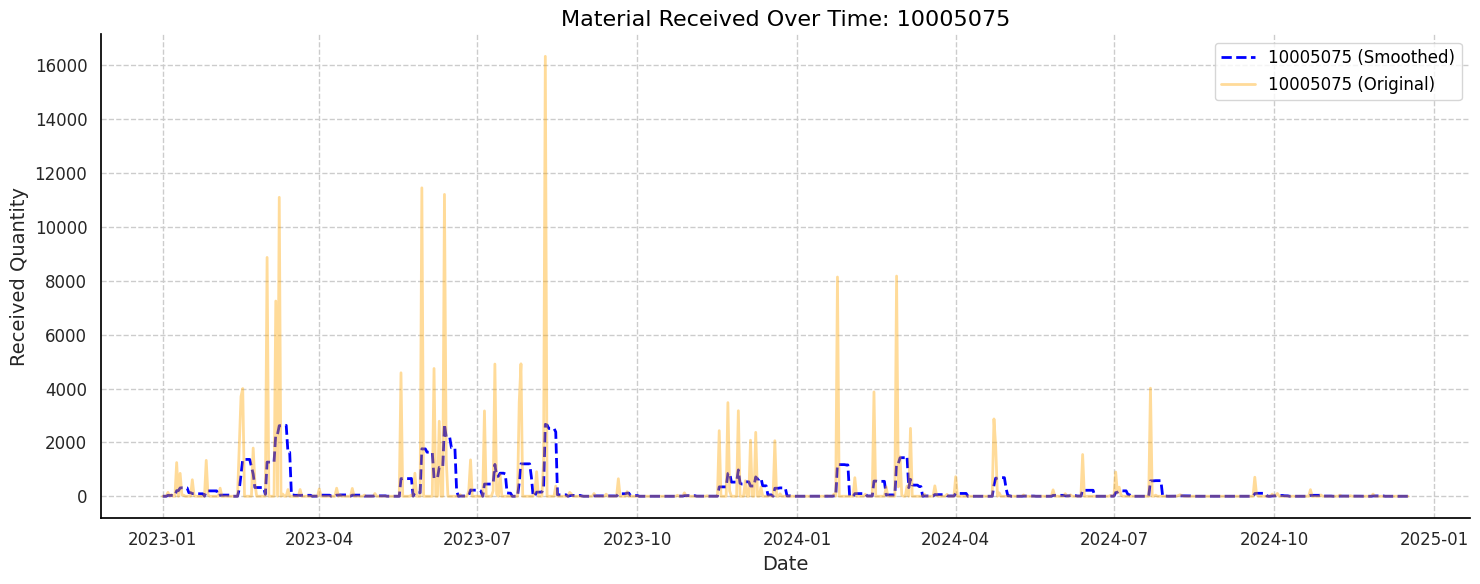

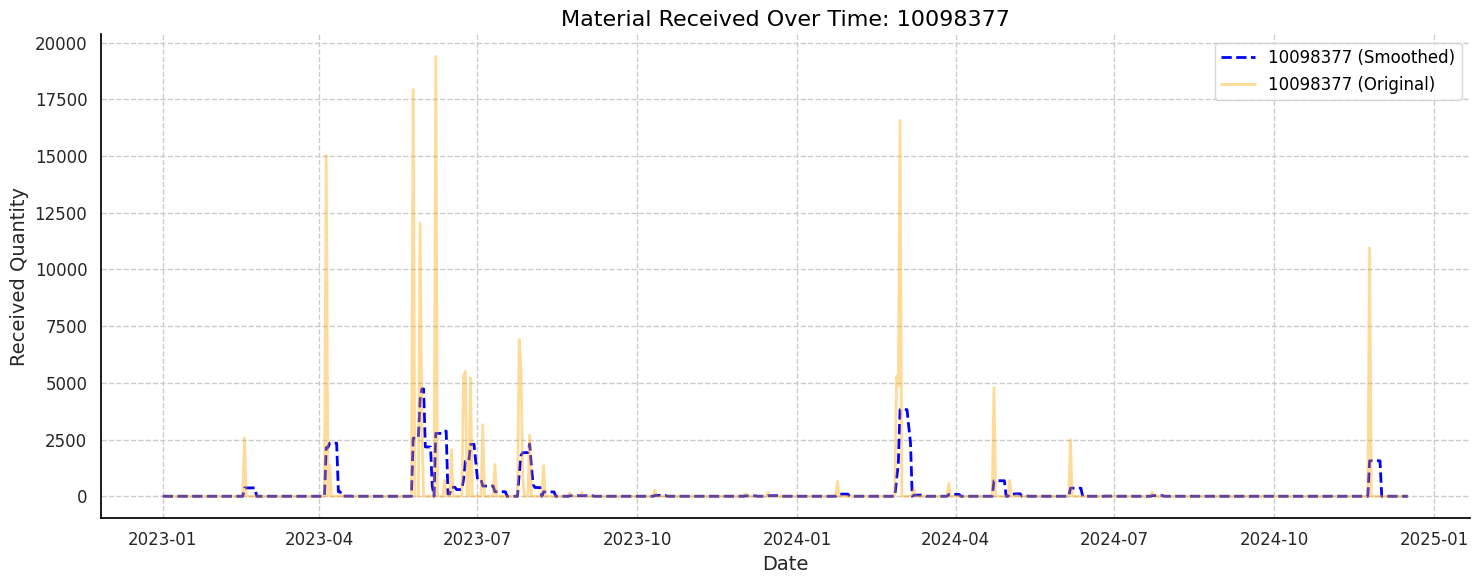

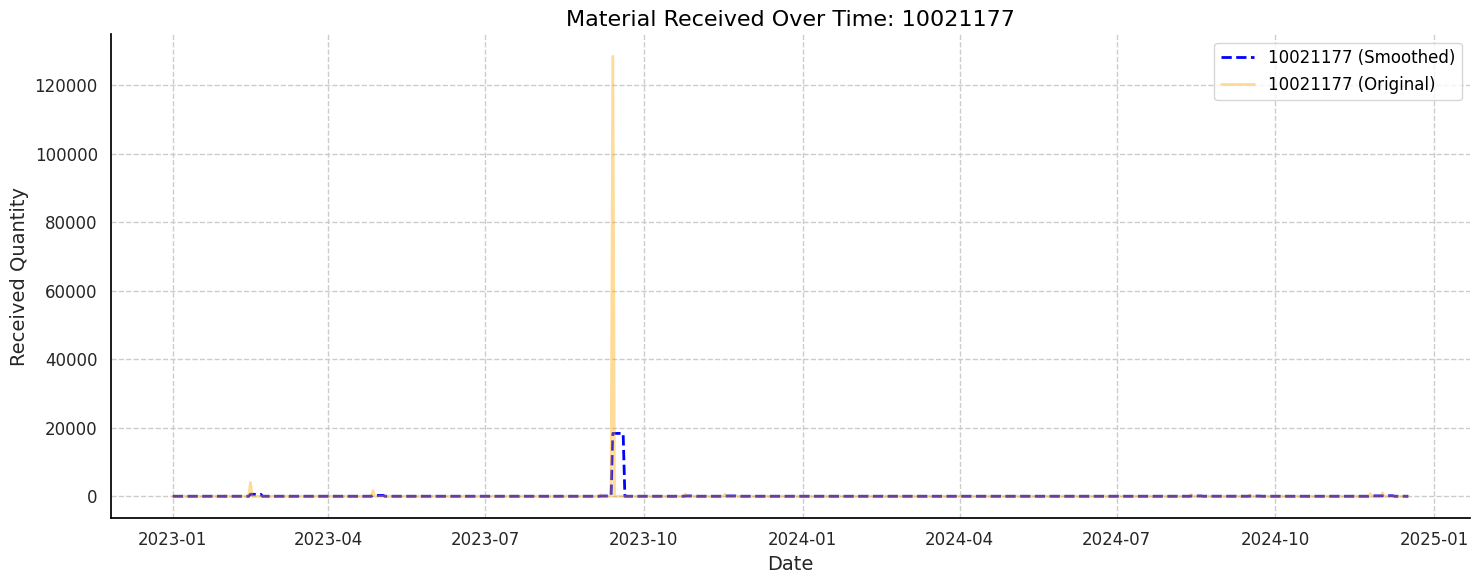

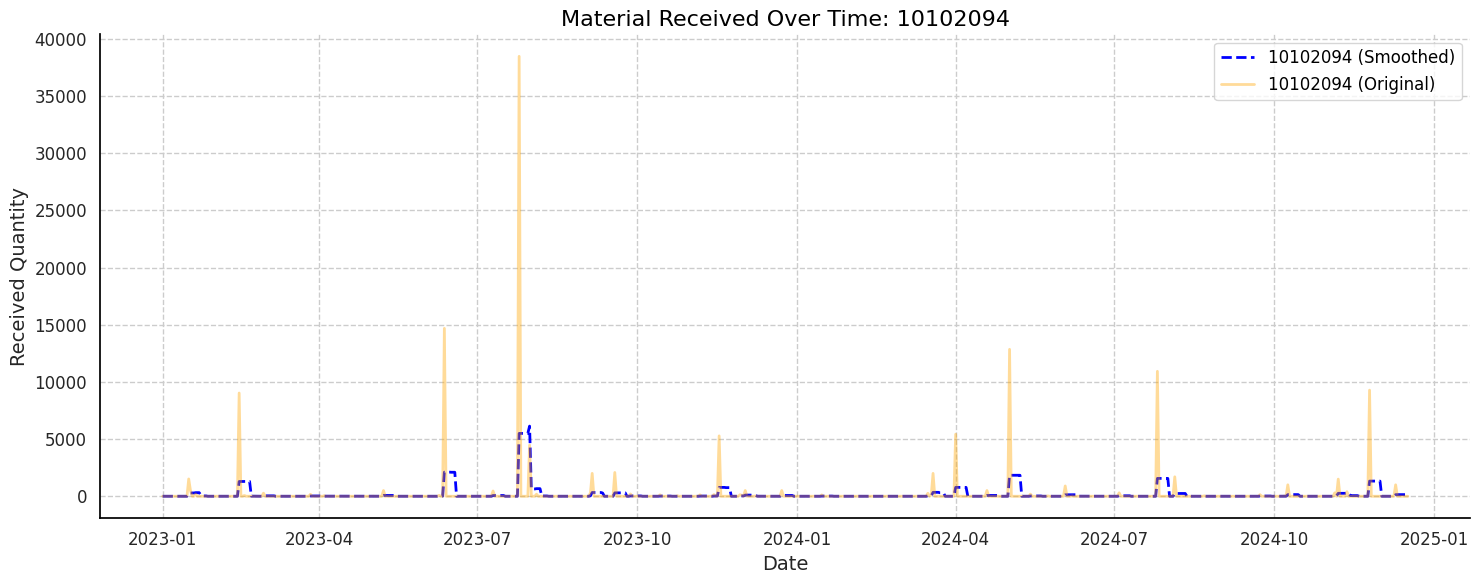

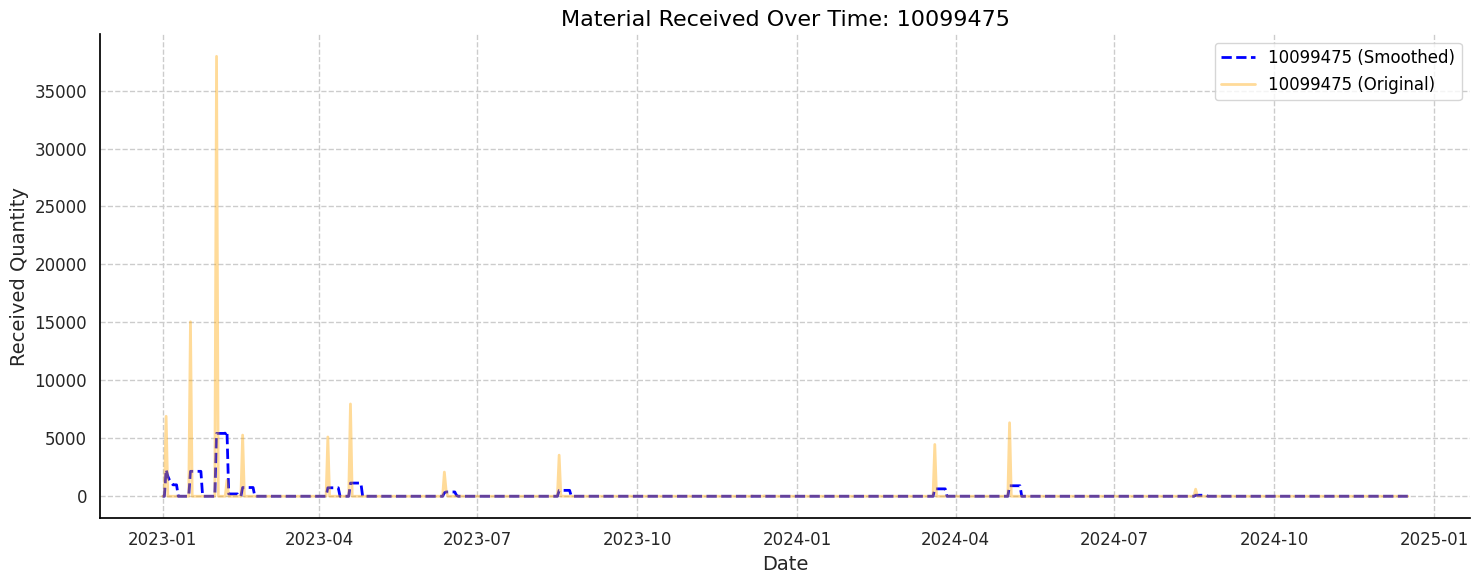

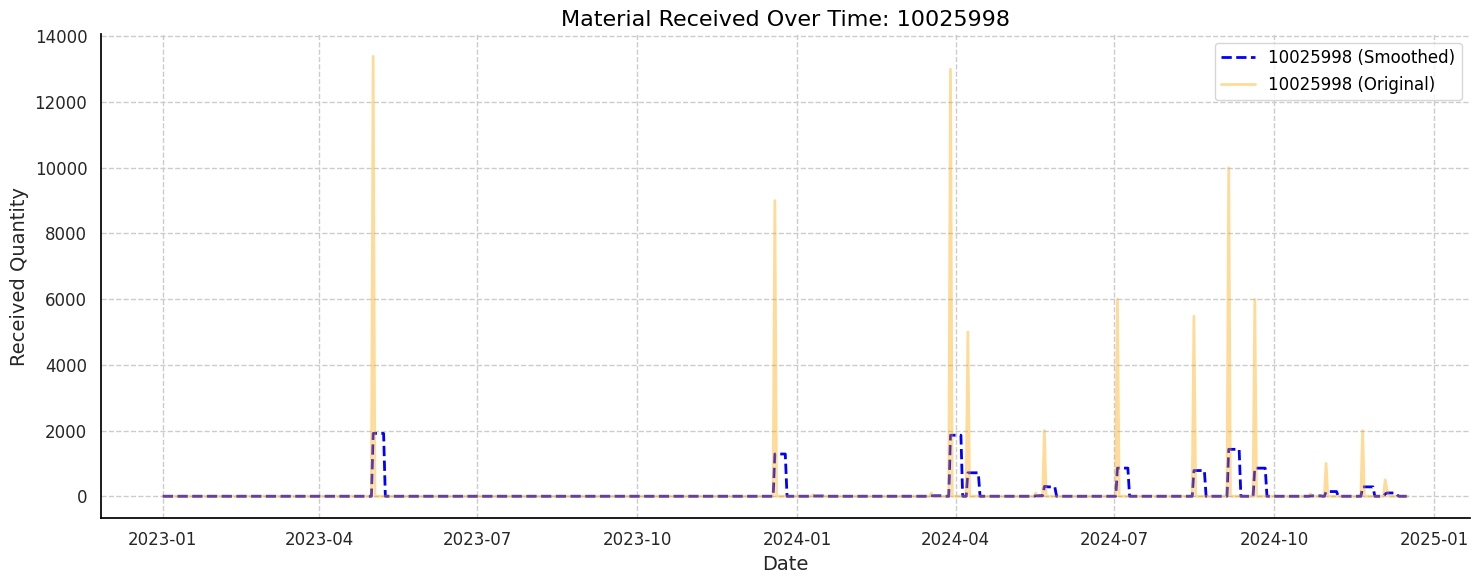

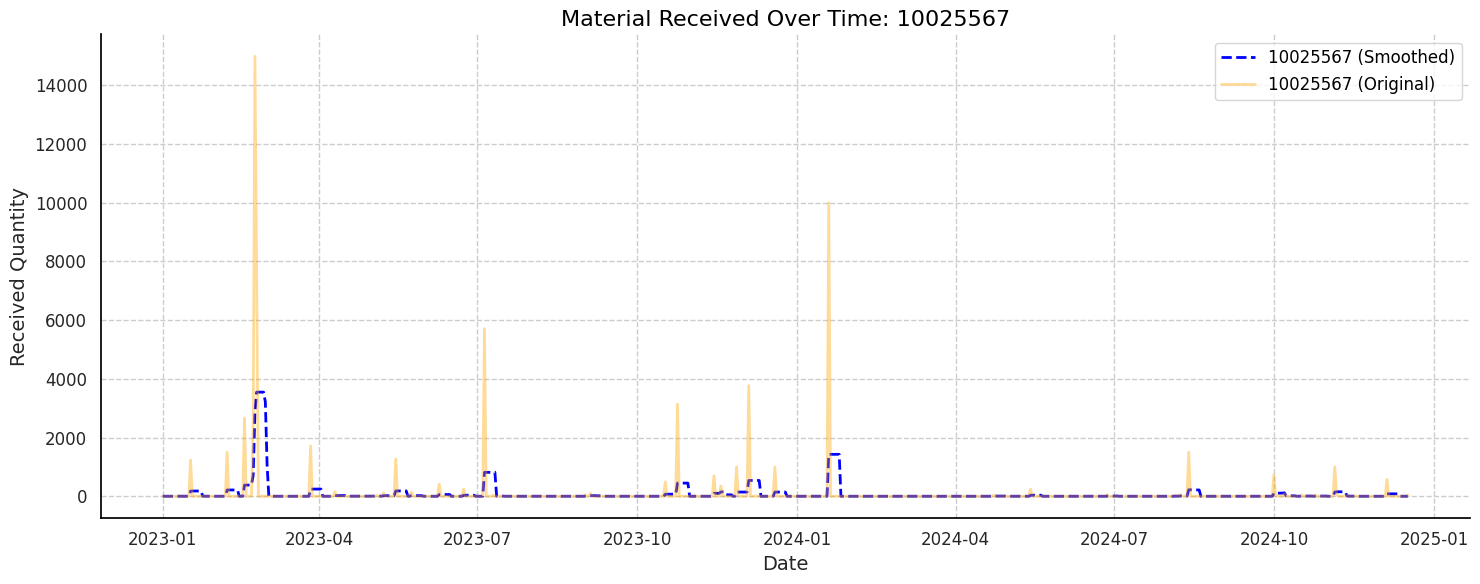

In [125]:
# Plotting for received materials
plot_material_over_time(
    data=data,
    material_df=top_received_df,
    value_column='Material Received',
    smoothed_column='Smoothed_Received',
    title_prefix='Material Received',
    y_label='Received Quantity',
    file_prefix='material_received'
)

## Bottom 10 Material by Issuance & Received (non-zero)

In [126]:
# Aggregating bottom 10 non-zero materials by issuance
bottom_issued = data[data['Material Issued'] > 0].groupby('Material Code')['Material Issued'].sum().sort_values(ascending=True).head(10)

# Aggregating bottom 10 non-zero materials by receipt
bottom_received = data[data['Material Received'] > 0].groupby('Material Code')['Material Received'].sum().sort_values(ascending=True).head(10)

# Convert to DataFrame for better readability
bottom_issued_df = bottom_issued.reset_index().rename(columns={'Material Issued': 'Total Issued'})
bottom_received_df = bottom_received.reset_index().rename(columns={'Material Received': 'Total Received'})

In [127]:
print("\nBottom 10 Non-Zero Issued Materials:")
bottom_issued_df


Bottom 10 Non-Zero Issued Materials:


Material Code  Total Issued
0        406141           1.0
1      10134880           1.0
2      10120893           1.0
3        400851           1.0
4      10108557           1.0
5      10108254           1.0
6      10108251           1.0
7      10099411           1.0
8        402980           1.0
9      10099413           1.0

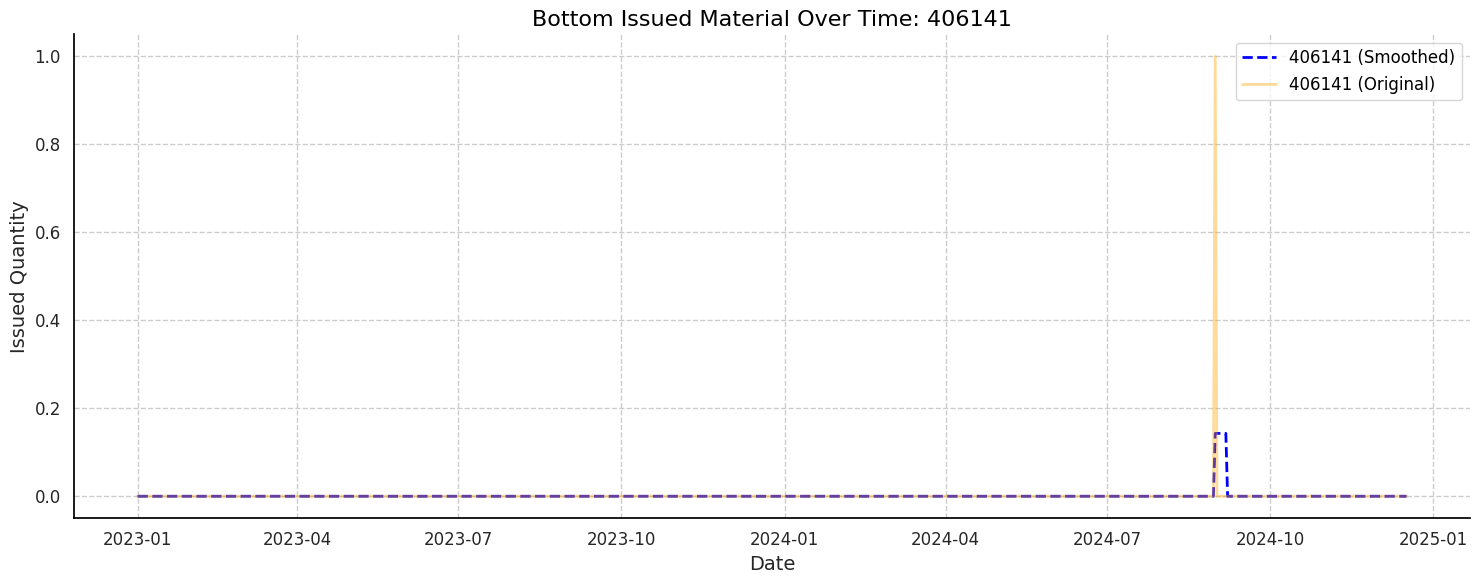

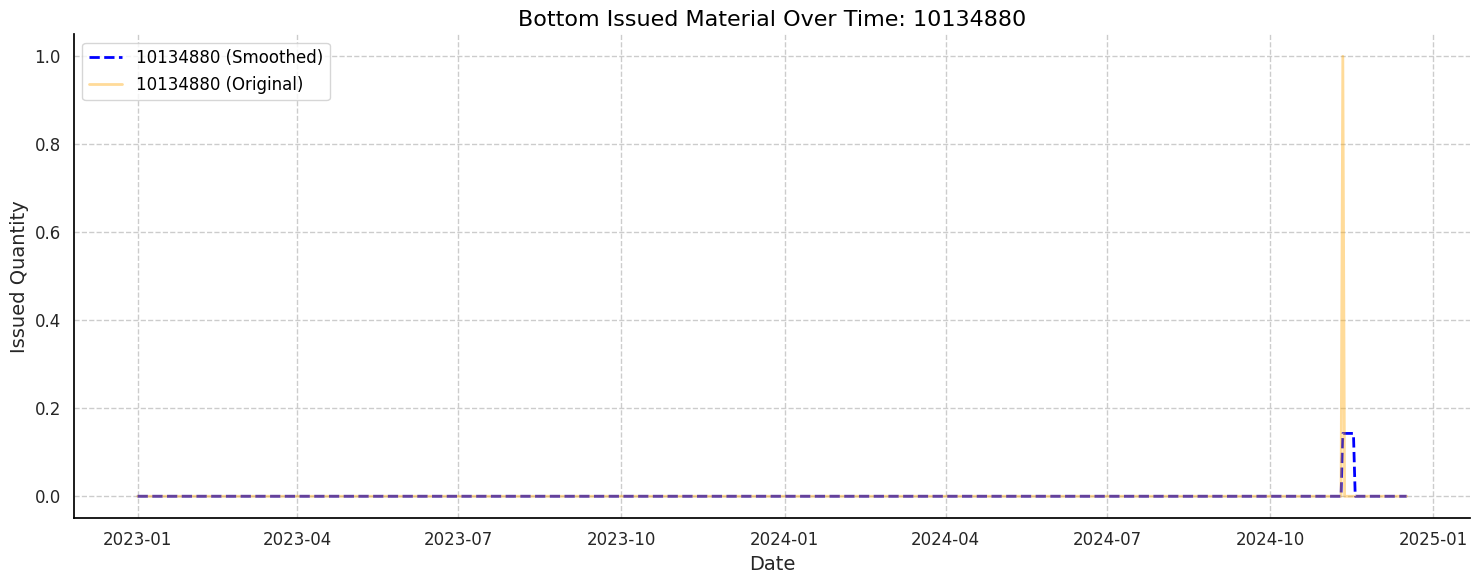

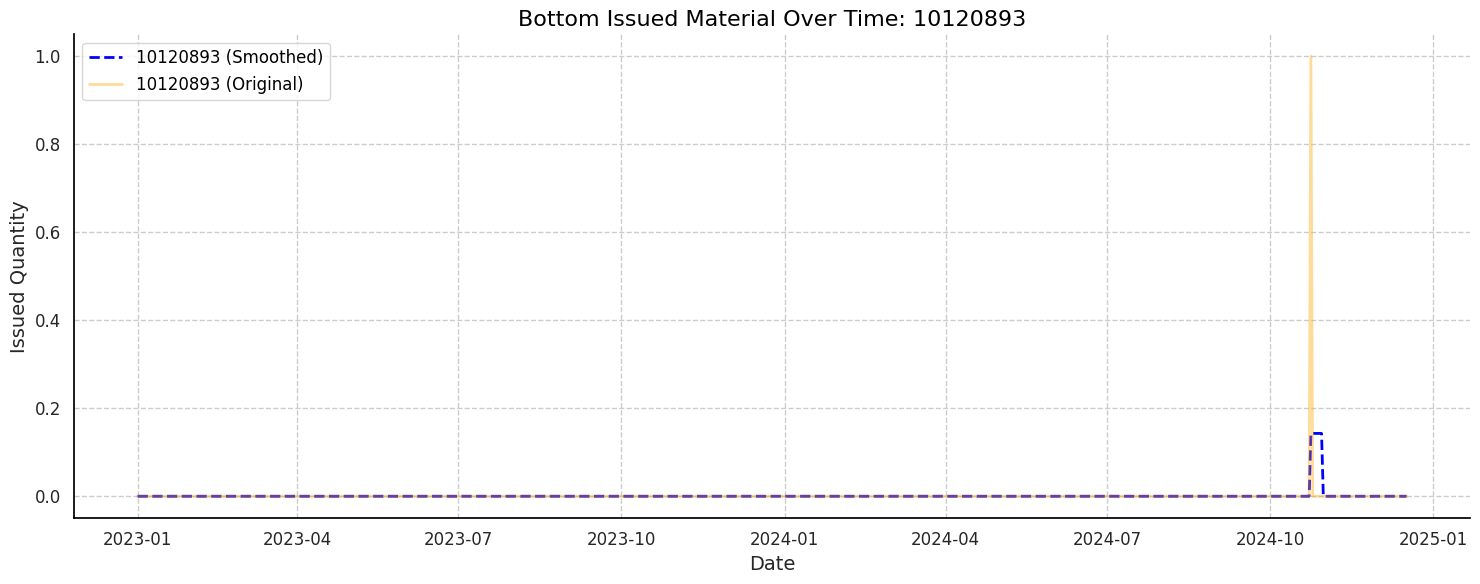

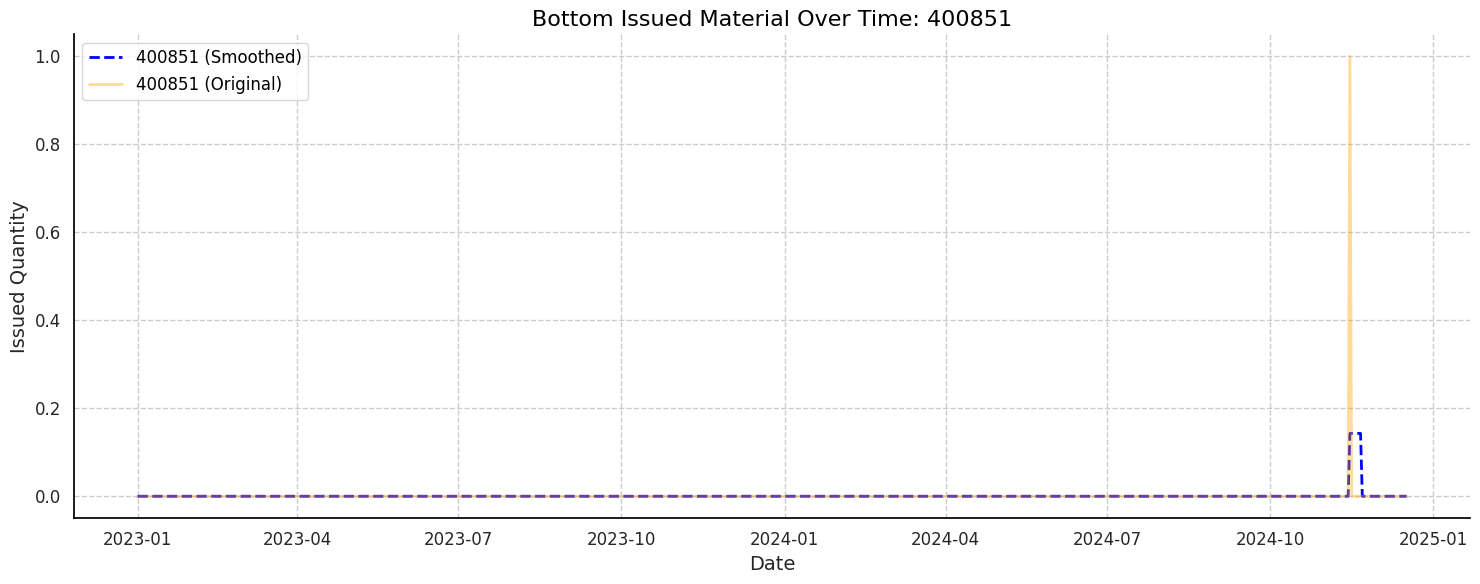

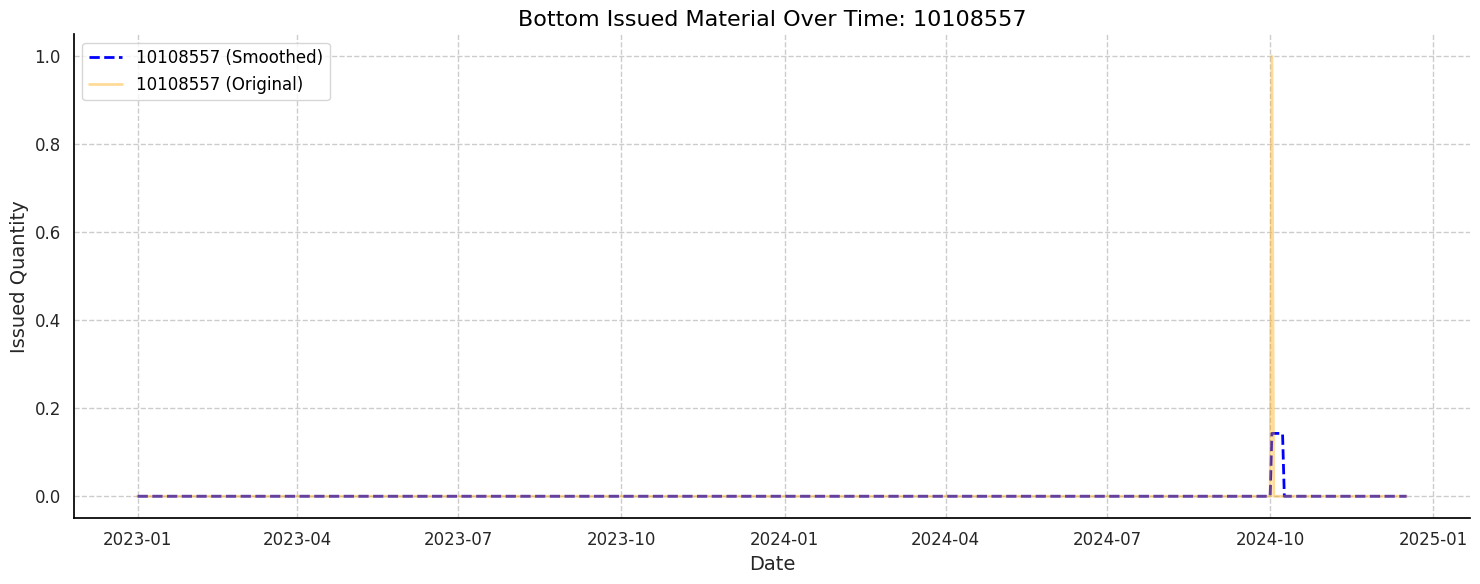

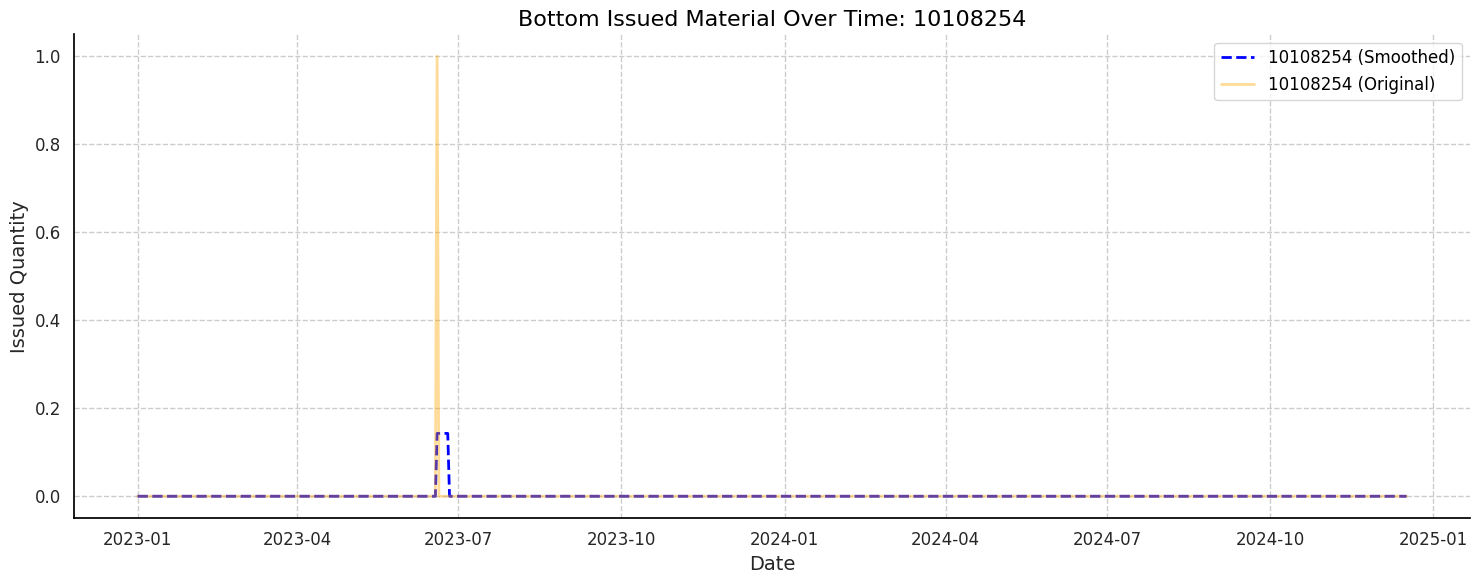

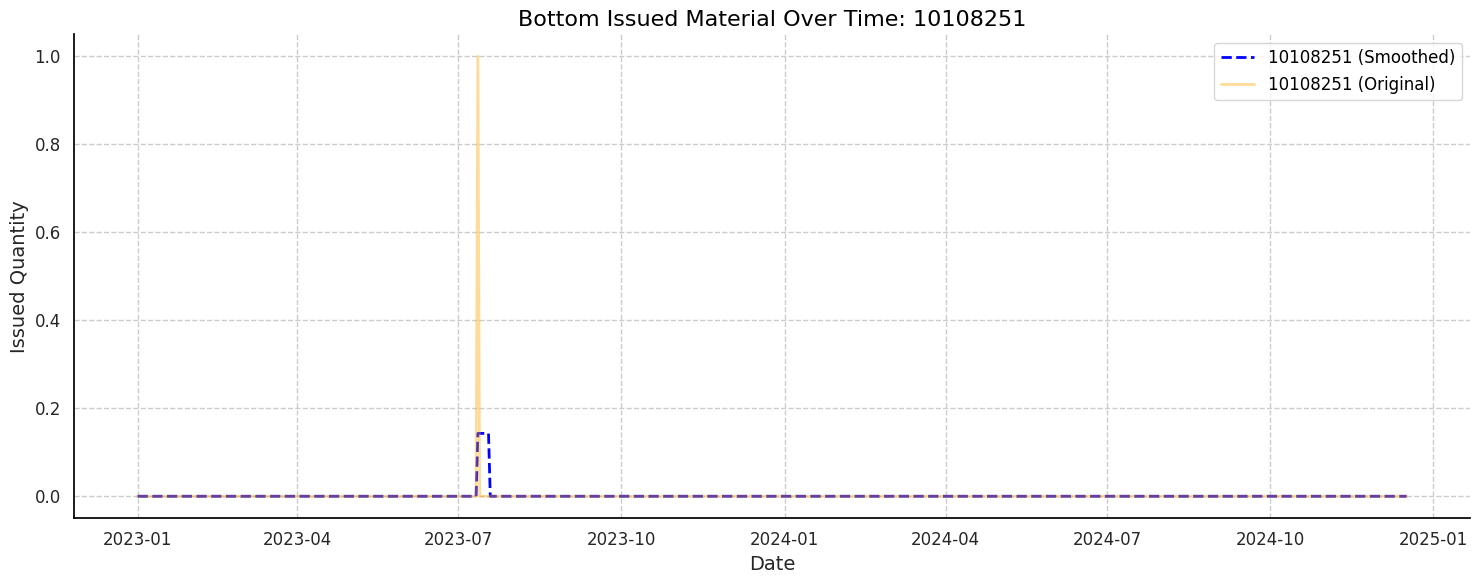

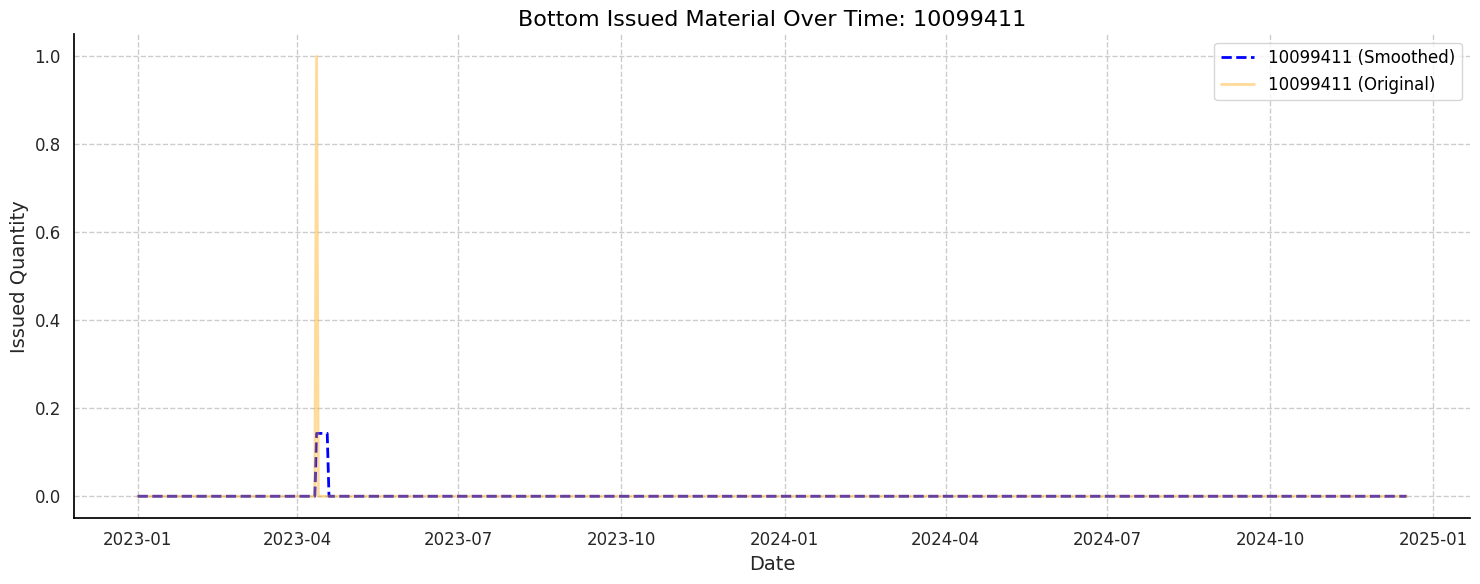

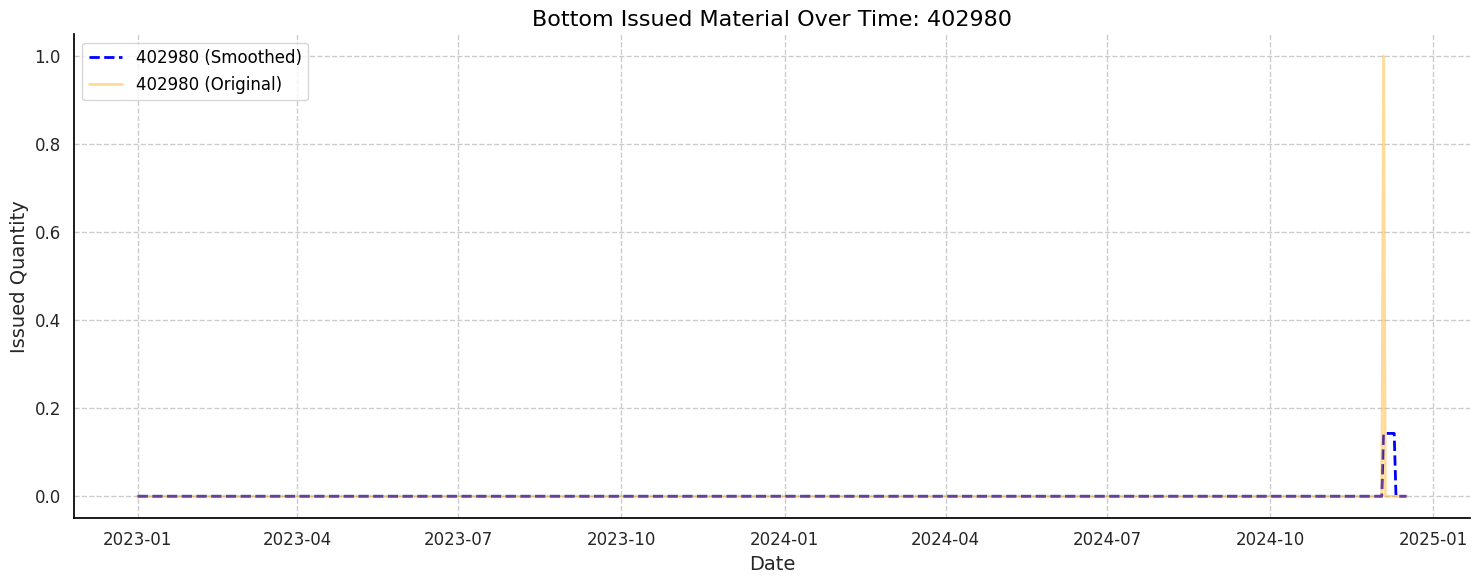

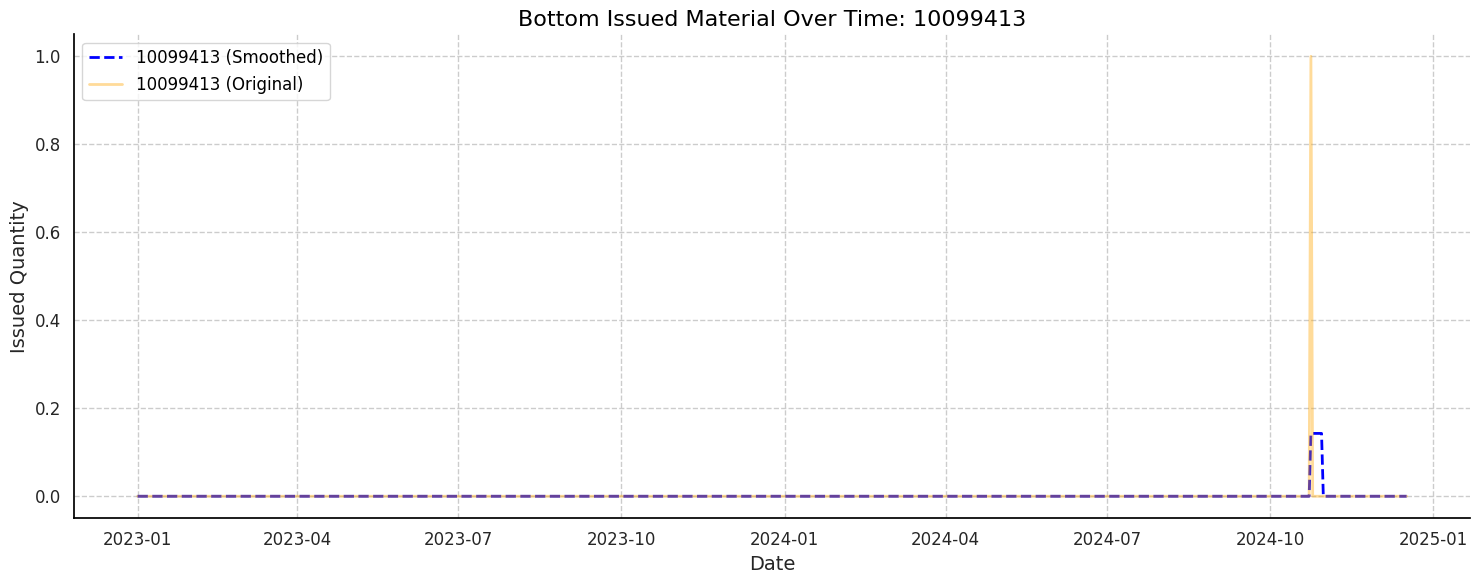

In [128]:
# Plotting for bottom issued materials
plot_material_over_time(
    data=data,
    material_df=bottom_issued_df,
    value_column='Material Issued',
    smoothed_column='Smoothed_Issued',
    title_prefix='Bottom Issued Material',
    y_label='Issued Quantity',
    file_prefix='bottom_issued_material'
)


In [63]:
print("\nBottom 10 Non-Zero Received Materials:")
bottom_received_df


Bottom 10 Non-Zero Received Materials:


Material Code  Total Received
0        406141             1.0
1      10031673             1.0
2        400851             1.0
3      10121682             1.0
4      10022094             1.0
5      10120893             1.0
6      10108251             1.0
7      10100295             1.0
8      10000338             1.0
9        400207             1.0

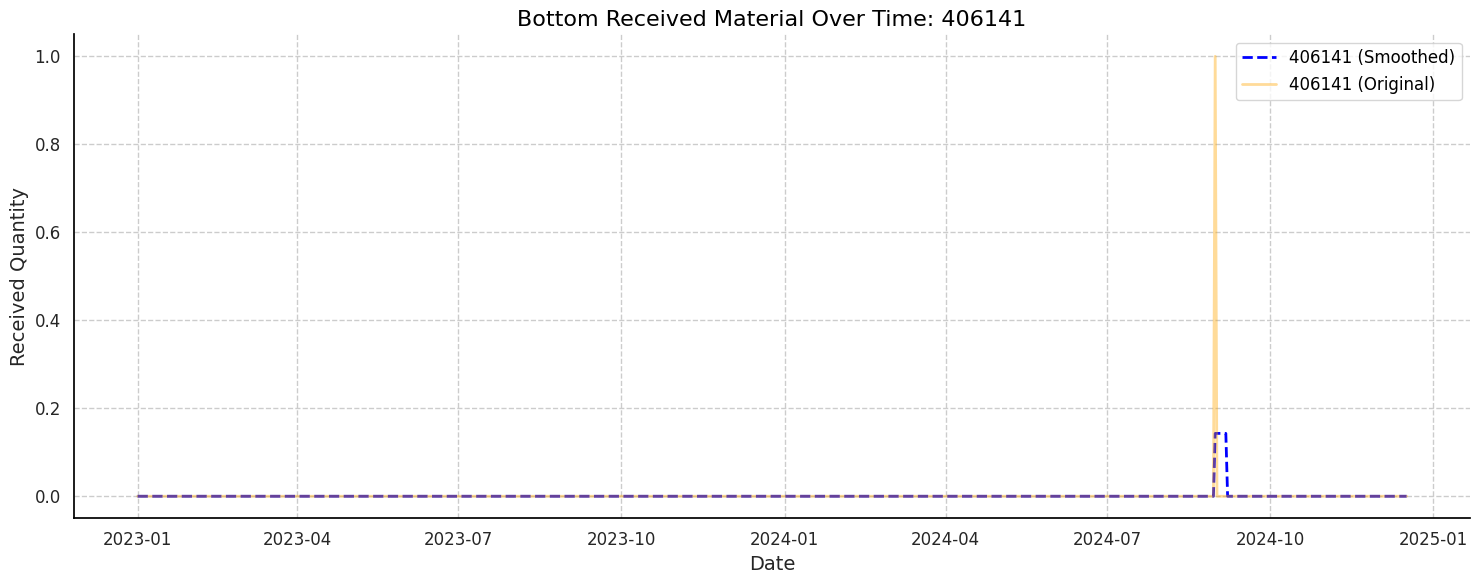

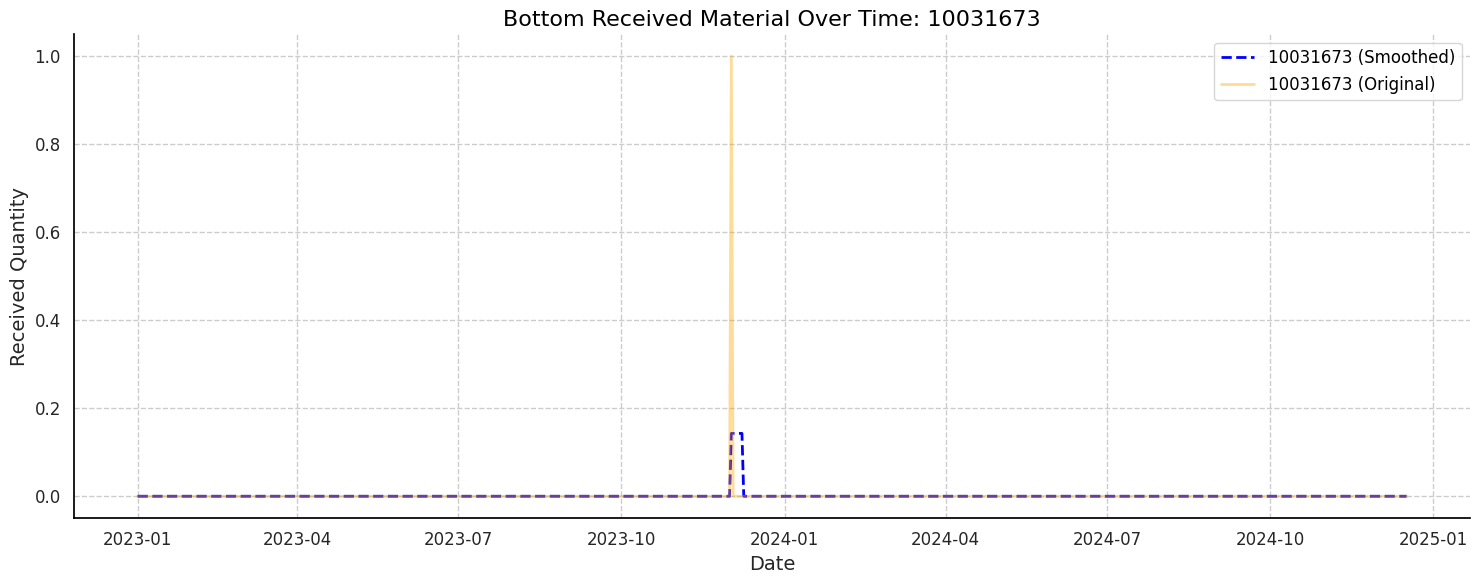

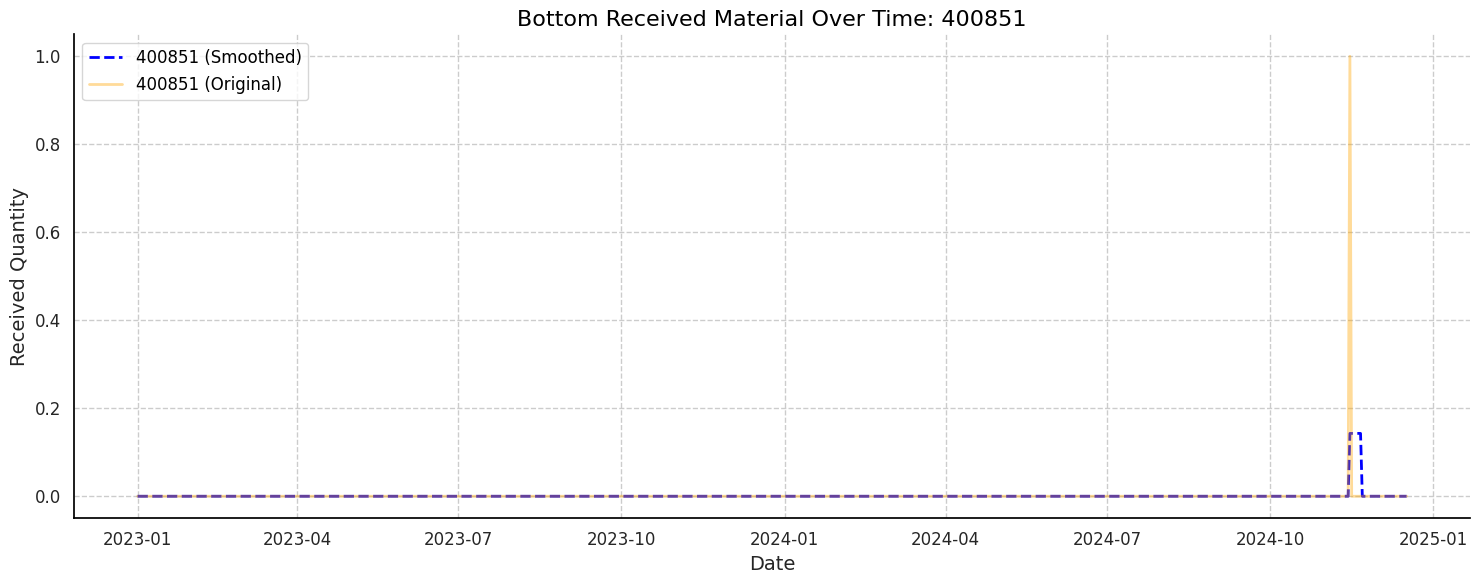

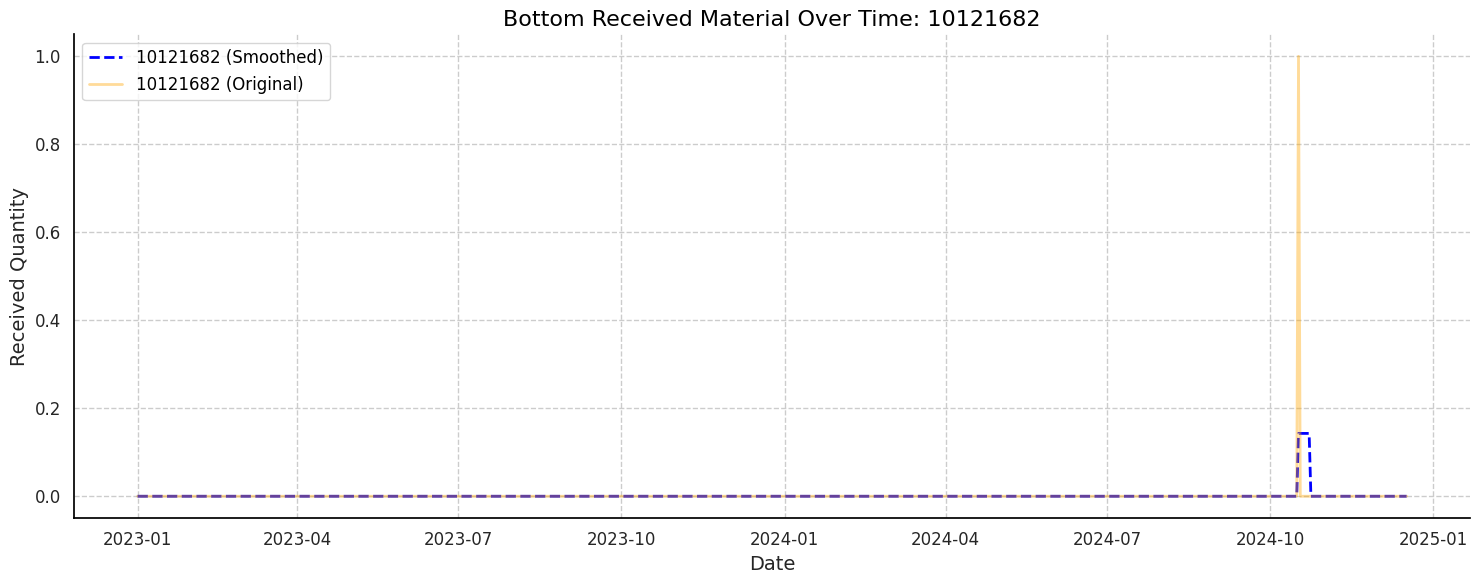

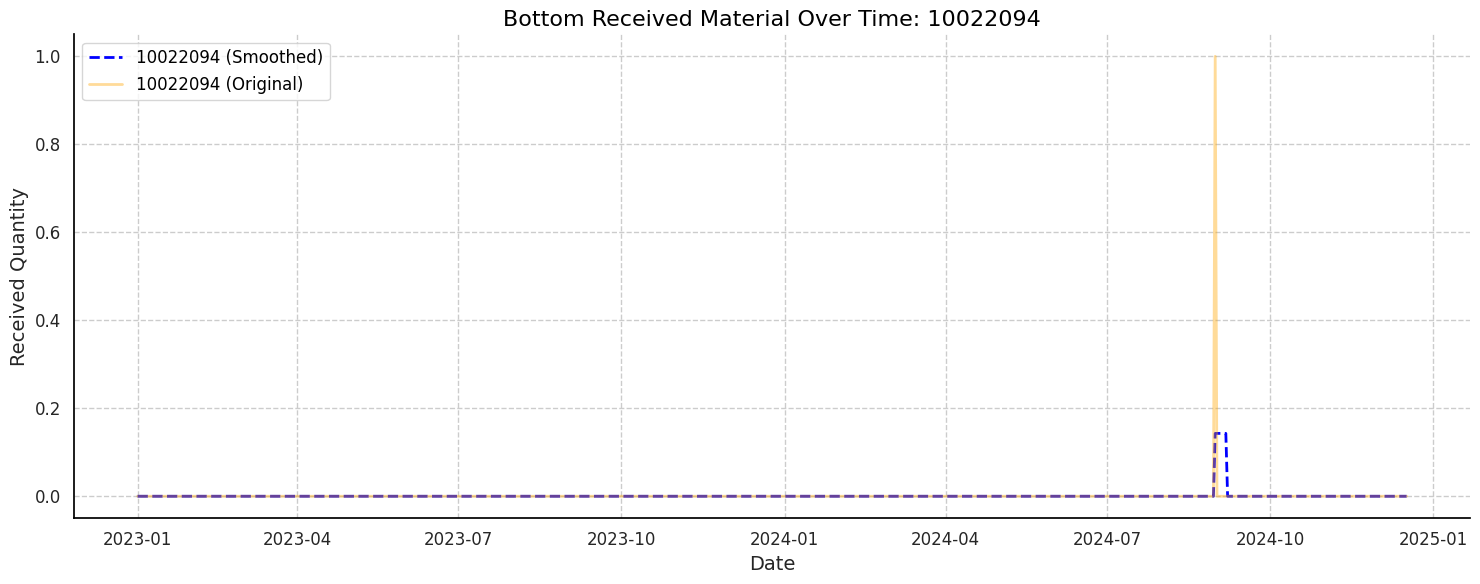

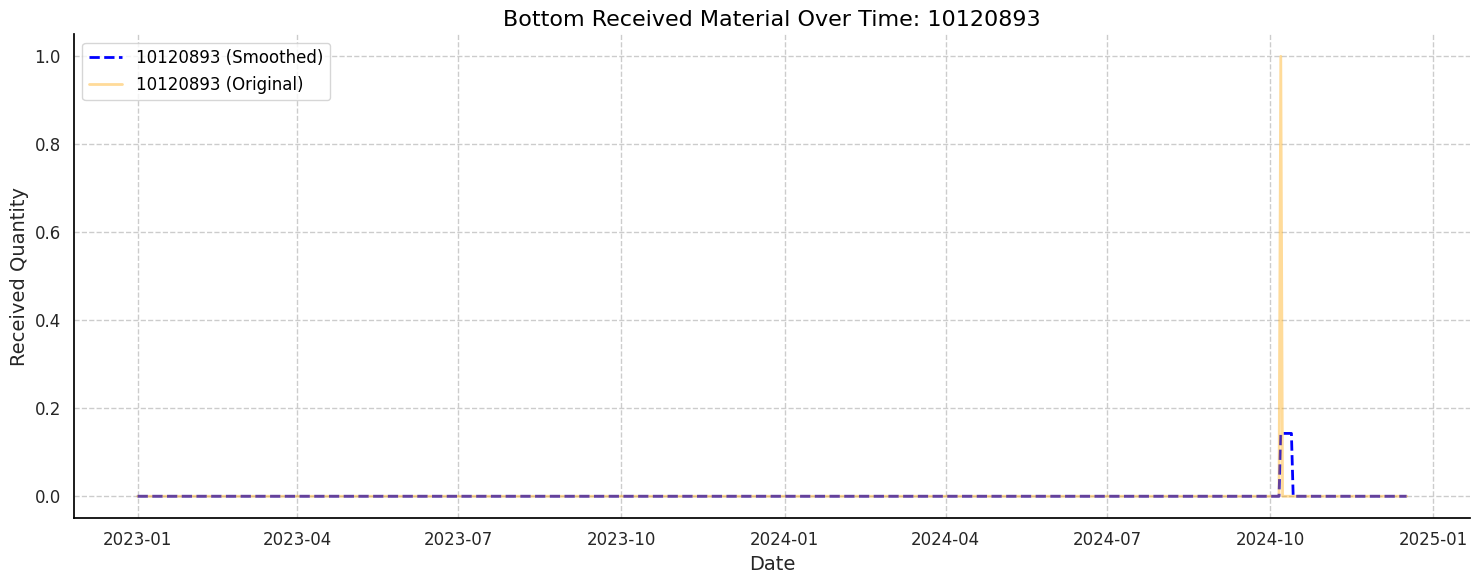

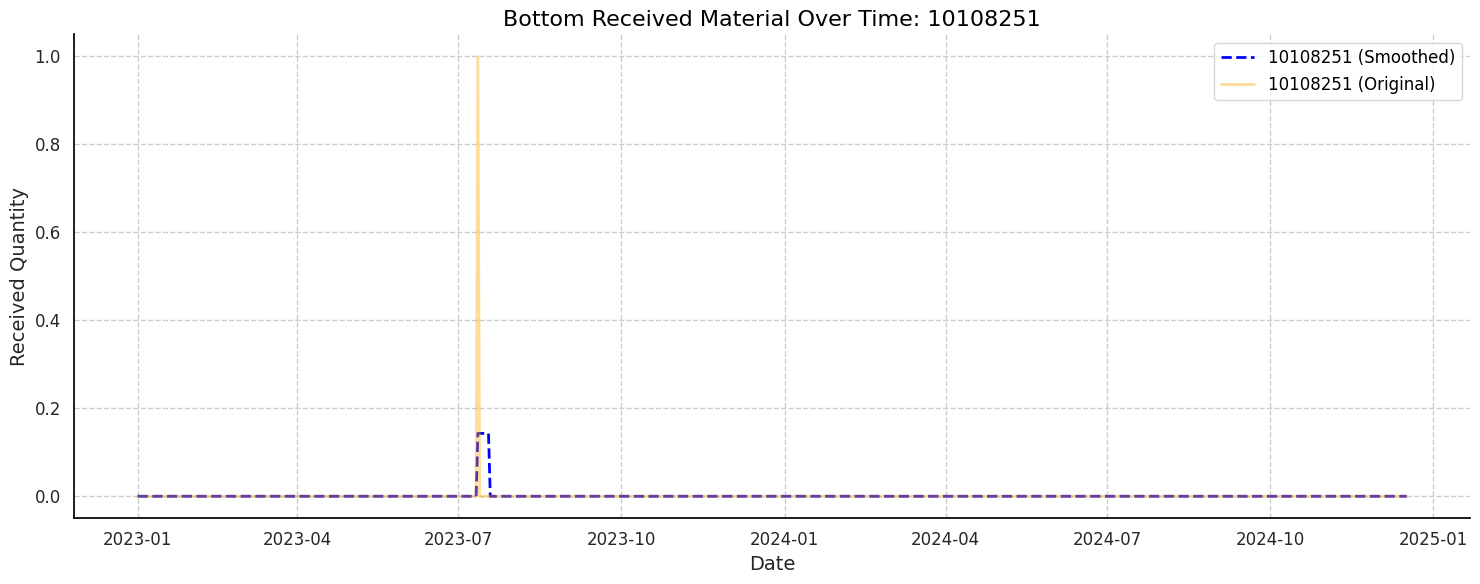

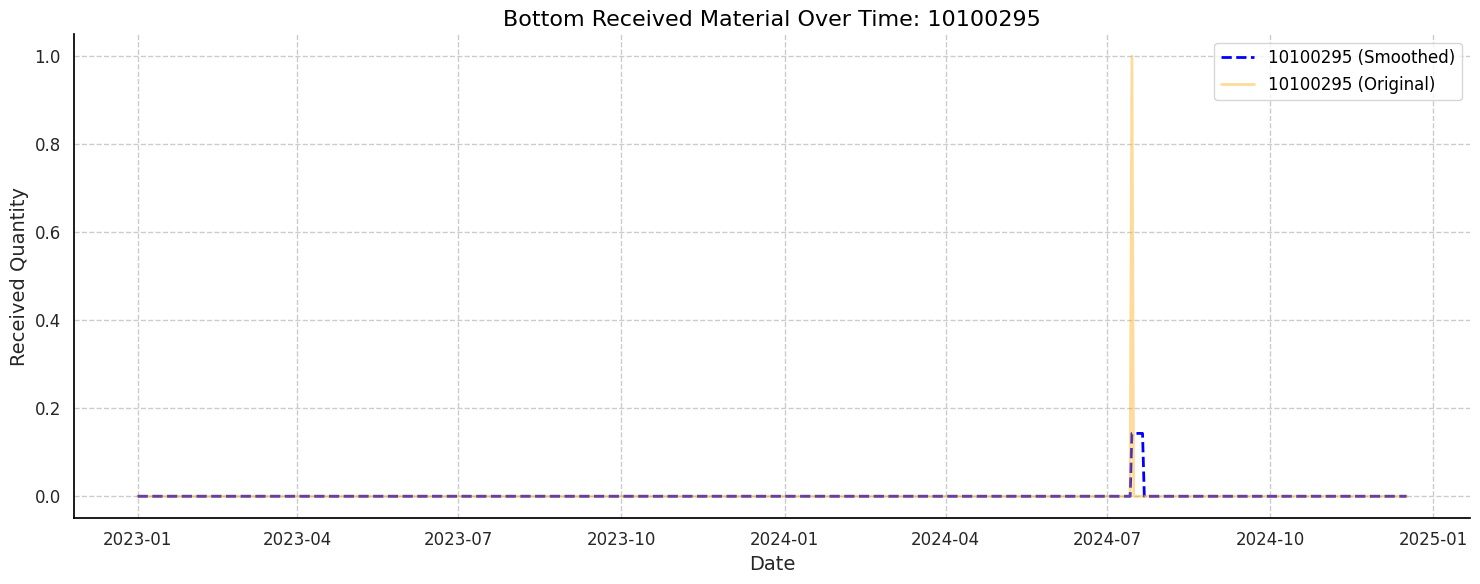

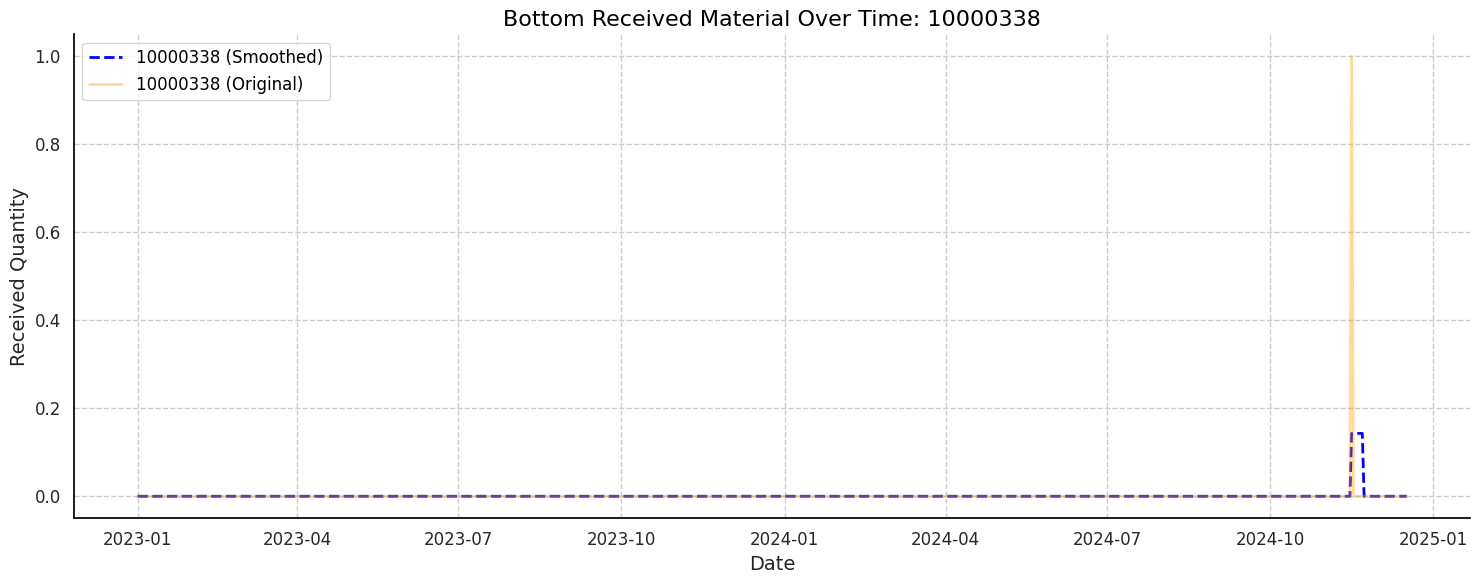

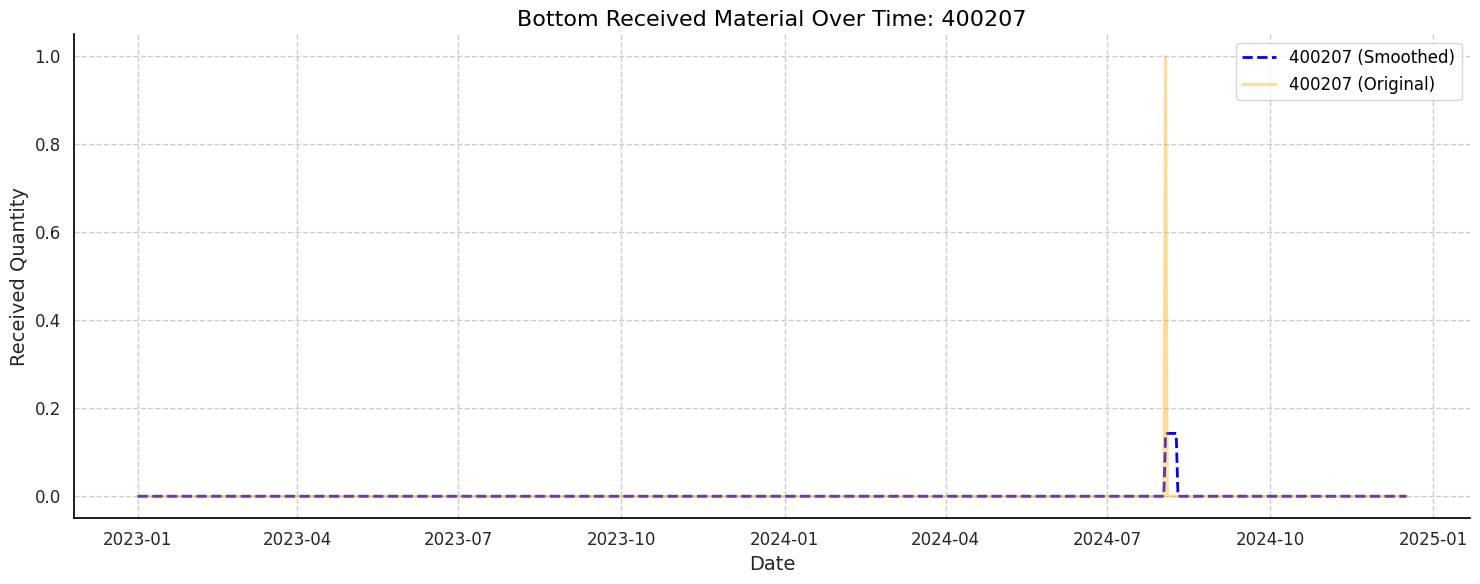

In [129]:
# Plotting for bottom received materials
plot_material_over_time(
    data=data,
    material_df=bottom_received_df,
    value_column='Material Received',
    smoothed_column='Smoothed_Received',
    title_prefix='Bottom Received Material',
    y_label='Received Quantity',
    file_prefix='bottom_received_material'
)

## Top 10 Material by Opening Stock (Start of Year)

In [134]:
# Top 10 materials by opening stock on the earliest date
first_date, top_10_open_stock = get_top_stock(
    data=data,
    date_column='Date',
    stock_columns=['Material Code', 'Open Stock', 'Open Stock Amount'],
    sort_by='Open Stock Amount',
    top_n=10,
    earliest=True
)
print(f"\nTop 10 Materials with Maximum Opening Stock on First Date ({first_date}):")
display(top_10_open_stock)



Top 10 Materials with Maximum Opening Stock on First Date (2023-01-01 00:00:00):


Material Code  Open Stock  Open Stock Amount
9030      10098377     34510.0       4.079531e+08
8540      10001185     19132.4       1.091130e+08
8665      10005061      3252.0       7.399191e+07
9000      10094526       555.0       6.638453e+07
8475      10000360       514.0       5.978237e+07
8627      10001921      7320.0       4.079656e+07
8867      10036233      8248.0       3.284609e+07
8661      10005057     13316.0       2.923754e+07
8495      10000705        19.0       2.593500e+07
8493      10000698        14.0       2.483450e+07

## Top 10 Material by Closing Stock (End of Year)

In [135]:
# Top 10 materials by closing stock on the latest date
last_date, top_10_closing_stock = get_top_stock(
    data=data,
    date_column='Date',
    stock_columns=['Material Code', 'Closing Stock', 'Closing Stock Amount'],
    sort_by='Closing Stock Amount',
    top_n=10,
    earliest=False
)
print(f"\nTop 10 Materials with Maximum Closing Stock on Last Date ({last_date}):")
display(top_10_closing_stock)


Top 10 Materials with Maximum Closing Stock on Last Date (2024-12-17 00:00:00):


Material Code  Closing Stock  Closing Stock Amount
727272      10098377        16783.0          1.983969e+08
727295      10098866           22.0          1.702576e+08
727110      10036234         4080.0          8.523124e+07
726738      10000710           23.0          7.165187e+07
727354      10102026          190.0          6.270000e+07
726914      10005075         5637.0          5.590089e+07
726907      10005061         2301.0          5.235405e+07
726782      10001185         9002.0          5.133886e+07
726735      10000698           21.0          3.725175e+07
727294      10098865            3.0          3.554400e+07

## Comparison of Opening Stock & Closing Stock

In [146]:
# Get top 10 materials by opening stock on the earliest date
first_date, top_10_open_stock = get_top_stock_by_date(
    data=data,
    date_column='Date',
    stock_columns=['Material Code', 'Open Stock', 'Open Stock Amount'],
    sort_by='Open Stock Amount',
    top_n=10,
    earliest=True
)

# Get closing stock for the latest date for the same materials
last_date, closing_stock_last_date = get_top_stock_by_date(
    data=data,
    date_column='Date',
    stock_columns=['Material Code', 'Closing Stock', 'Closing Stock Amount', 'BFP'],
    sort_by='Closing Stock Amount',
    top_n=None,  # Include all rows for merging
    earliest=False
)

# Merge the data
merged_opening_closing_stock = merge_stock_data(top_10_open_stock, closing_stock_last_date, merge_on='Material Code')

# Display the result
print(f"\nTop 10 Materials with Maximum Opening Stock on First Date ({first_date}):")
display(merged_opening_closing_stock)


Top 10 Materials with Maximum Opening Stock on First Date (2023-01-01 00:00:00):


Material Code  Open Stock  Open Stock Amount  Closing Stock  \
0      10098377     34510.0       4.079531e+08        16783.0   
1      10001185     19132.4       1.091130e+08         9002.0   
2      10005061      3252.0       7.399191e+07         2301.0   
3      10094526       555.0       6.638453e+07          275.0   
4      10000360       514.0       5.978237e+07          267.0   
5      10001921      7320.0       4.079656e+07         1461.0   
6      10036233      8248.0       3.284609e+07         3650.0   
7      10005057     13316.0       2.923754e+07          298.0   
8      10000705        19.0       2.593500e+07            0.0   
9      10000698        14.0       2.483450e+07           21.0   

   Closing Stock Amount  BFP  
0          1.983969e+08    0  
1          5.133886e+07    0  
2          5.235405e+07    0  
3          3.289324e+07    0  
4          3.105427e+07    0  
5          8.142591e+06    0  
6          1.453543e+07    0  
7          6.543097e+05    0  
8          0.000000e+00    0  
9          3.725175e+07    0

**Key Observations:**
* **Significant Decreases in Stock:**
> * Several materials show a substantial decrease in stock amounts from the beginning to the end of the year. For example:
>> * Material Code 10098377: Decreased from 40,795,310 to 19,839,690.
>> * Material Code 10005061: Decreased from 73,991,910 to 52,354,050.
>> * Material Code 10094526: Decreased from 66,384,530 to 32,893,240.
>> * Material Code 10000360: Decreased from 59,782,370 to 31,054,270.
> * These decreases suggest high consumption or usage of these materials throughout the year, possibly due to increased production activities or high demand.

* **Significant Increases in Stock:**
> * Some materials show a notable increase in stock amounts. For example:
>> * Material Code 10001185: Increased from 10,911,300 to 51,338,860.
>> * Material Code 10001921: Increased from 40,796,560 to 81,425,910.
> * These increases indicate high production or procurement levels relative to their usage, which could be due to strategic inventory build-up or overstocking.

* **Minimal Changes in Stock:**
> * A few materials show relatively stable stock amounts with minimal changes. For example:
>> * Material Code 10036233: Decreased slightly from 32,846,090 to 14,535,430.
>> * Material Code 10000698: Increased slightly from 24,834,500 to 37,251,750.
> * These materials likely had balanced production and consumption rates throughout the year.

* **Zero Closing Stock:**
> * One material, Material Code 10000705, shows a closing stock amount of zero, indicating complete depletion of the stock by the end of the year. This could be due to high demand or usage without replenishment.

In [148]:
# Get top 10 materials by closing stock on the latest date
last_date, top_10_closing_stock = get_top_stock_by_date(
    data=data,
    date_column='Date',
    stock_columns=['Material Code', 'Closing Stock', 'Closing Stock Amount'],
    sort_by='Closing Stock Amount',
    top_n=10,
    earliest=False
)

# Get opening stock for the earliest date for the same materials
first_date, opening_stock_first_date = get_top_stock_by_date(
    data=data,
    date_column='Date',
    stock_columns=['Material Code', 'Open Stock', 'Open Stock Amount', 'BFP'],
    sort_by='Open Stock Amount',
    top_n=None,  # Include all rows for merging
    earliest=True
)

# Merge the data
merged_closing_opening_stock = merge_stock_data(top_10_closing_stock, opening_stock_first_date, merge_on='Material Code')

# Display the result
print(f"\nTop 10 Materials with Maximum Closing Stock on Last Date ({last_date}):")
display(merged_closing_opening_stock)


Top 10 Materials with Maximum Closing Stock on Last Date (2024-12-17 00:00:00):


Material Code  Closing Stock  Closing Stock Amount  Open Stock  \
0      10098377        16783.0          1.983969e+08     34510.0   
1      10098866           22.0          1.702576e+08         1.0   
2      10036234         4080.0          8.523124e+07       864.0   
3      10000710           23.0          7.165187e+07         0.0   
4      10102026          190.0          6.270000e+07        13.0   
5      10005075         5637.0          5.590089e+07       859.0   
6      10005061         2301.0          5.235405e+07      3252.0   
7      10001185         9002.0          5.133886e+07     19132.4   
8      10000698           21.0          3.725175e+07        14.0   
9      10098865            3.0          3.554400e+07         0.0   

   Open Stock Amount  BFP  
0       4.079531e+08    0  
1       7.738984e+06    0  
2       1.804897e+07    0  
3       0.000000e+00    0  
4       4.290000e+06    0  
5       8.518514e+06    0  
6       7.399191e+07    0  
7       1.091130e+08    0  
8       2.483450e+07    0  
9       0.000000e+00    0

**Key Observations:**
* **Significant Increases in Closing Stock:**
> * Material Code 10036234: The closing stock amount increased significantly from 18,048,970 to 85,231,240. This indicates a substantial build-up of inventory, possibly due to increased production or procurement.
> * Material Code 10000710: The closing stock amount is 71,651,870, starting from zero. This suggests a significant addition to inventory during the year.
> * Material Code 10102026: The closing stock amount increased from 42,900,000 to 62,700,000. This indicates a moderate build-up of inventory.

* **Significant Decreases in Stock:**
> * Material Code 10098377: The stock decreased from 40,795,310 to 19,839,690. This suggests high consumption or usage of this material throughout the year.
> * Material Code 10098866: The stock decreased from 77,389,840 to 17,025,760. This indicates very high usage or consumption relative to the opening stock.

* **Moderate Changes in Stock:**
> * Material Code 10005075: The stock decreased from 85,185,140 to 55,900,890. This indicates a moderate decrease in inventory, suggesting balanced usage and replenishment.
> * Material Code 10005061: The stock decreased from 73,991,910 to 52,354,050. This also indicates a moderate decrease in inventory.

* **Zero Opening Stock:**
> * Material Code 10000710 and 10098865: Both started with zero opening stock but ended with significant closing stock amounts (71,651,870 and 35,544,000, respectively). This suggests new additions to the inventory during the year.
Patterns:

* **High Inventory Build-Up:**
> * Materials like 10036234 and 10000710 show a significant increase in closing stock, indicating a strategic build-up of inventory. This could be due to anticipated future demand, production planning, or procurement strategies.

* **High Consumption:**
> * Materials like 10098377 and 10098866 show a significant decrease in stock, indicating high consumption or usage. This could be due to increased production activities, high demand, or other operational needs.

* **Balanced Inventory Management:**
> * Materials like 10005075 and 10005061 show moderate changes in stock, suggesting balanced inventory management where usage and replenishment are relatively aligned.

* **New Inventory Additions:**
> * Materials like 10000710 and 10098865 started with zero opening stock but ended with significant closing stock, indicating new additions to the inventory. This could be due to new product introductions, strategic stocking, or other business decisions.

## Weekend Activity

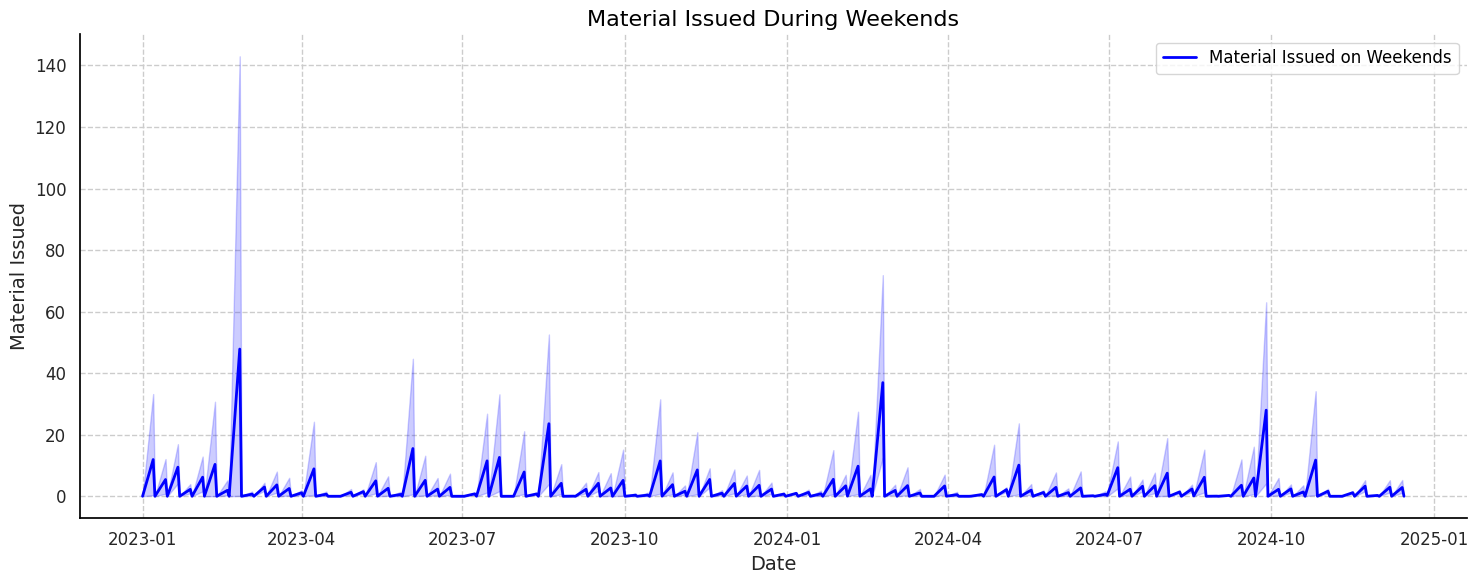

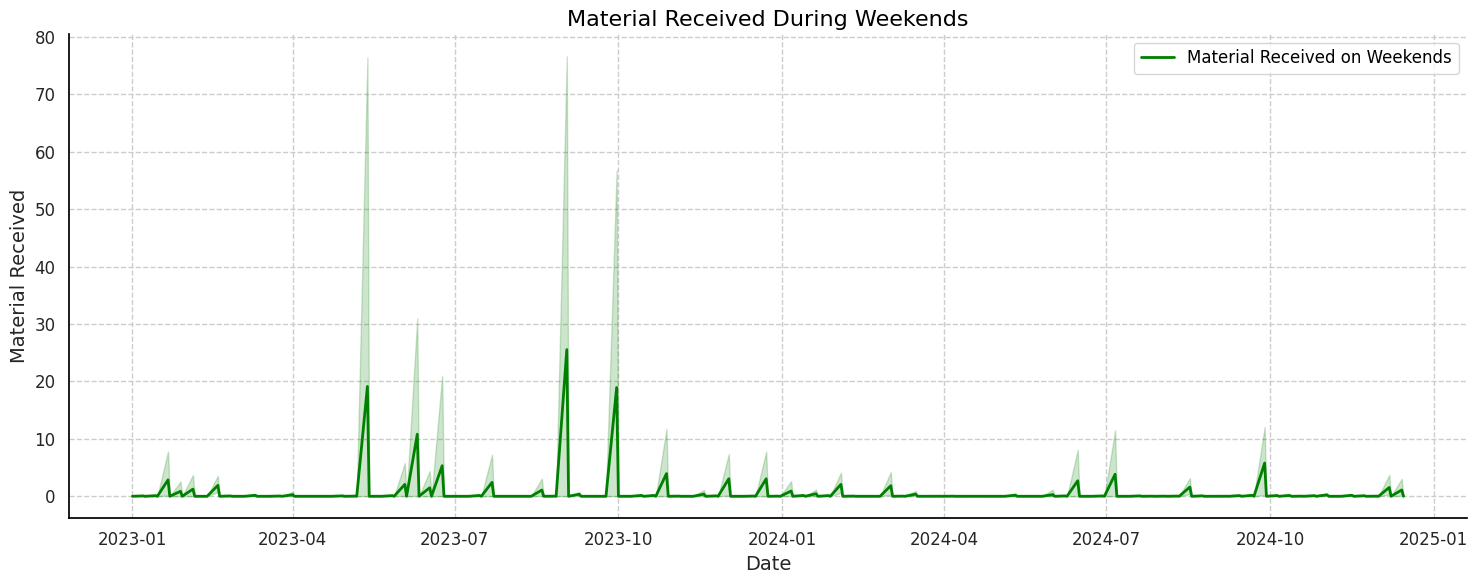

In [149]:
# Add weekday and weekend indicators
data['Weekday'] = data['Date'].dt.day_name()
data['Weekend'] = data['Weekday'].isin(['Saturday', 'Sunday'])
weekend_data = data[data['Weekend']].sort_values('Date')

# Plotting Material Issued during weekends
sns.lineplot(x='Date', y='Material Issued', data=weekend_data, label='Material Issued on Weekends', color='blue', linewidth=2)
plt.title('Material Issued During Weekends')
plt.xlabel('Date')
plt.ylabel('Material Issued')
plt.legend()
plt.tight_layout()
plt.savefig('../results/eda/material_issued_during_weekends.png', format='png', dpi=300)
plt.show()

# Plotting Material Received during weekends
sns.lineplot(x='Date', y='Material Received', data=weekend_data, label='Material Received on Weekends', color='green', linewidth=2)
plt.title('Material Received During Weekends')
plt.xlabel('Date')
plt.ylabel('Material Received')
plt.legend()
plt.tight_layout()
plt.savefig('../results/eda/material_received_during_weekends.png', format='png', dpi=300)
plt.show()



**Material Issuance on Weekends**
* **Spikes in Material Issuance:**
> * There are several noticeable spikes in the graph, indicating periods where a significantly higher amount of material was issued compared to other weekends.
> * The most prominent spike occurs around March 2023, where the material issued reaches approximately 140 units.
> * Other significant spikes are observed around July 2023, January 2024, and October 2024, with material issued reaching around 60-80 units.

* **General Trend:**
> * The overall trend shows that material issuance on weekends is generally low, with most weekends having material issued below 20 units.
> * There are periods of relative stability with low issuance, interspersed with occasional spikes.


**Material Received on Weekends**
* **Spikes in Material Receipt:**
> * There are several noticeable spikes in the graph, indicating periods where a significantly higher amount of material was received compared to other weekends.
> * The most prominent spike occurs around July 2023, where the material received reaches approximately 75 units.
Other significant spikes are observed around April 2023 and October 2023, with material received reaching around 50-60 units.

* **General Trend:**
> * The overall trend shows that material receipt on weekends is generally low, with most weekends having material received below 10 units.
> * There are periods of relative stability with low receipt, interspersed with occasional spikes.


## Inventory Analysis: Calculating FSN (Fast, Slow, Non-Moving) Features for Material Codes

In [70]:
# Assuming calculate_fsn_features is defined elsewhere
def calculate_fsn_features(data, material_code, start_date, end_date):
    # Ensure the 'Date' column is in datetime format
    data['Date'] = pd.to_datetime(data['Date'])

    # Filter data for the specific material code and date range
    material_data = data[(data['Material Code'] == material_code) &
                         (data['Date'] >= start_date) &
                         (data['Date'] <= end_date)].copy()

    if material_data.empty:
        return {
            'Average Stay': float('inf'),  # or handle as needed
            'Consumption Rate': 0,
            'Material Code': material_code
        }

    # Calculate Daily Inventory Holding
    material_data['Daily Inventory Holding'] = (material_data['Open Stock'] + material_data['Closing Stock']) / 2

    # Calculate cumulative inventory holding days and total received quantity
    cumulative_inventory_holding_days = material_data['Daily Inventory Holding'].sum()
    total_received_qty = material_data['Material Received'].sum()

    # Calculate average stay, handling division by zero
    average_stay = cumulative_inventory_holding_days / total_received_qty if total_received_qty != 0 else float('inf')

    # Calculate consumption rate
    total_issued_qty = material_data['Material Issued'].sum()
    consumption_rate = total_issued_qty / material_data['Date'].nunique()  # Assuming daily data

    # Return the features as a dictionary
    return {
        'Average Stay': average_stay,
        'Consumption Rate': consumption_rate,
        'Material Code': material_code
    }


In [71]:
# Assuming 'data' is your DataFrame
# Get unique material codes
material_codes = data['Material Code'].unique()

# Analysis period
start_date = data['Date'].min()
end_date = data['Date'].max()

# Calculate FSN features and store in a list of dictionaries
all_results = []
for material_code in material_codes:
    features = calculate_fsn_features(data, material_code, start_date, end_date)
    all_results.append(features)

# Create a DataFrame from the results
results_df = pd.DataFrame(all_results)

# Print the DataFrame
display(results_df)

# Further analysis (example - sorting by Consumption Rate)
results_df_sorted = results_df.sort_values(by='Consumption Rate', ascending=False)
display("\nSorted by Consumption Rate:\n", results_df_sorted)

Average Stay  Consumption Rate Material Code
0              0.0          0.004184        400015
1              inf          0.000000        400088
2              inf          0.000000        400167
3              inf          0.000000        400176
4              inf          0.000000        400177
...            ...               ...           ...
1042           inf          0.000000      90000090
1043           inf          0.000000      90000105
1044           inf          0.000000      90000170
1045           inf          0.000000      90000300
1046           inf          0.000000      90000301

[1047 rows x 3 columns]

'\nSorted by Consumption Rate:\n'

Average Stay  Consumption Rate Material Code
411      33.541357       2318.888424      10025031
274     692.599185        785.374647      10002203
509     139.428391        625.380753      10036545
654     146.680894        249.058577      10098377
296      96.196275        244.804742      10005075
...            ...               ...           ...
307            inf          0.000000      10020832
306            inf          0.000000      10013263
303            inf          0.000000      10013079
301            inf          0.000000      10009606
1046           inf          0.000000      90000301

[1047 rows x 3 columns]

In [72]:
results_df_sorted = results_df_sorted.merge(data[['Material Code', 'Type', 'BFP']].drop_duplicates(), on='Material Code', how='left')

In [73]:
results_df_sorted.head(10)

Average Stay  Consumption Rate Material Code      Type  BFP
0     33.541357       2318.888424      10025031  Material    0
1    692.599185        785.374647      10002203  Material    0
2    139.428391        625.380753      10036545  Material    0
3    146.680894        249.058577      10098377  Material    0
4     96.196275        244.804742      10005075  Material    0
5    106.049357        173.308229      10102094  Material    0
6    254.892010        114.651325      10099475  Material    0
7    285.309767         92.945607      10025998  Material    0
8    168.021535         79.082287      10022563  Material    0
9    139.541632         77.315202      10025567  Material    0

**Average Stay:**
> * The average stay values range from approximately 33.54 to 692.599 days.
> * Materials with higher average stay values (e.g., 10002203 with 692.599 days) indicate that these items remain in inventory for a longer period before being consumed. This could suggest slower-moving inventory or potential overstocking.
> * Materials with lower average stay values (e.g., 10025031 with 33.54 days) indicate faster turnover, suggesting higher demand or more efficient inventory management.

**Consumption Rate:**
> * The consumption rates range from approximately 77.315 to 2318.888 units per day.
> * Materials with higher consumption rates (e.g., 10025031 with 2318.888 units/day) indicate high demand or usage.
> * Materials with lower consumption rates (e.g., 10025567 with 77.315 units/day) indicate lower demand or usage.

**Inventory Management Insights:**
> * Materials with high average stay and low consumption rates (e.g., 10025567) suggest slow-moving inventory, which could indicate overstocking or low demand.
> * Materials with low average stay and high consumption rates (e.g., 10025031) suggest fast-moving inventory, which could indicate high demand or efficient inventory management.
> * Materials with extremely high average stay values (e.g., 10002203) could be considered non-moving inventory if their consumption rates are not proportionally high. This could indicate obsolete or excess inventory that is not being utilized effectively.

In [74]:
results_df_sorted[results_df_sorted['Type'] == 'Material'][['Average Stay',	'Consumption Rate']].describe()

/home/azeem/Documents/iba-inventory-management-project/project_env/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/azeem/Documents/iba-inventory-management-project/project_env/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Average Stay  Consumption Rate
count    934.000000        934.000000
mean            inf          7.057474
std             NaN         83.962730
min        0.000000          0.000000
25%      297.541485          0.000000
50%             NaN          0.000000
75%             NaN          0.456764
max             inf       2318.888424

**Thresholds Based on Summary Statistics:**

Given the summary statistics, we can set more appropriate thresholds for classifying materials into Fast, Slow, and Non-moving categories:

* **Consumption Rate Thresholds:**
> * `consumption_threshold_high`: Set to a value higher than the 75th percentile to classify materials with a consumption rate greater than 0.46 units per day as Fast-moving.
> * `consumption_threshold_low`: Set to a value between the 25th and 75th percentiles to classify materials with a consumption rate between 0 and 0.46 units per day as Slow-moving.

* **Average Stay Threshold:**
> * `stay_threshold`: Set to a value around the 25th percentile to classify materials with an average stay greater than 297.54 days as Non-moving.

In [75]:
# Example thresholds (adjust these based on your business needs and summary statistics)
consumption_threshold_high = 10  # Fast-moving if Consumption Rate > 10 (higher than 75th percentile)
consumption_threshold_low = 0.1  # Slow-moving if 0.1 < Consumption Rate <= 10 (between 25th and 75th percentiles)
stay_threshold = 300             # Non-moving if Average Stay > 300 days (around 25th percentile)

# Function to classify items
def classify_fsn(row):
    if row['Consumption Rate'] > consumption_threshold_high:
        return 'Fast'
    elif consumption_threshold_low < row['Consumption Rate'] <= consumption_threshold_high and row['Average Stay'] <= stay_threshold:
        return 'Slow'
    else:
        return 'Non-moving'

# Assuming 'results_df' is your DataFrame with 'Average Stay' and 'Consumption Rate' columns
# Apply the classification function
results_df['FSN Category'] = results_df.apply(classify_fsn, axis=1)

# Print the DataFrame
display(results_df)

# Further analysis (example - sorting by Consumption Rate)
results_df_sorted = results_df.sort_values(by='Consumption Rate', ascending=False)
display("\nSorted by Consumption Rate:\n", results_df_sorted)


Average Stay  Consumption Rate Material Code FSN Category
0              0.0          0.004184        400015   Non-moving
1              inf          0.000000        400088   Non-moving
2              inf          0.000000        400167   Non-moving
3              inf          0.000000        400176   Non-moving
4              inf          0.000000        400177   Non-moving
...            ...               ...           ...          ...
1042           inf          0.000000      90000090   Non-moving
1043           inf          0.000000      90000105   Non-moving
1044           inf          0.000000      90000170   Non-moving
1045           inf          0.000000      90000300   Non-moving
1046           inf          0.000000      90000301   Non-moving

[1047 rows x 4 columns]

'\nSorted by Consumption Rate:\n'

Average Stay  Consumption Rate Material Code FSN Category
411      33.541357       2318.888424      10025031         Fast
274     692.599185        785.374647      10002203         Fast
509     139.428391        625.380753      10036545         Fast
654     146.680894        249.058577      10098377         Fast
296      96.196275        244.804742      10005075         Fast
...            ...               ...           ...          ...
307            inf          0.000000      10020832   Non-moving
306            inf          0.000000      10013263   Non-moving
303            inf          0.000000      10013079   Non-moving
301            inf          0.000000      10009606   Non-moving
1046           inf          0.000000      90000301   Non-moving

[1047 rows x 4 columns]

In [76]:
results_df_sorted = results_df_sorted.merge(data[['Material Code', 'Type', 'BFP']].drop_duplicates(), on='Material Code', how='left')

In [77]:
results_df_sorted = results_df_sorted[results_df_sorted['BFP'] == 0]

In [78]:
results_df_sorted.head()

Average Stay  Consumption Rate Material Code FSN Category      Type  BFP
0     33.541357       2318.888424      10025031         Fast  Material    0
1    692.599185        785.374647      10002203         Fast  Material    0
2    139.428391        625.380753      10036545         Fast  Material    0
3    146.680894        249.058577      10098377         Fast  Material    0
4     96.196275        244.804742      10005075         Fast  Material    0

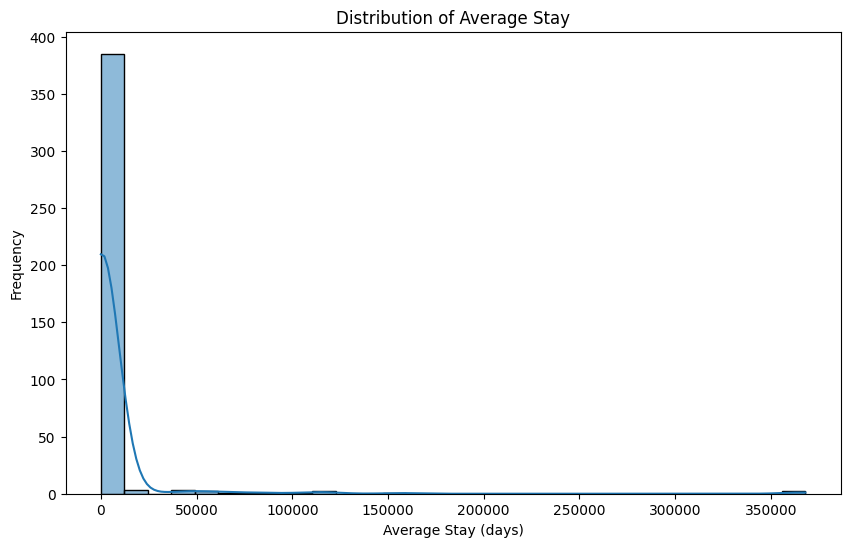

In [79]:
# Plot distribution of Average Stay
plt.figure(figsize=(10, 6))
sns.histplot(results_df_sorted['Average Stay'], bins=30, kde=True)
plt.title('Distribution of Average Stay')
plt.xlabel('Average Stay (days)')
plt.ylabel('Frequency')
plt.savefig('average_stay_distribution.png')
plt.show()

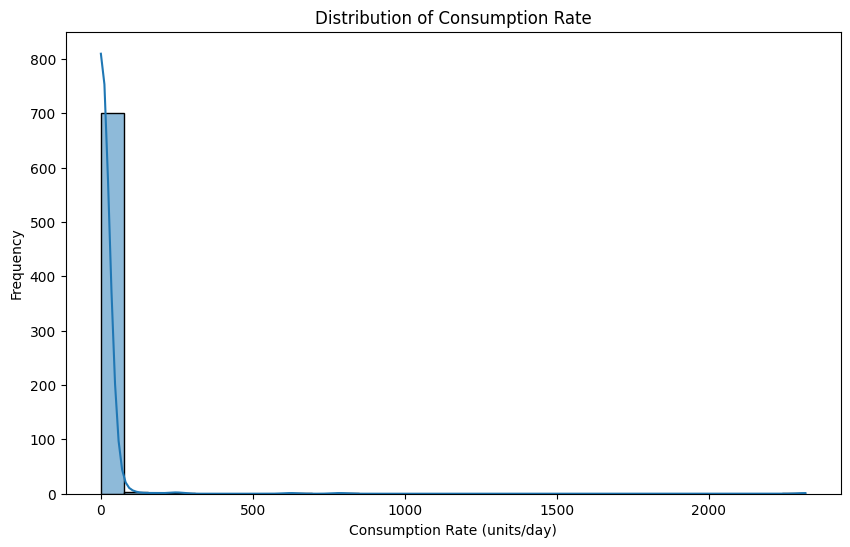

In [80]:
# Plot distribution of Consumption Rate
plt.figure(figsize=(10, 6))
sns.histplot(results_df_sorted['Consumption Rate'], bins=30, kde=True)
plt.title('Distribution of Consumption Rate')
plt.xlabel('Consumption Rate (units/day)')
plt.ylabel('Frequency')
plt.savefig('consumption_rate_distribution.png')
plt.show()

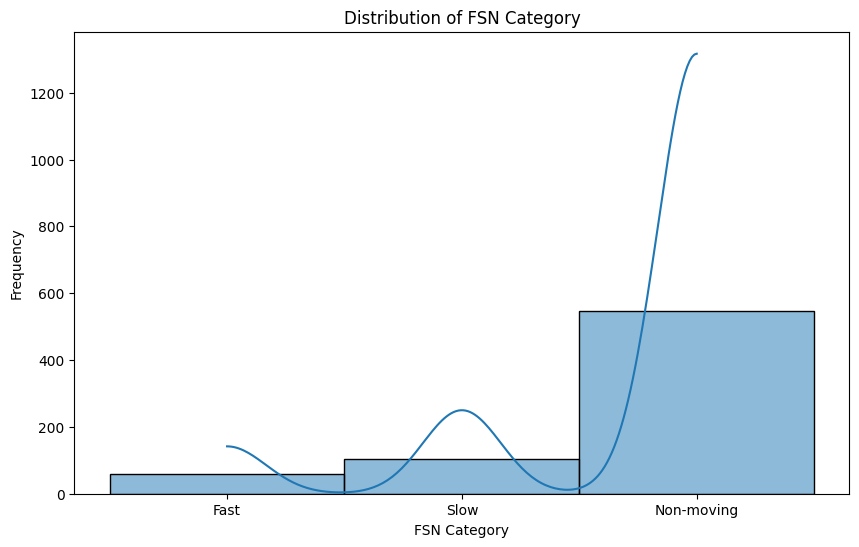

In [81]:
# Plot distribution of Consumption Rate
plt.figure(figsize=(10, 6))
sns.histplot(results_df_sorted['FSN Category'], bins=30, kde=True)
plt.title('Distribution of FSN Category')
plt.xlabel('FSN Category')
plt.ylabel('Frequency')
plt.savefig('fsn_category_distribution.png')
plt.show()

<Figure size 1200x800 with 0 Axes>

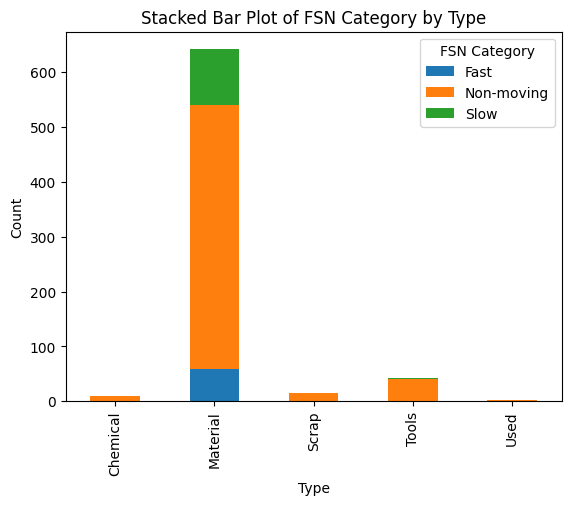

In [82]:
# Plot stacked bar for FSN Category with Type
plt.figure(figsize=(12, 8))
stacked_bar = results_df_sorted.groupby(['Type', 'FSN Category']).size().unstack(fill_value=0)
stacked_bar.plot(kind='bar', stacked=True)
plt.title('Stacked Bar Plot of FSN Category by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.legend(title='FSN Category')
plt.savefig('stacked_bar_fsn_category_type.png')
plt.show()

## Re-Order Level & Safety Stock

In [83]:
# Filter data where Type is 'Material' and BFP is 0
filtered_inventory = data[(data['Type'] == 'Material') & (data['BFP'] == 0)]

# Set opening and closing stock dates
opening_stock_date = filtered_inventory['Date'].min()
closing_stock_date = filtered_inventory['Date'].max()

# Extract opening and closing stock data
opening_stock = filtered_inventory[filtered_inventory['Date'] == opening_stock_date][['Material Code', 'Open Stock']]
closing_stock = filtered_inventory[filtered_inventory['Date'] == closing_stock_date][['Material Code', 'Closing Stock']]

# Merge opening and closing stock data
stock_data = pd.merge(opening_stock, closing_stock, on='Material Code', how='inner')

# Calculate average consumption and receipt
consumption_data = filtered_inventory.groupby('Material Code').agg({
    'Material Issued': ['mean', 'sum'],
    'Material Received': ['mean', 'sum']
}).rename(columns={
    'mean': 'Average',
    'sum': 'Total'
})
consumption_data.columns = ['Avg Issued', 'Total Issued', 'Avg Received', 'Total Received']
consumption_data = consumption_data.reset_index()

# Merge with stock data
final_data = pd.merge(stock_data, consumption_data, on='Material Code', how='inner')

# Calculate Reorder Level and Safety Stock
final_data['Reorder Level'] = np.ceil(final_data['Avg Issued'] * 2)  # Assuming 2 periods lead time
final_data['Safety Stock'] = np.ceil(final_data['Avg Issued'] * 0.5)  # Assuming 50% of consumption as safety stock

# Calculate Optimal Stock Level
final_data['Optimal Stock Level'] = final_data['Reorder Level'] + final_data['Safety Stock']

# Identify Top 10 Materials by Reorder Level
top_10_reorder = final_data.nlargest(10, 'Reorder Level')

# Identify Top 10 Materials by Safety Stock
top_10_safety_stock = final_data.nlargest(10, 'Safety Stock')

# Display the final data
print("Final Inventory Data with Reorder Level and Safety Stock:")
display(final_data.head())

# Display top 10 materials by Reorder Level and Safety Stock
print("\nTop 10 Materials by Reorder Level:")
display(top_10_reorder)

print("\nTop 10 Materials by Safety Stock:")
display(top_10_safety_stock)


Final Inventory Data with Reorder Level and Safety Stock:


Material Code  Open Stock  Closing Stock  Avg Issued  Total Issued  \
0      10000033        88.0            0.0    1.072524         769.0   
1      10000304       735.0          206.0    1.506276        1080.0   
2      10000314        29.0           16.0    0.111576          80.0   
3      10000316       210.0          196.0    1.227336         880.0   
4      10000318       240.0          259.0    1.944212        1394.0   

   Avg Received  Total Received  Reorder Level  Safety Stock  \
0      0.949791           681.0            3.0           1.0   
1      0.768480           551.0            4.0           1.0   
2      0.093445            67.0            1.0           1.0   
3      1.207810           866.0            3.0           1.0   
4      1.970711          1413.0            4.0           1.0   

   Optimal Stock Level  
0                  4.0  
1                  5.0  
2                  2.0  
3                  4.0  
4                  5.0


Top 10 Materials by Reorder Level:


Material Code  Open Stock  Closing Stock   Avg Issued  Total Issued  \
220      10025031     73143.0       3435.000  2318.888424   1662643.000   
145      10002203    395977.0     192192.378   785.374647    563113.622   
268      10036545     32414.0      38416.000   625.380753    448398.000   
358      10098377     34510.0      16783.000   249.058577    178575.000   
162      10005075       859.0       5637.000   244.804742    175525.000   
420      10102094     18721.0      25727.000   173.308229    124262.000   
383      10099475         0.0      15156.000   114.651325     82205.000   
226      10025998     28624.0      35865.000    92.945607     66642.000   
190      10022563       300.0       5496.000    79.082287     56702.000   
222      10025567       618.0      10434.000    77.315202     55435.000   

     Avg Received  Total Received  Reorder Level  Safety Stock  \
220   2221.666667       1592935.0         4638.0        1160.0   
145    501.156206        359329.0         1571.0         393.0   
268    633.751743        454400.0         1251.0         313.0   
358    224.334728        160848.0          499.0         125.0   
162    251.468619        180303.0          490.0         123.0   
420    183.079498        131268.0          347.0          87.0   
383    135.789400         97361.0          230.0          58.0   
226    103.044630         73883.0          186.0          47.0   
190     86.329149         61898.0          159.0          40.0   
222     91.005579         65251.0          155.0          39.0   

     Optimal Stock Level  
220               5798.0  
145               1964.0  
268               1564.0  
358                624.0  
162                613.0  
420                434.0  
383                288.0  
226                233.0  
190                199.0  
222                194.0


Top 10 Materials by Safety Stock:


Material Code  Open Stock  Closing Stock   Avg Issued  Total Issued  \
220      10025031     73143.0       3435.000  2318.888424   1662643.000   
145      10002203    395977.0     192192.378   785.374647    563113.622   
268      10036545     32414.0      38416.000   625.380753    448398.000   
358      10098377     34510.0      16783.000   249.058577    178575.000   
162      10005075       859.0       5637.000   244.804742    175525.000   
420      10102094     18721.0      25727.000   173.308229    124262.000   
383      10099475         0.0      15156.000   114.651325     82205.000   
226      10025998     28624.0      35865.000    92.945607     66642.000   
190      10022563       300.0       5496.000    79.082287     56702.000   
222      10025567       618.0      10434.000    77.315202     55435.000   

     Avg Received  Total Received  Reorder Level  Safety Stock  \
220   2221.666667       1592935.0         4638.0        1160.0   
145    501.156206        359329.0         1571.0         393.0   
268    633.751743        454400.0         1251.0         313.0   
358    224.334728        160848.0          499.0         125.0   
162    251.468619        180303.0          490.0         123.0   
420    183.079498        131268.0          347.0          87.0   
383    135.789400         97361.0          230.0          58.0   
226    103.044630         73883.0          186.0          47.0   
190     86.329149         61898.0          159.0          40.0   
222     91.005579         65251.0          155.0          39.0   

     Optimal Stock Level  
220               5798.0  
145               1964.0  
268               1564.0  
358                624.0  
162                613.0  
420                434.0  
383                288.0  
226                233.0  
190                199.0  
222                194.0

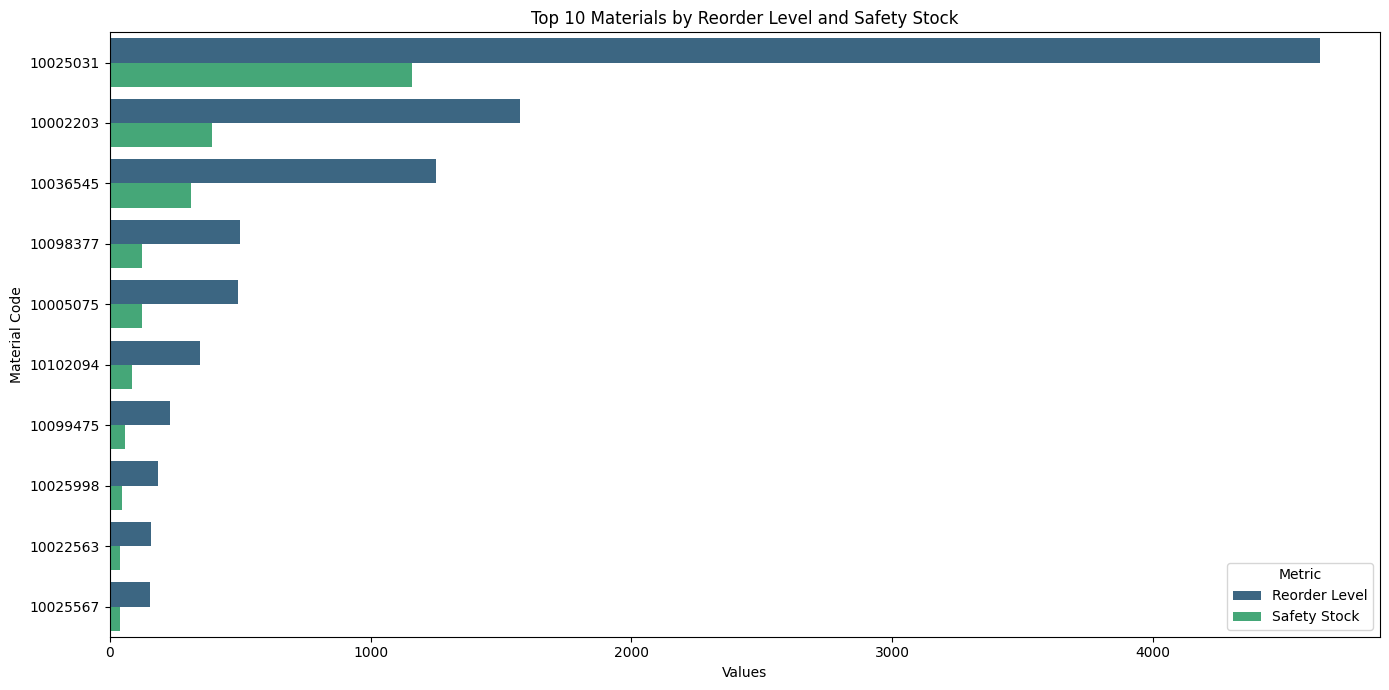

In [84]:
# Identify Top 10 Materials by Reorder Level
top_10_reorder = final_data.nlargest(10, 'Reorder Level')

# Identify Top 10 Materials by Safety Stock
top_10_safety_stock = final_data.nlargest(10, 'Safety Stock')

# Combine the top 10 materials for both reorder level and safety stock
combined_top_10 = pd.concat([top_10_reorder, top_10_safety_stock]).drop_duplicates(subset=['Material Code'])

# Melt the data for seaborn
melted_data = combined_top_10.melt(id_vars=['Material Code'], value_vars=['Reorder Level', 'Safety Stock'],
                                   var_name='Metric', value_name='Value')

# Plot the data using seaborn
plt.figure(figsize=(14, 7))
sns.barplot(x='Value', y='Material Code', hue='Metric', data=melted_data, palette='viridis')

# Add labels, title, and custom x-axis tick labels, etc.
plt.xlabel('Values')
plt.ylabel('Material Code')
plt.title('Top 10 Materials by Reorder Level and Safety Stock')
plt.legend(title='Metric')

# Adjust layout
plt.tight_layout()

plt.savefig('top_10_materials_reorder_safety_stock.png')
# Display the plot
plt.show()

In [85]:
top_10_reorder_amt = top_10_reorder.merge(data.groupby(['Material Code'])['Price'].mean(), on='Material Code', how='left')
top_10_reorder_amt['Reorder Amount'] = top_10_reorder_amt['Reorder Level'] * top_10_reorder_amt['Price']
top_10_reorder_amt['Safety Stock Amount'] = top_10_reorder_amt['Safety Stock'] * top_10_reorder_amt['Price']
top_10_reorder_amt

Material Code  Open Stock  Closing Stock   Avg Issued  Total Issued  \
0      10025031     73143.0       3435.000  2318.888424   1662643.000   
1      10002203    395977.0     192192.378   785.374647    563113.622   
2      10036545     32414.0      38416.000   625.380753    448398.000   
3      10098377     34510.0      16783.000   249.058577    178575.000   
4      10005075       859.0       5637.000   244.804742    175525.000   
5      10102094     18721.0      25727.000   173.308229    124262.000   
6      10099475         0.0      15156.000   114.651325     82205.000   
7      10025998     28624.0      35865.000    92.945607     66642.000   
8      10022563       300.0       5496.000    79.082287     56702.000   
9      10025567       618.0      10434.000    77.315202     55435.000   

   Avg Received  Total Received  Reorder Level  Safety Stock  \
0   2221.666667       1592935.0         4638.0        1160.0   
1    501.156206        359329.0         1571.0         393.0   
2    633.751743        454400.0         1251.0         313.0   
3    224.334728        160848.0          499.0         125.0   
4    251.468619        180303.0          490.0         123.0   
5    183.079498        131268.0          347.0          87.0   
6    135.789400         97361.0          230.0          58.0   
7    103.044630         73883.0          186.0          47.0   
8     86.329149         61898.0          159.0          40.0   
9     91.005579         65251.0          155.0          39.0   

   Optimal Stock Level     Price  Reorder Amount  Safety Stock Amount  
0               5798.0     27.87       129261.06             32329.20  
1               1964.0      3.67         5765.57              1442.31  
2               1564.0     84.38       105559.38             26410.94  
3                624.0  11821.30      5898828.70           1477662.50  
4                613.0   9916.78      4859222.20           1219763.94  
5                434.0    573.25       198917.75             49872.75  
6                288.0    553.83       127380.90             32122.14  
7                233.0     11.03         2051.58               518.41  
8                199.0      5.68          903.12               227.20  
9                194.0   1417.48       219709.40             55281.72

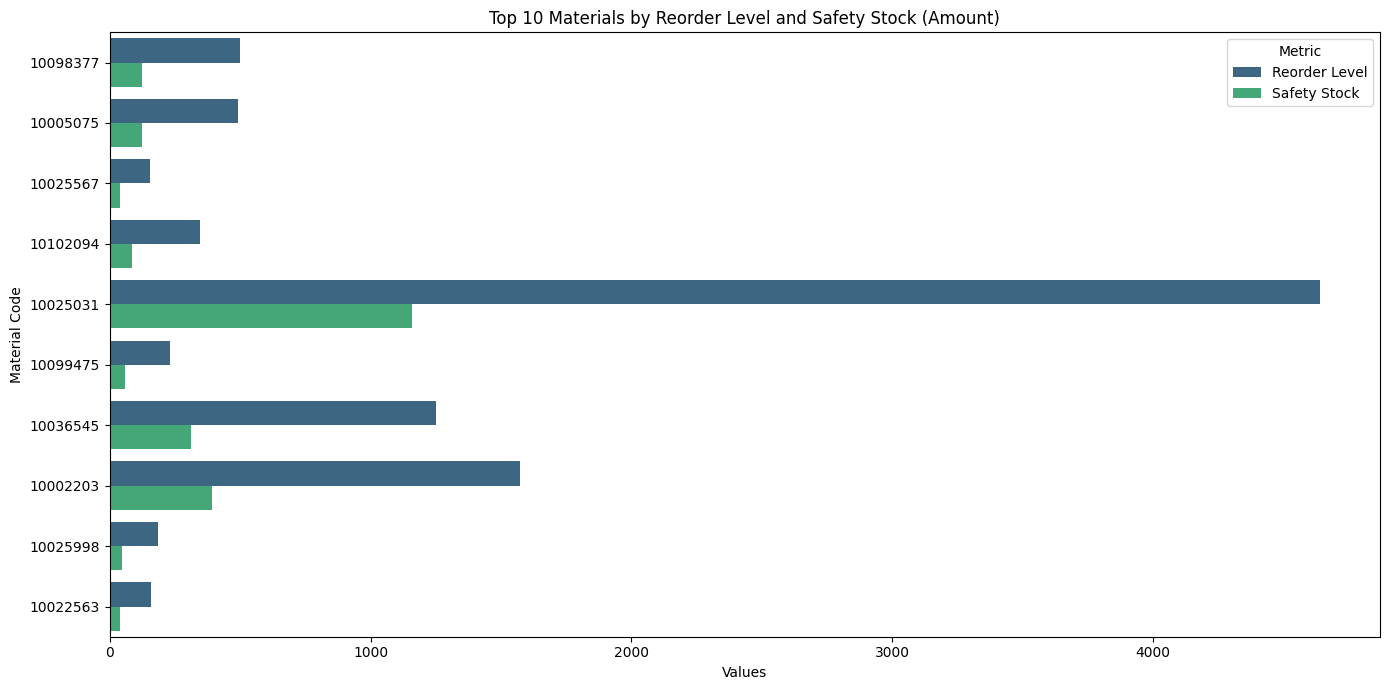

In [86]:
# Identify Top 10 Materials by Reorder Level
top_10_reorder = top_10_reorder_amt.nlargest(10, 'Reorder Amount')

# Identify Top 10 Materials by Safety Stock
top_10_safety_stock = top_10_reorder_amt.nlargest(10, 'Safety Stock Amount')

# Combine the top 10 materials for both reorder level and safety stock
combined_top_10 = pd.concat([top_10_reorder, top_10_safety_stock]).drop_duplicates(subset=['Material Code'])

# Melt the data for seaborn
melted_data = combined_top_10.melt(id_vars=['Material Code'], value_vars=['Reorder Level', 'Safety Stock'],
                                   var_name='Metric', value_name='Value')

# Plot the data using seaborn
plt.figure(figsize=(14, 7))
sns.barplot(x='Value', y='Material Code', hue='Metric', data=melted_data, palette='viridis')

# Add labels, title, and custom x-axis tick labels, etc.
plt.xlabel('Values')
plt.ylabel('Material Code')
plt.title('Top 10 Materials by Reorder Level and Safety Stock (Amount)')
plt.legend(title='Metric')

# Adjust layout
plt.tight_layout()

plt.savefig('top_10_materials_reorder_safety_stock_amt.png')
# Display the plot
plt.show()

ABC Analysis Results:


Material Code  Total Amount  Cumulative Amount  Cumulative Percentage  \
654      10098377  2.110989e+09       2.110989e+09              16.991835   
296      10005075  1.740643e+09       3.851631e+09              31.002671   
903      10119319  8.385167e+08       4.690148e+09              37.752086   
120      10000710  6.479821e+08       5.338130e+09              42.967844   
117      10000698  5.357156e+08       5.873846e+09              47.279942   

    Category  
654        A  
296        A  
903        A  
120        A  
117        A


Summary of ABC Categories:


Category
C    600
B     29
A     13
Name: count, dtype: int64

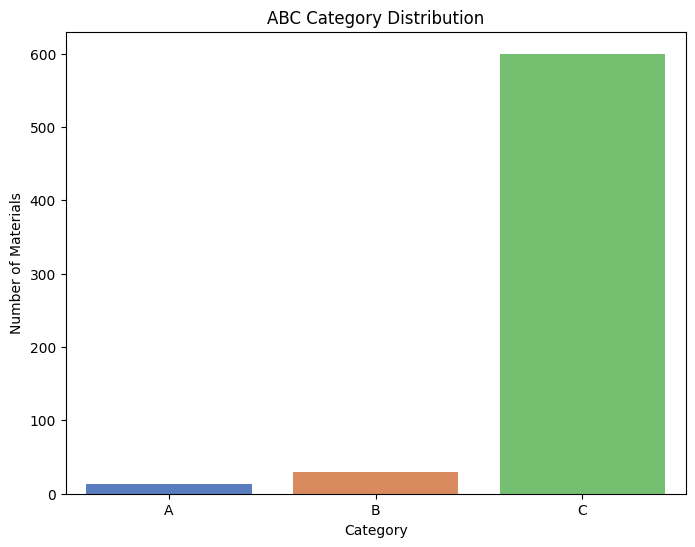

In [87]:
# Filter data where Type is 'Material' and BFP is 0
filtered_inventory = data[(data['Type'] == 'Material') & (data['BFP'] == 0)].copy()

# Calculate Amount using Price column
filtered_inventory.loc[:, 'Amount'] = filtered_inventory['Material Issued'] * filtered_inventory['Price']

# Perform ABC Analysis
# Calculate total amount per material
filtered_inventory.loc[:, 'Total Amount'] = filtered_inventory.groupby('Material Code')['Amount'].transform('sum')

# Drop duplicates and sort by total amount in descending order
abc_data = filtered_inventory[['Material Code', 'Total Amount']].drop_duplicates().sort_values(by='Total Amount', ascending=False)

# Calculate cumulative percentage
abc_data['Cumulative Amount'] = abc_data['Total Amount'].cumsum()
abc_data['Cumulative Percentage'] = (abc_data['Cumulative Amount'] / abc_data['Total Amount'].sum()) * 100

# Categorize materials into A, B, and C categories
abc_data['Category'] = pd.cut(abc_data['Cumulative Percentage'], bins=[0, 70, 90, 100], labels=['A', 'B', 'C'])

# Display the results
print("ABC Analysis Results:")
display(abc_data.head())

# Count materials in each category
abc_summary = abc_data['Category'].value_counts()
print("\nSummary of ABC Categories:")
display(abc_summary)

# Visualization: ABC Categories
plt.figure(figsize=(8, 6))
sns.barplot(x=abc_summary.index, y=abc_summary.values, hue=abc_summary.index, palette='muted', legend=False)
plt.title('ABC Category Distribution')
plt.xlabel('Category')
plt.ylabel('Number of Materials')
plt.savefig('abc_category_distribution.png')
plt.show()


## Autocorrelation

In [88]:
data = data.sort_values('Date')

In [89]:
# Plot autocorrelation for each material in the top_issued_df
for material in top_issued_df['Material Description']:
    material_data = data[data['Material Description'] == material]
    if not material_data.empty:
        plt.figure(figsize=(10, 6))
        print(f'Autocorrelation of Material Issued for {material}')
        plot_acf(material_data['Material Issued'], lags=50)
        plt.xlabel('Lags')
        plt.ylabel('Autocorrelation')
        plt.show()

KeyError: 'Material Description'

In [ ]:
# Create autocorrelation matrix for all materials
material_list = data['Material Description'].unique()
autocorr_matrix = pd.DataFrame(index=range(50), columns=material_list)  # Max 50 lags

for material in material_list:
    material_data = data[data['Material Description'] == material]['Material Issued']
    if len(material_data) > 1:
        autocorr_values = [material_data.autocorr(lag) for lag in range(50)]
        autocorr_matrix[material] = autocorr_values

# Replace NaN with zeros for better readability
autocorr_matrix = autocorr_matrix.fillna(0)

# Save autocorrelation matrix to a CSV file
autocorr_matrix.to_csv('/content/drive/MyDrive/MSDS_Project/autocorrelation_matrix.csv', index=False)

print("Autocorrelation matrix saved as 'autocorrelation_matrix.csv'.")

In [ ]:
autocorr_matrix.head()

In [ ]:
# Filter data where Type is 'Material' and BFP is 0
filtered_inventory = inventory[(inventory['Type'] == 'Material') & (inventory['BFP'] == 0)]

# Set opening and closing stock dates
opening_stock_date = inventory['Date'].min()
closing_stock_date = inventory['Date'].max()

# Extract opening and closing stock data
opening_stock = filtered_inventory[filtered_inventory['Date'] == opening_stock_date][['Material Code', 'Material Description', 'Open Stock']]
closing_stock = filtered_inventory[filtered_inventory['Date'] == closing_stock_date][['Material Code', 'Closing Stock']]

# Merge opening and closing stock data
stock_data = pd.merge(opening_stock, closing_stock, on='Material Code', how='inner')

# Calculate average consumption and receipt
consumption_data = filtered_inventory.groupby('Material Code').agg({
    'Material Issued': ['mean', 'sum'],
    'Material Received': ['mean', 'sum']
}).rename(columns={
    'mean': 'Average',
    'sum': 'Total'
})
consumption_data.columns = ['Avg Issued', 'Total Issued', 'Avg Received', 'Total Received']
consumption_data = consumption_data.reset_index()

# Merge with stock data
final_data = pd.merge(stock_data, consumption_data, on='Material Code', how='inner')

# Calculate Reorder Level and Safety Stock
final_data['Reorder Level'] = np.ceil(final_data['Avg Issued'] * 2)  # Assuming 2 periods lead time
final_data['Safety Stock'] = np.ceil(final_data['Avg Issued'] * 0.5)  # Assuming 50% of consumption as safety stock

# Calculate Optimal Stock Level
final_data['Optimal Stock Level'] = final_data['Reorder Level'] + final_data['Safety Stock']

# Identify Top 10 Materials by Reorder Level
top_10_reorder = final_data.nlargest(10, 'Reorder Level')

# Identify Top 10 Materials by Safety Stock
top_10_safety_stock = final_data.nlargest(10, 'Safety Stock')

# Display the final data
print("Final Inventory Data with Reorder Level and Safety Stock:")
display(final_data.head())

In [ ]:
# Filter data where Type is 'Material' and BFP is 0
filtered_inventory = inventory[(inventory['Type'] == 'Material') & (inventory['BFP'] == 0)].copy()

# Calculate Amount using Price column
filtered_inventory.loc[:, 'Amount'] = filtered_inventory['Material Issued'] * filtered_inventory['Price']

# Perform ABC Analysis
# Calculate total amount per material
filtered_inventory.loc[:, 'Total Amount'] = filtered_inventory.groupby('Material Code')['Amount'].transform('sum')

# Drop duplicates and sort by total amount in descending order
abc_data = filtered_inventory[['Material Code', 'Total Amount']].drop_duplicates().sort_values(by='Total Amount', ascending=False)

# Calculate cumulative percentage
abc_data['Cumulative Amount'] = abc_data['Total Amount'].cumsum()
abc_data['Cumulative Percentage'] = (abc_data['Cumulative Amount'] / abc_data['Total Amount'].sum()) * 100

# Categorize materials into A, B, and C categories
abc_data['Category'] = pd.cut(abc_data['Cumulative Percentage'], bins=[0, 70, 90, 100], labels=['A', 'B', 'C'])

# Display the results
print("ABC Analysis Results:")
display(abc_data.head())

# Count materials in each category
abc_summary = abc_data['Category'].value_counts()
print("\nSummary of ABC Categories:")
display(abc_summary)

# Visualization: ABC Categories
plt.figure(figsize=(8, 6))
sns.barplot(x=abc_summary.index, y=abc_summary.values, hue=abc_summary.index, palette='muted', legend=False)
plt.title('ABC Category Distribution')
plt.xlabel('Category')
plt.ylabel('Number of Materials')
plt.show()
